In [26]:
import sys, os
from pathlib import Path
project_dir = Path.cwd()
os.chdir(project_dir)
sys.path.append(os.getcwd())
# os.chdir('change to the mother working directory')

import bs4 as bs
from bs4 import BeautifulSoup
import requests
import yfinance as yf
from typing import Tuple, Dict, Optional
from tqdm import tqdm
import time
import pandas as pd
from datetime import datetime, timedelta
import json
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import stockstats
import numpy as np
# from alpha_vantage.timeseries import TimeSeries

## TICKER INFO

In [27]:
def save_sp500_information() -> Tuple[Dict[str, Dict[str, str]], Dict[str, Dict[str, str]]]:
    """
    Scrapes current and historical S&P 500 company information from Wikipedia.

    Returns:
        A tuple containing two dictionaries:
            - tickers: Information about current S&P 500 constituents.
            - removed_tickers: Information about companies removed from the S&P 500.
    """
    # URL of the Wikipedia page containing S&P 500 information
    url = 'http://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    
    # Send a GET request to the Wikipedia page
    try:
        resp = requests.get(url)
        resp.raise_for_status()  # Raises HTTPError for bad responses (4xx and 5xx)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from Wikipedia: {e}")
        return {}, {}

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(resp.text, 'lxml')
    
    # Initialize dictionaries to hold ticker information
    tickers: Dict[str, Dict[str, str]] = {}
    removed_tickers: Dict[str, Dict[str, str]] = {}
    
    # Find the table with current S&P 500 constituents
    table_constituents = soup.find('table', {'class': 'wikitable sortable', 'id': 'constituents'})
    if not table_constituents:
        print("Could not find the 'constituents' table on the Wikipedia page.")
        return {}, {}
    
    # Extract current constituents
    for row in table_constituents.find_all('tr')[1:]:
        cols = row.find_all('td')
        if len(cols) < 7:
            continue  # Skip rows that don't have enough columns
        ticker = cols[0].text.strip()
        tickers[ticker] = {
            'company_names': cols[1].text.strip(),
            'gics_sector': cols[3].text.strip(),
            'gics_sub_industry': cols[4].text.strip(),
            'date': cols[6].text.strip(),
        }
    
    # Find the table with historical changes
    table_changes = soup.find('table', {'class': 'wikitable sortable', 'id': 'changes'})
    if not table_changes:
        print("Could not find the 'changes' table on the Wikipedia page.")
        return tickers, {}
    
    # Extract removed constituents
    for row in table_changes.find_all('tr')[2:]:
        cols = row.find_all('td')
        if len(cols) < 5:
            continue  # Skip rows that don't have enough columns
        ticker = cols[3].text.strip()
        if not ticker:
            continue  # Skip if ticker is empty
        removed_tickers[ticker] = {
            'date': cols[0].text.strip(),
            'company_names': cols[4].text.strip(),
            'reason': cols[5].text.strip() if len(cols) > 5 else '',
        }
    
    return tickers, removed_tickers

def process_ticker_information(num_tickers: Optional[int] = None) -> None:
    """
    Processes S&P 500 ticker information by merging data from Wikipedia and Yahoo Finance,
    cleans and fixes the data, and saves the result as a CSV file named 'ticker_name_list.csv'.

    Args:
        num_tickers (int, optional): Number of tickers to process for testing purposes.
                                    If None, processes all tickers.

    Returns:
        None
    """
    # Get tickers and removed_tickers
    tickers, removed_tickers = save_sp500_information()

    # Convert dictionaries to DataFrames
    wiki_tickers = pd.DataFrame(tickers).T
    wiki_removed_tickers = pd.DataFrame(removed_tickers).T

    # Convert 'date' columns to datetime
    wiki_removed_tickers['date'] = pd.to_datetime(wiki_removed_tickers['date'], errors='coerce')

    # Filter 'wiki_removed_tickers' for dates less than now and years >= 2000
    wiki_removed_tickers = wiki_removed_tickers[wiki_removed_tickers['date'] < datetime.now()]
    wiki_removed_tickers = wiki_removed_tickers[wiki_removed_tickers['date'].dt.year >= 2000]

    # Convert DataFrames back to dictionaries
    wiki_tickers = wiki_tickers.T.to_dict()
    wiki_removed_tickers = wiki_removed_tickers.T.to_dict()

    # Combine the name lists
    ticker_name_list = {}
    for ticker in wiki_tickers:
        ticker_name_list[ticker] = {}
        ticker_name_list[ticker]['wiki_name'] = [wiki_tickers[ticker]['company_names']]
    for ticker in wiki_removed_tickers:
        if ticker in ticker_name_list:
            ticker_name_list[ticker]['wiki_name'].append(wiki_removed_tickers[ticker]['company_names'])
        else:
            ticker_name_list[ticker] = {}
            ticker_name_list[ticker]['wiki_name'] = [wiki_removed_tickers[ticker]['company_names']]

    # Regulate '.' to '-'
    tickers_with_dot = [ticker for ticker in ticker_name_list if '.' in ticker]
    for ticker in tickers_with_dot:
        new_ticker = ticker.replace('.', '-')
        ticker_name_list[new_ticker] = ticker_name_list.pop(ticker)

    # Initialize ticker_info_data
    ticker_info_data = {ticker: {} for ticker in ticker_name_list}

    # Get list of tickers to process
    tickers_to_process = list(ticker_name_list.keys())
    if num_tickers is not None:
        tickers_to_process = tickers_to_process[:num_tickers]

    # Fetch data from yfinance
    want_keys = ['sector', 'industry', 'shortName', 'longName']
    print("Fetching data from Yahoo Finance...")
    for ticker in tqdm(tickers_to_process):
        stock = yf.Ticker(ticker)
        try:
            ticker_info_data[ticker] = stock.info
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            ticker_info_data[ticker] = {}
        time.sleep(5)  # Adjust sleep time as needed

    # Check for missing data and fix manually
    print("\nChecking for missing data and applying manual fixes...")
    for ticker in ticker_info_data:
        if not ticker_info_data[ticker]:
            print(f"No data for ticker {ticker}")
        else:
            for key in want_keys:
                if key not in ticker_info_data[ticker]:
                    print(f"Missing {key} for ticker {ticker}")

    # Manually fixing missing data
    manual_fixes = {
        'GD': {'sector': 'Industrials', 'industry': 'Aerospace & Defense'},
        'JCP': {'sector': 'Consumer Cyclical', 'industry': 'Department Stores'},
        'LM': {'sector': 'Financial Services', 'industry': 'Asset Management'},
        'NE': {'sector': 'Energy', 'industry': 'Oil & Gas'},
        'CHK': {
            'sector': 'Energy',
            'industry': 'Oil & Gas E&P',
            'shortName': 'Chesapeake Energy Corporation',
            'longName': 'Chesapeake Energy Corporation',
        },
        'DNR': {
            'sector': 'Energy',
            'industry': 'Oil & Gas E&P',
            'shortName': 'Denbury Resources',
            'longName': 'Denbury Resources Inc.',
        },
    }

    for ticker, fixes in manual_fixes.items():
        if ticker in ticker_info_data:
            ticker_info_data[ticker].update(fixes)

    # Keep only the information we want
    for ticker in ticker_info_data:
        have_keys = list(set(ticker_info_data[ticker].keys()).intersection(set(want_keys)))
        ticker_info_data[ticker] = {_key: ticker_info_data[ticker][_key] for _key in have_keys}

    # Merge the data
    for ticker in ticker_name_list:
        if ticker in ticker_info_data:
            for item in ticker_info_data[ticker]:
                ticker_name_list[ticker][item] = ticker_info_data[ticker][item]

    # Convert ticker_name_list to DataFrame
    df = pd.DataFrame.from_dict(ticker_name_list, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'ticker'}, inplace=True)

    # Save to CSV
    print("\nSaving ticker to .csv file........................")
    df.to_csv('data_restrict\\ticker_name_list.csv', index=False)
    print("\nTicker name list saved to 'ticker_name_list.csv'.")

## STOCK DATA

In [28]:
def download_stock_data(
    ticker_csv_file: str,
    alpha_vantage_api_key: Optional[str] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    period: str = 'max',
    save_dir: str = 'data/',
    num_tickers: Optional[int] = None,
    include_vantage = False
) -> None:
    """
    Downloads historical stock data from Yahoo Finance and Alpha Vantage for tickers listed in a CSV file,
    and saves the data into CSV files.

    Args:
        ticker_csv_file (str): Path to the CSV file containing ticker information.
        alpha_vantage_api_key (str, optional): Your Alpha Vantage API key for downloading using Alpha Vantage.
        start_date (str, optional): Start date in 'YYYY-MM-DD' format. Defaults to None.
        end_date (str, optional): End date in 'YYYY-MM-DD' format. Defaults to None.
        period (str, optional): Data period for Yahoo Finance (e.g., '1d', '1mo', '1y', 'max'). Defaults to 'max'.
        save_dir (str, optional): Directory to save the downloaded data. Defaults to 'data/'.
        num_tickers (int, optional): Number of tickers to process for testing purposes. If None, processes all tickers.

    Returns:
        None
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)


    # Read tickers from CSV file
    tickers_df = pd.read_csv(os.path.join(save_dir, ticker_csv_file))
    tickers = tickers_df['ticker'].tolist()

    # Limit the number of tickers if num_tickers is specified
    if num_tickers is not None:
        tickers = tickers[:num_tickers]

    # Initialize lists to collect data
    yf_data_list = []
    av_data_list = []

    # Download data from Yahoo Finance
    print("Downloading data from Yahoo Finance...")
    for ticker in tqdm(tickers, desc='Yahoo Finance'):
        stock = yf.Ticker(ticker)
        try:
            # Download historical data
            if start_date or end_date:
                _closing_dat = stock.history(
                    start=start_date,
                    end=end_date,
                    auto_adjust=False,
                    back_adjust=False,
                    rounding=False
                )
            else:
                _closing_dat = stock.history(
                    period=period,
                    auto_adjust=False,
                    back_adjust=False,
                    rounding=False
                )
            # Add 'Ticker' column
            _closing_dat['Ticker'] = ticker
            # Append to list
            yf_data_list.append(_closing_dat)
        except Exception as e:
            print(f"Error downloading data for {ticker} from Yahoo Finance: {e}")
        time.sleep(1)  # Sleep to respect API rate limits

    # Concatenate all data into one DataFrame
    if yf_data_list:
        yf_all_data = pd.concat(yf_data_list)
        # Reset index to have 'Date' as a column
        yf_all_data.reset_index(inplace=True)
        yf_all_data['Date'] = pd.to_datetime(yf_all_data['Date'], utc=True).dt.tz_convert(None).dt.normalize()
        # Save to CSV
        yf_save_file = os.path.join(save_dir, 'stock_data_YF.csv')
        yf_all_data.to_csv(yf_save_file, index=False)
        print(f"Yahoo Finance data saved to '{yf_save_file}'.")
    else:
        print("No data downloaded from Yahoo Finance.")

    # Download data from Alpha Vantage
    if include_vantage:
        print("\nDownloading data from Alpha Vantage...")

        if not alpha_vantage_api_key or alpha_vantage_api_key is None:
            raise ValueError("Alpha Vantage API key not found or set to None when using this engine. Please set the 'ALPHA_VANTAGE_API_KEY' environment variable.")
        ts = TimeSeries(key=alpha_vantage_api_key, output_format='pandas')
        for ticker in tqdm(tickers, desc='Alpha Vantage'):
            try:
                # Download historical data
                data, _ = ts.get_daily_adjusted(symbol=ticker, outputsize='full')
                # Rename columns to match Yahoo Finance format
                data.rename(columns={
                    '1. open': 'Open',
                    '2. high': 'High',
                    '3. low': 'Low',
                    '4. close': 'Close',
                    '5. adjusted close': 'Adj Close',
                    '6. volume': 'Volume',
                    '7. dividend amount': 'Dividend Amount',
                    '8. split coefficient': 'Split Coefficient'
                }, inplace=True)
                # Reset index to make 'Date' a column
                data.reset_index(inplace=True)
                # Add 'Ticker' column
                data['Ticker'] = ticker
                # Filter by date range if specified
                if start_date or end_date:
                    data['Date'] = pd.to_datetime(data['date'])
                    if start_date:
                        data = data[data['Date'] >= pd.to_datetime(start_date)]
                    if end_date:
                        data = data[data['Date'] <= pd.to_datetime(end_date)]
                    # Drop the old 'date' column
                    data.drop(columns=['date'], inplace=True)
                else:
                    # Rename 'date' to 'Date' for consistency
                    data.rename(columns={'date': 'Date'}, inplace=True)
                # Append to list
                av_data_list.append(data)
            except Exception as e:
                print(f"Error downloading data for {ticker} from Alpha Vantage: {e}")
            time.sleep(12)  # Sleep to respect API rate limits (Alpha Vantage allows 5 calls per minute)

        # Concatenate all data into one DataFrame
        if av_data_list:
            av_all_data = pd.concat(av_data_list)
            # Save to CSV
            av_save_file = os.path.join(save_dir, 'stock_data_AV.csv')
            av_save_file['Date'] = pd.to_datetime(av_save_file['Date'], utc=True).dt.tz_convert(None).dt.normalize()
            av_all_data.to_csv(av_save_file, index=False)
            print(f"Alpha Vantage data saved to '{av_save_file}'.")
        else:
            print("No data downloaded from Alpha Vantage.")


## TECHNICAL INDICATORS

In [29]:
def compute_technical_indicators(
    ticker_csv_file: str,
    stock_data_file: str,
    save_dir: str,
    num_tickers: Optional[int] = None
) -> None:
    """
    Computes technical indicators for stock data and saves the results to a CSV file.

    Args:
        ticker_csv_file (str): Path to the CSV file containing ticker information.
        stock_data_file (str): Path to the stock data CSV file containing OHLC data, splits, dividends, and a ticker column.
        save_dir (str): Directory to save the output CSV file.
        num_tickers (int, optional): Number of tickers to process for testing purposes. If None, processes all tickers.

    Returns:
        None
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Read tickers from CSV file
    tickers_df = pd.read_csv(ticker_csv_file)
    tickers = tickers_df['ticker'].tolist()

    # Limit the number of tickers if num_tickers is specified
    if num_tickers is not None:
        tickers = tickers[:num_tickers]

    # Load stock data from CSV file
    stock_data = pd.read_csv(stock_data_file)

    # Ensure 'Date' column is in datetime format without timezone
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_convert(None).dt.normalize()

    # Filter stock data for the tickers we're processing
    stock_data = stock_data[stock_data['Ticker'].isin(tickers)]

    # Initialize list to collect DataFrames
    data_list = []

    print("\nComputing technical indicators...")
    # Process each ticker
    for ticker in tqdm(tickers, desc='Tickers'):
        ticker_data = stock_data[stock_data['Ticker'] == ticker]

        if ticker_data.empty:
            print(f"Ticker {ticker} not found in stock data.")
            continue

        try:
            # Ensure the data is sorted by date
            ticker_data = ticker_data.sort_values('Date')

            # Set 'Date' as index
            ticker_data.set_index('Date', inplace=True)

            # Ensure index is timezone-naive
            ticker_data.index = ticker_data.index.tz_localize(None)

            # Use stockstats to compute indicators
            temp = stockstats.StockDataFrame.retype(ticker_data)
            # temp.index is already set; no need to reassign

            # Calculate additional indicators
            temp['clv'] = ((temp['close'] - temp['low']) - (temp['high'] - temp['close'])) / (temp['high'] - temp['low'])
            temp['cmf'] = temp['clv'] * temp['volume']
            temp['cmf'] = temp['cmf'].rolling(window=20).sum() / temp['volume'].rolling(window=20).sum()
            temp['atr_percent'] = temp['atr'] / temp['close']

            # Format the index as strings
            temp.index = temp.index.strftime('%Y-%m-%d')

            # Select the indicators we want and drop NaN values
            indicators = temp[['adx', 'trix', 'adxr', 'cci', 'macd', 'macdh', 'rsi_14',
                               'kdjk', 'wr_14', 'atr_percent', 'atr', 'cmf']].dropna()

            # Add the ticker and date columns
            indicators['Ticker'] = ticker
            indicators['Date'] = indicators.index

            # Append to data_list
            data_list.append(indicators)
        except Exception as e:
            print(f"Error processing ticker {ticker}: {e}")
            continue

    # Concatenate all the data into a single DataFrame
    if data_list:
        all_indicators = pd.concat(data_list, ignore_index=True)

        # Reorder columns to have 'Ticker' and 'Date' first
        columns_order = ['Ticker', 'Date'] + [col for col in all_indicators.columns if col not in ['Ticker', 'Date']]
        all_indicators = all_indicators[columns_order]

        # Save to CSV
        output_file = os.path.join(save_dir, 'technical_indicators.csv')
        all_indicators.to_csv(output_file, index=False)
        print(f"\nTechnical indicators saved to '{output_file}'.")
    else:
        print("\nNo technical indicators were computed.")


## FINAL DATASET

In [30]:
def create_final_dataset(
    ticker_csv_file: str,
    stock_data_file: str,
    technical_indicators_file: str,
    save_dir: str,
    start_year: int = 2000,
    end_year: int = 2020,
    num_tickers: Optional[int] = None
) -> None:
    """
    Creates a final dataset by merging stock returns with technical indicators and saves it to a CSV file.
    
    Args:
        ticker_csv_file (str): Path to the CSV file containing ticker information (with 'ticker', 'sector', and 'industry' columns).
        stock_data_file (str): Path to the stock data CSV file containing OHLC data and a 'Ticker' column.
        technical_indicators_file (str): Path to the technical indicators CSV file containing indicators and a 'Ticker' column.
        save_dir (str): Directory to save the output CSV file.
        start_year (int, optional): The start year for filtering the data. Defaults to 2000.
        end_year (int, optional): The end year (exclusive) for filtering the data. Defaults to 2020.
        num_tickers (int, optional): Number of tickers to process for testing purposes. If None, processes all tickers.
        
    Returns:
        None
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Read tickers from CSV file
    ticker_info_df = pd.read_csv(ticker_csv_file)
    
    # Ensure necessary columns exist
    if not {'ticker', 'sector', 'industry'}.issubset(ticker_info_df.columns):
        raise ValueError("Ticker CSV file must contain 'ticker', 'sector', and 'industry' columns.")
    
    # Limit the number of tickers if num_tickers is specified
    tickers = ticker_info_df['ticker'].tolist()
    if num_tickers is not None:
        tickers = tickers[:num_tickers]
        ticker_info_df = ticker_info_df[ticker_info_df['ticker'].isin(tickers)]
    
    # Create a dictionary for quick lookup of sector and industry
    ticker_sector_industry = ticker_info_df.set_index('ticker')[['sector', 'industry']].to_dict(orient='index')
    
    # Load stock data from CSV file
    stock_data = pd.read_csv(
        stock_data_file,
        dtype={'Adj Close': float},
        parse_dates=['Date']
    )
    
    # Drop rows with missing or invalid 'Adj Close' values
    stock_data = stock_data.dropna(subset=['Adj Close'])
    
    # Filter stock data for the tickers we're processing
    stock_data = stock_data[stock_data['Ticker'].isin(tickers)]
    
    # Initialize DataFrame to collect processed stock data
    stock_returns_list = []
    
    print("\nProcessing stock data and computing returns...")
    # Process each ticker
    for ticker in tqdm(tickers, desc='Processing Tickers'):
        ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
        
        if ticker_data.empty:
            print(f"Ticker {ticker} not found in stock data.")
            continue
        
        try:
            # Print sample data for debugging
            # print(f"\nData for ticker {ticker}:")
            # print(ticker_data.head())
            # print("Data types:")
            # print(ticker_data.dtypes)
            
            # Ensure the data is sorted by date
            ticker_data = ticker_data.sort_values('Date')
            
            # Calculate log of 'Adj Close' price
            ticker_data['adj_close'] = np.log(ticker_data['Adj Close'])
            
            # Get only numeric columns for aggregation
            numeric_cols = ticker_data.select_dtypes(include=[np.number]).columns
            
            # Resample and compute the mean of numeric columns
            ticker_data = ticker_data.set_index('Date')
            weekly_data = ticker_data[numeric_cols].resample('W-FRI').mean().reset_index()
            
            # Compute returns
            weekly_data['return_t'] = weekly_data['adj_close'] - weekly_data['adj_close'].shift(1)
            weekly_data['return_t_plus_1'] = weekly_data['adj_close'].shift(-1) - weekly_data['adj_close']
            
            # Add 'ticker', 'sector', and 'industry' columns
            weekly_data['ticker'] = ticker
            weekly_data['sector'] = ticker_sector_industry[ticker]['sector']
            weekly_data['industry'] = ticker_sector_industry[ticker]['industry']
            
            # Select relevant columns
            weekly_data = weekly_data[['Date', 'ticker', 'sector', 'industry', 'return_t', 'return_t_plus_1']]
            
            # Filter by date range
            weekly_data['year'] = weekly_data['Date'].dt.year
            weekly_data = weekly_data[(weekly_data['year'] >= start_year) & (weekly_data['year'] < end_year)]
            
            # Drop NaN values
            weekly_data = weekly_data.dropna()
            
            # Append to list
            stock_returns_list.append(weekly_data)
        except Exception as e:
            print(f"Error processing ticker {ticker}: {e}")
            continue
    
    # Concatenate all stock returns into one DataFrame
    if stock_returns_list:
        stock_returns_df = pd.concat(stock_returns_list, ignore_index=True)
    else:
        print("No stock returns data was processed.")
        return
    
    # Load technical indicators from CSV file
    technical_indicators = pd.read_csv(
        technical_indicators_file,
        parse_dates=['Date']
    )
    
    # Drop rows with invalid dates
    technical_indicators = technical_indicators.dropna(subset=['Date'])
    
    # Filter technical indicators for the tickers we're processing
    technical_indicators = technical_indicators[technical_indicators['Ticker'].isin(tickers)]
    
    # Initialize DataFrame to collect processed technical indicators
    technical_indicators_list = []
    
    print("\nProcessing technical indicators...")
    # Process each ticker
    for ticker in tqdm(tickers, desc='Processing Indicators'):
        indicator_data = technical_indicators[technical_indicators['Ticker'] == ticker].copy()
        
        if indicator_data.empty:
            print(f"Ticker {ticker} not found in technical indicators.")
            continue
        
        try:
            # Ensure the data is sorted by date
            indicator_data = indicator_data.sort_values('Date')
            
            # Get numeric columns for aggregation
            numeric_cols = indicator_data.select_dtypes(include=[np.number]).columns
            
            # Resample and compute the median of numeric columns
            indicator_data = indicator_data.set_index('Date')
            weekly_indicators = indicator_data[numeric_cols].resample('W-FRI').median().reset_index()
            
            # Add 'ticker' column
            weekly_indicators['ticker'] = ticker
            
            # Select relevant columns
            technical_indicators_list.append(weekly_indicators)
        except Exception as e:
            print(f"Error processing indicators for ticker {ticker}: {e}")
            continue
    
    # Concatenate all technical indicators into one DataFrame
    if technical_indicators_list:
        technical_indicators_df = pd.concat(technical_indicators_list, ignore_index=True)
    else:
        print("No technical indicators data was processed.")
        return
    
    # Merge stock returns and technical indicators on ['ticker', 'Date']
    print("\nMerging stock returns with technical indicators...")
    final_data = pd.merge(
        stock_returns_df,
        technical_indicators_df,
        how='left',
        left_on=['ticker', 'Date'],
        right_on=['ticker', 'Date']
    )
    
    # Drop rows with NaN values after merging
    final_data = final_data.dropna()
    
    # Save the final dataset to CSV
    output_file = os.path.join(save_dir, 'final_dataset.csv')
    final_data.to_csv(output_file, index=False)
    print(f"\nFinal dataset saved to '{output_file}'.")


## RUN: CRAWLING DATA

In [31]:
alpha_vantage_api_key = os.getenv('ALPHA_VANTAGE_API_KEY')

# Testing purpose so choose only the first ten stocks
# Ticker information data
process_ticker_information(num_tickers=10)

# Stock price data
download_stock_data(
    ticker_csv_file='ticker_name_list.csv',
    alpha_vantage_api_key=alpha_vantage_api_key,
    start_date='2020-01-01',
    end_date='2021-01-01',
    period='max',
    save_dir='data_restrict/',
    num_tickers=10
)

# Technical indicators data
compute_technical_indicators(
    ticker_csv_file='data_restrict/ticker_name_list.csv',
    stock_data_file='data_restrict/stock_data_YF.csv',
    save_dir='data_restrict/',
    num_tickers=None
)

# Final dataset
create_final_dataset(
    ticker_csv_file='data_restrict/ticker_name_list.csv',
    stock_data_file='data_restrict/stock_data_YF.csv',
    technical_indicators_file='data_restrict/technical_indicators.csv',
    save_dir='data_restrict/',
    start_year=2020,
    end_year=2021,
    num_tickers=None  # Set this to None to process all tickers
)

# Final dataset
create_final_dataset(
    ticker_csv_file='data_restrict/ticker_name_list.csv',
    stock_data_file='data_restrict/stock_data_YF.csv',
    technical_indicators_file='data_restrict/technical_indicators.csv',
    save_dir='data_restrict/',
    start_year=2020,
    end_year=2021,
    num_tickers=None  # Set this to None to process all tickers
)

Could not find the 'constituents' table on the Wikipedia page.


KeyError: 'date'

## CLASS FOR PORTFOLIO OPTIMIZATION

In [ ]:
import yfinance as yf
import numpy as np
import scipy.optimize as sc
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime, timedelta
from scipy.stats import norm
from sqlalchemy import create_engine
import warnings
from skfolio import RiskMeasure, MultiPeriodPortfolio
from skfolio.optimization import HierarchicalEqualRiskContribution, \
    HierarchicalRiskParity, DistributionallyRobustCVaR, MeanRisk, ObjectiveFunction
from skfolio.prior import BlackLitterman
from skfolio import Population, RiskMeasure
from skfolio.cluster import HierarchicalClustering, LinkageMethod


class PortfolioOptimizer:

    def __init__(
        self, stocks, start, end, optimization_criterion="Maximize Sharpe Ratio", 
        riskFreeRate=0.07024,
        data_file = None,
        data_df = None,
        db_connection_str=None,
        db_query=None):
        """
        Initializes the PortfolioOptimizer class.

        Args:
            stocks (list): List of stock tickers.
            start (str, optional): Start date in 'YYYY-MM-DD' format.
            end (str, optional): End date in 'YYYY-MM-DD' format.
            optimization_criterion (str): Criterion for optimization. Defaults to 'Maximize Sharpe Ratio'.
            riskFreeRate (float): Risk-free rate for calculations. Defaults to 0.07024.
            data_file (str, optional): Path to the CSV file containing data.
            data_df (pd.DataFrame, optional): DataFrame containing the data.
            db_connection_str (str, optional): Database connection string.
            db_query (str, optional): SQL query to fetch data from the database.
        Raises:
            ValueError: If insufficient parameters are provided.
        """
        self.stocks = [stock.upper() for stock in stocks]
        self.start = start
        self.end = end
        self.optimization_criterion = optimization_criterion
        self.riskFreeRate = riskFreeRate
        
        # Initialize data source flags
        self.use_csv_data = data_file is not None
        self.use_db_data = db_connection_str is not None and db_query is not None
        self.use_df_data = data_df is not None

        # Load data based on the provided source
        if self.use_csv_data:
            self.data = self.load_data_from_file(data_file)
        elif self.use_db_data:
            self.data = self.load_data_from_db(db_connection_str, db_query)
        elif self.use_df_data:
            self.data = self.load_data_from_df(data_df)
        else:
            # If no data source is provided, use yfinance (existing behavior)
            self.data = None
            if self.start is None or self.end is None:
                warnings.warn("Start and end dates are not provided. Using 1 year from now as date range.")
                self.end = datetime.now().strftime('%Y-%m-%d')
                self.start = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

        # Initialize other attributes
        self.meanReturns, self.covMatrix = self.getData()
        self.benchmark = self.benchmarkReturns()
        (
            self.optimized_returns,
            self.optimized_std,
            self.optimized_allocation,
            self.efficientList,
            self.targetReturns,
        ) = self.calculatedResults()

    def load_data_from_file(self, data_file):
        """
        Loads data from the provided CSV file and prepares it for analysis.

        Returns:
            pd.DataFrame: A DataFrame with Date as index, tickers as columns, and return_t as values.
        """
        final_data = pd.read_csv(data_file)
        return self.process_data(final_data)

    def load_data_from_db(self, connection_str, query):
        """
        Loads data from the database using the provided connection string and query.

        Args:
            connection_str (str): Database connection string.
            query (str): SQL query to fetch data.

        Returns:
            pd.DataFrame: Processed data ready for analysis.
        """
        engine = create_engine(connection_str)
        final_data = pd.read_sql_query(query, engine)
        return self.process_data(final_data)
    
    def load_data_from_df(self, data_df):
        """
        Processes the provided DataFrame for analysis.

        Args:
            data_df (pd.DataFrame): DataFrame containing the data.

        Returns:
            pd.DataFrame: Processed data ready for analysis.
        """
        return self.process_data(data_df)
    
    def process_data(self, final_data):
        """
        Processes the raw data into the format required for analysis.

        Args:
            final_data (pd.DataFrame): Raw data.

        Returns:
            pd.DataFrame: Processed data.
        """
        final_data = final_data[['Date', 'Ticker', 'Adj Close']]
        # Pivot wider
        final_data_pivot = final_data.pivot(index='Date', columns='Ticker', values='Adj Close')
        final_data_pivot.index = pd.to_datetime(final_data_pivot.index)
        # Filter the data for the specified date range if provided
        if self.start is not None and self.end is not None:
            if self.start < final_data_pivot.index[0].strftime("%Y-%m-%d") or self.end > final_data_pivot.index[-1].strftime("%Y-%m-%d"):
                warnings.warn("The provided start date and end date must be included in the date range of the data")
                self.start = final_data_pivot.index[0].strftime("%Y-%m-%d")
                self.end = final_data_pivot.index[-1].strftime("%Y-%m-%d")
            final_data_pivot = final_data_pivot.loc[self.start:self.end]
        # only selected stocks
        final_data_pivot = final_data_pivot.loc[:, self.stocks]
        final_data_pivot = final_data_pivot.dropna()
        return final_data_pivot 
    
    def basicMetrics(self):
        if not all(s.isupper() for s in self.stocks):
            raise ValueError("Enter ticker names in Capital Letters!")
        if len(self.stocks) <= 1:
            raise ValueError("More than 1 ticker input required!")
        if self.use_csv_data or self.use_db_data or self.use_df_data:
            returns = self.data
            returns = returns[self.stocks]  # Double check step
            stdIndividual = returns.std()
            return returns, stdIndividual
        else:
            try:
                stockData = yf.download(self.stocks, start=self.start, end=self.end)
            except:
                raise ValueError("Unable to download data, try again later!")
            stockData = stockData["Close"]

            if len(stockData.columns) != len(self.stocks):
                raise ValueError("Unable to download data for one or more tickers!")

            returns = stockData.pct_change()
            stdIndividual = returns.std()

            return returns, stdIndividual

    def portfolioReturnsDaily(self):
        dailyIndividualReturns, dailyIndividualStd = self.basicMetrics()
        portfolioDailyReturns = np.dot(
            dailyIndividualReturns.dropna(), self.optimized_allocation
        )
        return portfolioDailyReturns

    def benchmarkReturns(self):
        try:
            benchmark_data = yf.download("^SPX", self.start, self.end)
        except:
            raise ValueError("Unable to download data, try again later!")
        benchmark_returns = benchmark_data["Close"].pct_change().dropna()
        return benchmark_returns

    def getData(self):

        returns, stdIndividual = self.basicMetrics()
        meanReturns = (returns.mean())  
        covMatrix = (returns.cov())  

        return meanReturns, covMatrix

    def portfolioPerformance(self, weights):
        returns = (np.sum(self.meanReturns * weights) * 252)  
        std = np.sqrt(np.dot(weights.T, np.dot(self.covMatrix, weights))) * np.sqrt(252)  
        return returns, std

    def sharpe(self, weights):
        pReturns, pStd = self.portfolioPerformance(weights)  
        return (-(pReturns - self.riskFreeRate) / pStd)  

    def sortino(self, weights):
        dailyIndividualReturns, dailyIndividualStd = self.basicMetrics()
        portfolioDailyReturns = np.dot(dailyIndividualReturns.dropna(), weights)
        downsideChanges = portfolioDailyReturns[portfolioDailyReturns < 0]
        downside_deviation = downsideChanges.std(ddof=1) * np.sqrt(252)
        meanReturns = portfolioDailyReturns.mean() * 252
        sortino_ratio = (meanReturns - self.riskFreeRate) / downside_deviation

        return -sortino_ratio

    def portfolioVariance(self, weights):  
        return self.portfolioPerformance(weights)[1]

    def trackingError(self, weights):
        dailyIndividualReturns, dailyIndividualStd = self.basicMetrics()
        portfolioDailyReturns = np.array(np.dot(dailyIndividualReturns.dropna(), weights))
        benchmarkReturns = np.array(self.benchmark)

        difference_array = portfolioDailyReturns - benchmarkReturns
        trackingError = difference_array.std(ddof=1) * np.sqrt(252)

        return trackingError

    def informationRatio(self, weights):
        dailyIndividualReturns, dailyIndividualStd = self.basicMetrics()
        portfolioDailyReturns = np.array(np.dot(dailyIndividualReturns.dropna(), weights))
        benchmarkReturns = np.array(self.benchmark)
        difference_array = portfolioDailyReturns - benchmarkReturns
        portfolioPerformance = portfolioDailyReturns.mean() * 252
        benchmarkPerformance = benchmarkReturns.mean() * 252
        trackingError = difference_array.std(ddof=1) * np.sqrt(252)

        information = (portfolioPerformance - benchmarkPerformance) / trackingError

        return -information

    def conditionalVar(self, weights):
        dailyIndividualReturns, dailyIndividualStd = self.basicMetrics()
        portfolioDailyReturns = np.array(np.dot(dailyIndividualReturns.dropna(), weights))
        mu = portfolioDailyReturns.mean()
        sigma = portfolioDailyReturns.std(ddof=1)
        var = mu + sigma * norm.ppf(0.95)
        loss = portfolioDailyReturns[portfolioDailyReturns < -var]
        cvar = np.mean(loss)

        return -cvar

    def optimization_function(self, constraintSet=(0, 1)):

        numAssets = len(self.meanReturns)  ## gets the number of stocks in the portfolio
        constraints = {
            "type": "eq",
            "fun": lambda x: np.sum(x) - 1,
        }  
        bound = constraintSet  
        bounds = tuple(bound for asset in range(numAssets)) 

        if self.optimization_criterion == "Maximize Sharpe Ratio":
            return sc.minimize(
                self.sharpe,
                numAssets * [1.0 / numAssets],  
                method="SLSQP",
                bounds=bounds,
                constraints=constraints,
            )
        elif self.optimization_criterion == "Minimize Volatility":
            return sc.minimize(
                self.portfolioVariance,
                numAssets * [1.0 / numAssets],  
                method="SLSQP",
                bounds=bounds,
                constraints=constraints,
            )
        elif self.optimization_criterion == "Maximize Sortino Ratio":
            return sc.minimize(
                self.sortino,
                numAssets * [1.0 / numAssets],  
                method="SLSQP",
                bounds=bounds,
                constraints=constraints,
            )
        elif self.optimization_criterion == "Minimize Tracking Error":
            return sc.minimize(
                self.trackingError,
                numAssets * [1.0 / numAssets],  
                method="SLSQP",
                bounds=bounds,
                constraints=constraints,
            )
        elif self.optimization_criterion == "Maximize Information Ratio":
            return sc.minimize(
                self.informationRatio,
                numAssets * [1.0 / numAssets],
                method="SLSQP",
                bounds=bounds,
                constraints=constraints,
            )
        elif self.optimization_criterion == "Minimize Conditional Value-at-Risk":
            return sc.minimize(
                self.conditionalVar,
                numAssets * [1.0 / numAssets],  
                method="SLSQP",
                bounds=bounds,
                constraints=constraints,
            )
        
        elif self.optimization_criterion == "Hierarchical Risk Parity":
            # Use skportfolio
            dailyIndividualReturns, dailyIndividualStd = self.basicMetrics()
            returns_data = dailyIndividualReturns.dropna()

            model = HierarchicalRiskParity(
                risk_measure=RiskMeasure.CVAR,
                hierarchical_clustering_estimator=HierarchicalClustering(
                    linkage_method=LinkageMethod.SINGLE,
                ),
                portfolio_params=dict(name="HRP-CVaR-Single-Pearson"),
            )

            model.fit_predict(returns_data)

            optimized_allocation = model.weights_ 

            return optimized_allocation
        elif self.optimization_criterion == "Hierarchical Equal Risk Contribution":
            # Use skportfolio
            dailyIndividualReturns, dailyIndividualStd = self.basicMetrics()
            returns_data = dailyIndividualReturns.dropna()

            model = HierarchicalEqualRiskContribution(
                risk_measure=RiskMeasure.CDAR,
                hierarchical_clustering_estimator=HierarchicalClustering(
                    linkage_method=LinkageMethod.SINGLE,
                ),
                portfolio_params=dict(name="HERC-CVaR-Single-Pearson"),
            )

            model.fit_predict(returns_data)

            optimized_allocation = model.weights_  # pd.Series

            return optimized_allocation
        
        elif self.optimization_criterion == "Distributionally Robust CVaR":
            # Use skportfolio
            dailyIndividualReturns, dailyIndividualStd = self.basicMetrics()
            returns_data = dailyIndividualReturns.dropna()

            model = DistributionallyRobustCVaR(
                    wasserstein_ball_radius=0.001,
                    portfolio_params=dict(name="Distributionally Robust CVaR - 0.001"),
                )
            model.fit_predict(returns_data)
            optimized_allocation = model.weights_  # pd.Series

            return optimized_allocation
        
        elif self.optimization_criterion == "Black Litterman Empirical":
            # Use skportfolio
            dailyIndividualReturns, dailyIndividualStd = self.basicMetrics()
            returns_data = dailyIndividualReturns.dropna()
            model = MeanRisk(
                    risk_measure=RiskMeasure.VARIANCE,
                    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
                    portfolio_params=dict(name="Empirical"))
            
            model.fit_predict(returns_data)
            optimized_allocation = model.weights_  # pd.Series

            return optimized_allocation


    def portfolioReturn(self, weights):  
        return self.portfolioPerformance(weights)[0]

    def efficientOpt(self, returnTarget, constraintSet=(0, 1)):  
        numAssets = len(self.meanReturns)  
        constraints = (
            {
                "type": "eq",
                "fun": lambda x: self.portfolioReturn(x) - returnTarget,
            },  
            {"type": "eq", "fun": lambda x: np.sum(x) - 1},
        )  
        bounds = tuple(constraintSet for asset in range(numAssets))  
        effOpt = sc.minimize(
            self.portfolioVariance,
            numAssets * [1.0 / numAssets],
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )

        return effOpt

    def calculatedResults(self):
        if self.optimization_criterion in ["Hierarchical Risk Parity", 
                                           "Hierarchical Equal Risk Contribution",
                                           "Distributionally Robust CVaR",
                                           "Black Litterman Empirical"]:
            # For HRP and HERC
            optimized_allocation = self.optimization_function()

            # Compute the optimized returns and std
            weights = optimized_allocation
            optimized_returns, optimized_std = self.portfolioPerformance(weights)

            optimized_allocation = pd.DataFrame(
                weights,
                index=self.meanReturns.index,
                columns=["allocation"],
            )
        else:
            optimized_portfolio = (self.optimization_function())  
            optimized_returns, optimized_std = self.portfolioPerformance(
                optimized_portfolio["x"]
            )  
            optimized_allocation = pd.DataFrame(
                optimized_portfolio["x"],
                index=self.meanReturns.index,
                columns=["allocation"],
            ) 

        # Efficient Frontier
        std, ret, shar = self.simulations()
        efficientList = (
            []
        )  
        targetReturns = np.linspace(
            min(ret), max(ret), 100
        )  
        for target in targetReturns:
            efficientList.append(
                self.efficientOpt(target)["fun"]
            )  

        optimized_returns, optimized_std = round(optimized_returns * 100, 2), round(
            optimized_std * 100, 2
        )

        return (
            optimized_returns,
            optimized_std,
            optimized_allocation,
            efficientList,
            targetReturns,
        )

    def simulations(self):  
        noOfPortfolios = 10000
        numAssets = len(self.meanReturns)
        weight = np.zeros((noOfPortfolios, numAssets))
        expectedReturn = np.zeros(noOfPortfolios)
        expectedVolatility = np.zeros(noOfPortfolios)
        sharpeRatio = np.zeros(noOfPortfolios)  

        for k in range(noOfPortfolios):
            w = np.array(np.random.random(numAssets))  
            w = w / np.sum(w) 
            weight[k, :] = w  
            expectedReturn[k], expectedVolatility[k] = self.portfolioPerformance(weight[k].T)  
            sharpeRatio[k] = (expectedReturn[k] - self.riskFreeRate) / expectedVolatility[k]  

        return expectedVolatility, expectedReturn, sharpeRatio

    def EF_graph(self):

        fig, ax = plt.subplots(figsize=(10, 7))

        # Efficient Frontier
        ax.plot(
            [ef_std * 100 for ef_std in self.efficientList],
            [target * 100 for target in self.targetReturns],
            color="black",
            linestyle="-",
            linewidth=4,
            label="Efficient Frontier",
            zorder=1,
            alpha=0.9,
        )

        if self.optimization_criterion == "Maximize Sharpe Ratio":
            label_v = "Maximum Sharpe Ratio Portfolio"
        elif self.optimization_criterion == "Maximize Sortino Ratio":
            label_v = "Maximum Sortino Ratio Portfolio"
        elif self.optimization_criterion == "Minimize Volatility":
            label_v = "Minimum Volatility Portfolio"
        elif self.optimization_criterion == "Minimize Tracking Error":
            label_v = "Minimum Tracking Error Portfolio"
        elif self.optimization_criterion == "Maximize Information Ratio":
            label_v = "Maximum Information Ratio Portfolio"
        elif self.optimization_criterion == "Minimize Conditional Value-at-Risk":
            label_v = "Minimum CVaR Portfolio"
        elif self.optimization_criterion == "Hierarchical Risk Parity":
            label_v = "Hierarchical Risk Parity Portfolio"
        elif self.optimization_criterion == "Hierarchical Equal Risk Contribution":
            label_v = "Hierarchical Equal Risk Contribution Portfolio"
        elif self.optimization_criterion == "Distributionally Robust CVaR":
            label_v = "Distributionally Robust CVaR"
        elif self.optimization_criterion == "Black Litterman Empirical":
            label_v = "Black Litterman Empirical"

        ## Max Sharpe Ratio
        ax.scatter(
            [self.optimized_std],
            [self.optimized_returns],
            color="orange",
            marker="o",
            s=150,
            label=label_v,
            edgecolors="darkgray",
            zorder=4,
        )

        ## Plot Random Portfolios
        expectedVolatility, expectedReturn, sharpeRatio = self.simulations()
        scatter = ax.scatter(
            expectedVolatility * 100,
            expectedReturn * 100,
            c=sharpeRatio,
            cmap="Blues",
            marker="o",
            zorder=0,
            s=40,
        )
        plt.colorbar(scatter, ax=ax, label="Sharpe Ratio")
        ax.set_xlabel("Annualised Volatility (%)")
        ax.set_ylabel("Annualised Return (%)")

        ax.legend()
        st.pyplot(fig)

    def allocCharts(self):
        ## Max Sharpe Ratio allocation
        sharpeChart = px.self.optimized_allocation.allocation()
        fig = px.pie(
            sharpeChart, values="allocation", names=self.optimized_allocation.index
        )
        return fig.show()

    def frontierStats(self):
        ## Summary Stats
        returns, std = self.basicMetrics()
        tickers = [i for i in self.optimized_allocation.index]
        ExpectedReturn = [f"{round(i*252*100, 2)} %" for i in self.meanReturns]
        StandardDeviation = [f"{round(i*np.sqrt(252)*100, 2)} %" for i in std]
        sharpeRatio = []
        for i, ret in enumerate(self.meanReturns):
            sharpe = (ret * 252 - self.riskFreeRate) / (std[i] * np.sqrt(252))
            sharpeRatio.append(round(sharpe, 2))

        df = pd.DataFrame(
            {
                "Tickers": tickers,
                "Expected Return": ExpectedReturn,
                "Standard Deviation": StandardDeviation,
                "Sharpe Ratio": sharpeRatio,
            }
        )

        ## Correlation Matrix
        matrix = returns.corr().round(decimals=2)
        matrix[""] = matrix.index
        matrix = matrix[[""] + [col for col in matrix.columns if col != ""]]
        matrix.columns = [stock.replace(".NS", "") for stock in matrix.columns]
        matrix[""] = [stock.replace(".NS", "") for stock in matrix[""]]

        return df, matrix

### TESTING PORTFOLIO OPTIMIZER

In [ ]:
stocks=["AAPL", "MSFT", 'NVDA', "AMZN", "META"]
model_list = ["Hierarchical Risk Parity", 
"Hierarchical Equal Risk Contribution",
"Distributionally Robust CVaR",
"Black Litterman Empirical"]
# stock_data = pd.read_csv("data_restrict\\stock_data_YF.csv")
optimizer = PortfolioOptimizer(
    stocks=stocks,
    start="2023-09-01",
    end="2024-09-01",
    optimization_criterion=model_list[3],
    riskFreeRate=0.07,
    data_df=None
)

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  5 of 5 completed


In [ ]:
stocks=["AAPL", "MSFT", 'NVDA', "AMZN", "META"]
try:
    stockData = yf.download(stocks, start = "2023-09-01", end = "2024-09-01")
except:
    raise ValueError("Unable to download data, try again later!")
stockData = stockData["Adj Close"]

if len(stockData.columns) != len(stocks):
    raise ValueError("Unable to download data for one or more tickers!")

[*********************100%%**********************]  5 of 5 completed


In [ ]:
# stock_data = pd.read_csv("data_restrict\\stock_data_YF.csv")
model_list = ["Hierarchical Risk Parity", 
"Hierarchical Equal Risk Contribution",
"Distributionally Robust CVaR"]
optimizer = PortfolioOptimizer(
    stocks=stocks,
    start=None,
    end=None,
    optimization_criterion=model_list[1],
    riskFreeRate=0.07
)

# Test methods
print("1. Basic Metrics:")
returns, std_individual = optimizer.basicMetrics()
print(f"Returns:\n{returns}")
print(f"Individual Standard Deviations:\n{std_individual}")

print("\n2. Portfolio Daily Returns:")
portfolio_daily_returns = optimizer.portfolioReturnsDaily()
print(portfolio_daily_returns)

print("\n3. Benchmark Returns:")
benchmark_returns = optimizer.benchmarkReturns()
print(benchmark_returns)

print("\n4. Optimized Portfolio Results:")
print(f"Optimized Returns: {optimizer.optimized_returns}%")
print(f"Optimized Standard Deviation: {optimizer.optimized_std}%")
print("Optimized Allocation:")
print(optimizer.optimized_allocation)

print("\n5. Efficient Frontier:")
optimizer.EF_graph()

print("\n6. Allocation Charts:")
optimizer.allocCharts()

print("\n7. Frontier Stats:")
stats_df, correlation_matrix = optimizer.frontierStats()
print("Stats:")
print(stats_df)
print("\nCorrelation Matrix:")
print(correlation_matrix)

In [ ]:
returns = stockData.pct_change().dropna()  
hrp = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    portfolio_params=dict(name="Empirical"),)
hrp.fit_predict(returns)
weights = hrp.weights_


### TESTING COPULA APPROACH

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from arch import arch_model
from statsmodels.distributions.empirical_distribution import ECDF
from copulae.elliptical import StudentCopula, GaussianCopula
from copulae.archimedean import ClaytonCopula, GumbelCopula
from scipy.optimize import minimize
import cvxpy as cp
import pmdarima as pm
import matplotlib.pyplot as plt
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define the ARMA-GARCH fitting function
def fit_arma_garch(log_returns, max_p=3, max_q=3, seasonal=False, m=1, garch_order=(1, 1), 
                   dist='skewt', information_criterion='bic'):
    try:
        auto_model = pm.auto_arima(
            log_returns,
            start_p=0, start_q=0, max_p=max_p, max_q=max_q,
            seasonal=seasonal, m=m, trace=False, 
            error_action='ignore', suppress_warnings=True, stepwise=True,
            information_criterion=information_criterion
        )
        print(f"Selected ARMA order: {auto_model.order}")
        residuals = auto_model.resid()

        garch_model = arch_model(residuals, vol='GARCH', p=garch_order[0], q=garch_order[1], dist=dist)
        garch_fit = garch_model.fit(disp='off')
        print("GARCH model fitted successfully.")
        
        return auto_model, garch_model, garch_fit
    except Exception as e:
        print(f"An error occurred during ARMA-GARCH fitting: {e}")
        return None, None

# Define the CDF transformation function
def transform_to_cdf(residuals, method='ecdf'):
    if method == 'ecdf':
        ecdf = ECDF(residuals)
        cdf_values = ecdf(residuals)
    else:
        raise ValueError("Invalid method for CDF transformation.")
    return cdf_values

# Define the improved mixture copula estimation function
def estimate_mixture_copula(data, copula_types=['clayton', 'gumbel', 'gaussian', 'student']):
    epsilon = 1e-10
    data = np.clip(data, epsilon, 1 - epsilon)

    copulas = []
    n_assets = data.shape[1]
    for cop_type in copula_types:
        if cop_type.lower() == 'clayton':
            cop = ClaytonCopula(dim=n_assets)
        elif cop_type.lower() == 'gumbel':
            cop = GumbelCopula(dim=n_assets)
        elif cop_type.lower() == 'gaussian':
            cop = GaussianCopula(dim=n_assets)
        elif cop_type.lower() == 'student':
            cop = StudentCopula(dim=n_assets)
        else:
            raise ValueError(f"Unsupported copula type: {cop_type}")
        
        try:
            cop.fit(data)
            copulas.append(cop)
        except Exception as e:
            print(f"Failed to fit {cop_type} copula: {e}")
            continue

    if not copulas:
        raise ValueError("No copulas were successfully fitted to the data.")

    def negative_log_likelihood(weights, copulas, data):
        weights = np.abs(weights)
        weights /= np.sum(weights)
        mixture_pdf = np.zeros(data.shape[0])
        for w, cop in zip(weights, copulas):
            mixture_pdf += w * np.exp(cop.log_lik(data))
        mixture_pdf = np.maximum(mixture_pdf, epsilon)
        log_likelihood = np.sum(np.log(mixture_pdf))
        return -log_likelihood

    initial_weights = np.random.dirichlet(np.ones(len(copulas)))
    constraints = [
        {'type': 'ineq', 'fun': lambda w: 1 - np.sum(w) + epsilon},
        {'type': 'ineq', 'fun': lambda w: np.sum(w) - 1 + epsilon}
    ]
    bounds = [(0, 1) for _ in copulas]
    
    result = minimize(
        negative_log_likelihood,
        initial_weights,
        args=(copulas, data),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-6, 'maxiter': 1000}
    )
    
    if not result.success:
        print(f"Optimization warning: {result.message}")
    
    optimal_weights = result.x
    optimal_weights /= np.sum(optimal_weights)
    
    return optimal_weights, copulas

# Define the CVaR portfolio optimization function
def optimize_cvar_portfolio(simulated_returns, target_return=None, alpha=0.05):
    num_assets = simulated_returns.shape[1]
    num_simulations = simulated_returns.shape[0]
    
    weights = cp.Variable(num_assets)
    VaR = cp.Variable()
    excess = cp.Variable(num_simulations)
    
    portfolio_returns = simulated_returns @ weights
    
    constraints = [
        excess >= -portfolio_returns - VaR,
        excess >= 0,
        cp.sum(weights) == 1,
        weights >= 0
    ]
    
    if target_return is not None:
        constraints.append(cp.sum(portfolio_returns) / num_simulations >= target_return)
    
    objective = cp.Minimize(VaR + (1 / (alpha * num_simulations)) * cp.sum(excess))
    
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return weights.value


In [ ]:
# Define the stocks to analyze
stocks = ["AAPL", "MSFT", "NVDA", "AMZN", "META"]

# Step 1: Download stock data using yfinance
try:
    stockData = yf.download(stocks, start="2022-09-01", end="2024-09-01")
except Exception as e:
    raise ValueError(f"Unable to download data, try again later! Error: {e}")

# Extract the Adjusted Close prices
stockData = stockData["Adj Close"]

# Check if data was downloaded for all tickers
if len(stockData.columns) != len(stocks):
    missing = set(stocks) - set(stockData.columns)
    raise ValueError(f"Unable to download data for the following tickers: {missing}")

# Step 2: Calculate Log Returns
returns = np.log(stockData / stockData.shift(1)).dropna()

print("First 5 rows of Log Returns:")
print(returns.head())

# Step 3: Fit ARMA-GARCH models for each asset
fitted_models = {} 

for asset in returns.columns:
    print(f"\nFitting ARMA-GARCH model for {asset}...")
    asset_returns = returns[asset].dropna()
    arma_fit, garch_model, garch_fit = fit_arma_garch(asset_returns)
    
    if arma_fit and garch_fit:
        fitted_models[asset] = {
            'ARMA': arma_fit,
            'GARCH': garch_model,
            'GARCH_fit': garch_fit
        }
        print(f"Successfully fitted models for {asset}.")
    else:
        print(f"Failed to fit models for {asset}.")

# Step 4: Transform residuals to CDF values using ECDF
cdf_data = pd.DataFrame(index=returns.index, columns=returns.columns)
for asset in returns.columns:
    if asset in fitted_models and fitted_models[asset]['ARMA']:
        residuals = fitted_models[asset]['ARMA'].resid()
        cdf_values = transform_to_cdf(residuals, method='ecdf')
        cdf_data[asset] = cdf_values
        print(f"Transformed residuals to CDF for {asset}.")
    else:
        print(f"Skipping CDF transformation for {asset} due to missing models.")

# Drop any rows with NaN values (due to differing lengths after fitting)
cdf_data = cdf_data.dropna()

# Step 5: Estimate mixture copula parameters
try:
    optimal_weights, copulas = estimate_mixture_copula(cdf_data.values, copula_types=['clayton', 'gumbel', 'gaussian', 'student'])
    print("\nOptimal Weights for Copula Mixture:")
    for copula_type, weight in zip(['Clayton', 'Gumbel', 'Gaussian', 'Student'], optimal_weights):
        print(f"{copula_type} Copula Weight: {weight:.4f}")
except Exception as e:
    print(f"An error occurred during copula estimation: {e}")
    optimal_weights, copulas = None, None

def simulate_correlated_returns(fitted_models, copulas, copula_weights, n_simulations, stocks, seed=None):
    """
    Simulate correlated returns using fitted ARMA-GARCH models and copulas.

    Parameters:
    - fitted_models: dict, containing 'ARMA' and 'GARCH_fit' models for each asset.
    - copulas: list, fitted copula objects.
    - copula_weights: array-like, weights for each copula in the mixture.
    - n_simulations: int, number of simulations to run.
    - stocks: list, names of the stocks/assets.
    - seed: int or None, random seed for reproducibility.

    Returns:
    - pd.DataFrame, simulated correlated log-returns for each asset.
    """
    np.random.seed(seed)
    
    # Step 1: Generate dependent uniform random variables using the mixture copula
    # Precompute cumulative weights for efficient selection
    cumulative_weights = np.cumsum(copula_weights)
    
    # Initialize array to hold dependent uniform samples
    u = np.zeros((n_simulations, len(stocks)))
    
    for sim in range(n_simulations):
        # Randomly select a copula based on weights
        rand = np.random.uniform(0, 1)
        copula_index = np.searchsorted(cumulative_weights, rand)
        selected_copula = copulas[copula_index]
        
        # Generate a uniform sample from the selected copula
        u[sim, :] = selected_copula.random(1)[0]
    
    # Step 2: Inverse transform to get correlated residuals
    simulated_returns = pd.DataFrame(index=range(n_simulations), columns=stocks)
    
    for i, asset in enumerate(stocks):
        if asset in fitted_models:
            arma_model = fitted_models[asset]['ARMA']
            garch_model = fitted_models[asset]['GARCH']
            garch_fit = fitted_models[asset]['GARCH_fit']
            params = garch_fit.params
            # distribution = garch_model.distribution
            nu = params.get('nu', 10)  # Degrees of freedom
            gamma = params.get('gamma', 0)  # Skewness parameter
            distribution_params = [nu, gamma]
            # # Extract distribution-specific parameters
            # if isinstance(distribution, arch.univariate.distribution.SkewStudent):
            #     nu = params.get('nu', 10)  # Degrees of freedom
            #     gamma = params.get('gamma', 0)  # Skewness parameter
            #     distribution_params = [nu, gamma]
            # elif isinstance(distribution, arch.univariate.distribution.Normal):
            #     mu = params.get('mu', 0)
            #     sigma = np.sqrt(garch_fit.conditional_volatility[-1]**2)
            #     distribution_params = [mu, sigma]
            # else:
            #     raise NotImplementedError(f"Unsupported distribution type: {type(distribution)}")
            arma_forecast = arma_model.predict(n_periods=n_simulations)
            garch_simulation = garch_model.simulate(params=garch_fit.params, nobs=n_simulations)
            epsilon = garch_simulation['data'].values
            # Combine ARMA forecast with simulated residuals to get returns
            simulated_returns[asset] = arma_forecast + epsilon
    
    return simulated_returns, distribution_params

# Step 6: Simulate returns using the fitted models and copula
if optimal_weights is not None and copulas is not None:
    n_simulations = 10000
    # simulated_returns = np.zeros((n_simulations, len(stocks)))
    simulated_returns, distribution_params = simulate_correlated_returns(fitted_models, copulas, optimal_weights, n_simulations, stocks)
    print(simulated_returns.shape)
    
    # Apply copula transformation
    u = np.random.uniform(0, 1, (n_simulations, len(stocks)))
    for j, copula in enumerate(copulas):
        u = u * (1 - optimal_weights[j]) + copula.random(n_simulations) * optimal_weights[j]
        print(u.shape)
    
    # Inverse transform to get correlated returns
    for i, asset in enumerate(stocks):
        if asset in fitted_models:
            simulated_returns[:, i] = fitted_models[asset]['GARCH'].distribution.ppf(u[:, i], distribution_params)
    
    # Step 7: Optimize portfolio using CVaR
    optimal_weights = optimize_cvar_portfolio(simulated_returns)
    
    print("\nOptimal Portfolio Weights:")
    for asset, weight in zip(stocks, optimal_weights):
        print(f"{asset}: {weight:.4f}")
else:
    print("Unable to proceed with portfolio optimization due to errors in previous steps.")

## **Time Series Generation**

### **Model**

In [ ]:
import numpy as np 
import pandas as pd
import ml_collections
import yaml
import datetime as dt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pickle
import os
import warnings
import io
import json
from pathlib import Path

warnings.filterwarnings("ignore")
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from utils import load_obj, to_numpy, load_config, save_obj, load_config_ml_col
from generator_loader import init_generator
from Generative.FourierFlow import *
from Generative.spectral_filter import * 
from networks.generator import ConditionalLSTMGenerator
from data.sp500 import prepare_sp500_sequences, reconstruct_sequences

In [13]:
PATH_TO_MODEL = ".\\checkpoint\\model_dict.pt"
PATH_TO_CONFIG = ".\\configs\\config_timegan.yaml"

def save_combined_model_dict(generator_regular, path):
    combined_state_dict = generator_regular.state_dict()
    with open(path, 'wb') as f:
        pickle.dump(combined_state_dict, f)
    print(f"Combined model checkpoint saved to {path}")

In [ ]:
def load_model_state(filepath: str, device='cpu'):
    """
    Robust function to load model state dictionaries and handle GPU/CPU transitions.
    
    Args:
        filepath (str): Path to the saved model file
        device (str): Target device ('cpu' or 'cuda')
    
    Returns:
        dict: Model state dictionary mapped to the specified device
    """
    filepath = Path(filepath)
    
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    
    # Helper function to handle GPU to CPU transition
    def gpu_to_cpu_state_dict(state_dict):
        """Convert GPU state dict to CPU state dict."""
        cpu_state_dict = {}
        for key, value in state_dict.items():
            if isinstance(value, torch.Tensor):
                cpu_state_dict[key] = value.cpu()
            else:
                cpu_state_dict[key] = value
        return cpu_state_dict

    try:
        if filepath.suffix == '.pkl':
            with open(filepath, 'rb') as f:
                try:
                    # First try loading with torch
                    state_dict = torch.load(
                        f, 
                        map_location=lambda storage, loc: storage.cpu() if device == 'cpu' else storage
                    )
                except (RuntimeError, pickle.UnpicklingError):
                    # If that fails, try regular pickle
                    f.seek(0)
                    state_dict = pickle.load(f)
                    if isinstance(state_dict, dict):
                        state_dict = gpu_to_cpu_state_dict(state_dict)
                        
        elif filepath.suffix == '.pt':
            state_dict = torch.load(
                filepath,
                map_location=lambda storage, loc: storage.cpu() if device == 'cpu' else storage
            )
            
        else:
            raise ValueError(f"Unsupported file format: {filepath.suffix}")
            
        return state_dict
        
    except Exception as e:
        raise RuntimeError(f"Error loading model state from {filepath}: {str(e)}")

def load_and_initialize_model(model, filepath: str, device='cpu'):
    """
    Load state dict and initialize model in one go.
    
    Args:
        model: PyTorch model instance
        filepath (str): Path to the saved model file
        device (str): Target device ('cpu' or 'cuda')
    
    Returns:
        model: Initialized model
    """
    state_dict = load_model_state(filepath, device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    return model

In [17]:
training_data, _, sp500_df = prepare_sp500_sequences(train_test_split=1.)
config = load_config_ml_col(PATH_TO_CONFIG)

In [18]:
config

D_hidden_dim: 32
D_num_layers: 3
D_steps_per_G_step: 3
G_hidden_dim: 64
G_input_dim: 128
G_num_layers: 2
acf_weight: 1.0
algo: TIMEGAN
batch_size: 64
corr_weight: 1.0
cov_weight: 1.0
data_dir: data/
device: cpu
discriminator: LSTM
es_alpha: 0.05
es_weight: 1.0
generator: LSTM
gpu_id: '1'
hist_bins: 50
hist_weight: 1.0
include_D: false
input_dim: 1
lr_D: 0.003
lr_G: 0.002
max_lag: 50
mean_weight: 1.0
n_lags: 20
seed: 0
std_weight: 1.0
steps: 1000
train: true
use_acf_loss: true
use_corr_loss: true
use_cov_loss: true
use_es_loss: true
use_hist_loss: true
use_mean_loss: true
use_std_loss: true
use_var_loss: true
var_alpha: 0.05
var_weight: 1.0
vol_activation: softplus

In [19]:
# Define your model
generator = ConditionalLSTMGenerator(
    input_dim=config.G_input_dim, 
    hidden_dim=config.G_hidden_dim, 
    output_dim=config.input_dim,
    n_layers=config.G_num_layers
)

# Load and initialize in one go
generator = load_and_initialize_model(generator, PATH_TO_MODEL, device='cpu')
generator.eval()

ConditionalLSTMGenerator(
  (rnn): LSTM(128, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [24]:
generated_returns = to_numpy(generator(batch_size = 5, n_lags = 25, device = config.device))

In [25]:
generated_returns.shape

(5, 25, 1)

In [26]:
simulated_dates = pd.date_range(start=dt.date.today(), periods=25, freq='B')
simulated_prices = np.exp(np.cumsum(generated_returns[0, :, :])) * sp500_df['Adj Close'].iloc[-1]

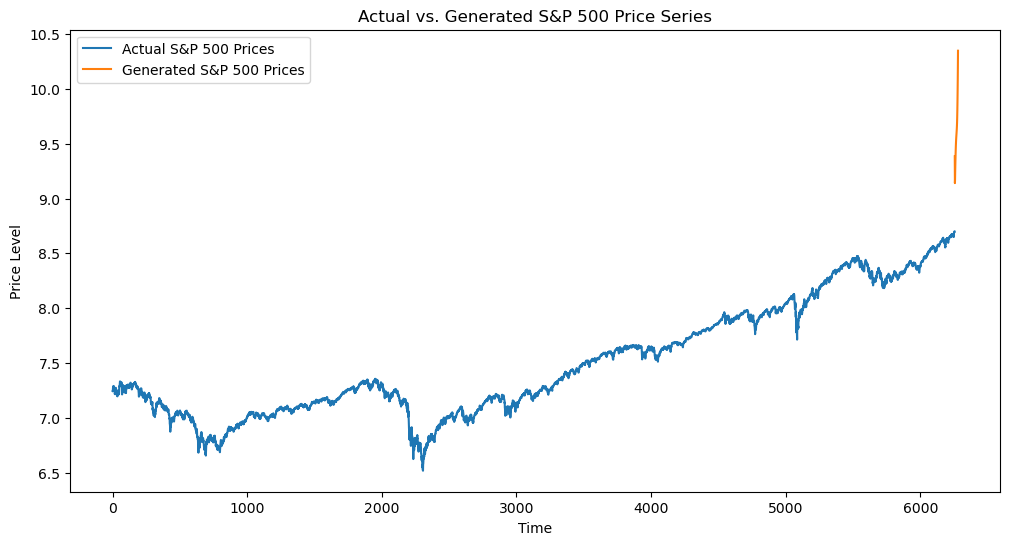

In [28]:
import matplotlib.pyplot as plt
actual_prices = sp500_df['Adj Close'].values
last_observed_price = sp500_df['Adj Close'].iloc[-1]
# Proceed with the conversion as before
cumulative_log_returns = np.cumsum(generated_returns[0, :, :])
cumulative_returns = np.exp(cumulative_log_returns)
generated_prices = last_observed_price * cumulative_returns

# Plot the actual and generated price series
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(actual_prices)), np.log(actual_prices), label='Actual S&P 500 Prices')
plt.plot(np.arange(len(actual_prices), len(actual_prices) + len(generated_prices)),
         np.log(generated_prices), label='Generated S&P 500 Prices')
plt.title('Actual vs. Generated S&P 500 Price Series')
plt.xlabel('Time')
plt.ylabel('Price Level')
plt.legend()
plt.show()

### **Run model with data**

In [ ]:
training_data, _, sp500_df = prepare_sp500_sequences(train_test_split=1.)
config = load_config_ml_col(PATH_TO_CONFIG)
train_params = {
    "epochs": 10,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "display_step": 5,
}
model = FourierFlow(
        input_dim=config.input_dim,
        output_dim=config.output_dim,
        hidden=config.hidden_dim,
        n_flows=config.n_flows,
        n_lags=config.n_lags,
        FFT=True,
        flip=True,
        normalize=False)

In [ ]:
losses = model.fit(training_data, **train_params)

Training Epochs:  10%|█         | 1/10 [00:08<01:16,  8.48s/it]

0/10 | Base Loss: 51.081 | Correlation Loss: 1.814 | ACF Loss: 0.050 | MMD Loss: 0.000 | PSD Loss: 0.007 | Total Loss: 52.952


Training Epochs:  60%|██████    | 6/10 [00:36<00:22,  5.65s/it]

5/10 | Base Loss: 0.309 | Correlation Loss: 1.814 | ACF Loss: 0.050 | MMD Loss: 0.000 | PSD Loss: 0.007 | Total Loss: 2.179


Training Epochs: 100%|██████████| 10/10 [01:00<00:00,  6.03s/it]

9/10 | Base Loss: -17.201 | Correlation Loss: 1.814 | ACF Loss: 0.050 | MMD Loss: 0.000 | PSD Loss: 0.007 | Total Loss: -15.331
Final Total Loss: -15.331

Finished Training


In [ ]:
generated_returns = to_numpy(model.sample(5))
generated_returns_re = reconstruct_sequences(generated_returns, step=20)

In [ ]:
simulated_dates = pd.date_range(start=dt.date.today(), periods=20, freq='B')
simulated_prices = np.exp(np.cumsum(generated_returns[0, :, :])) * sp500_df['Adj Close'].iloc[-1]

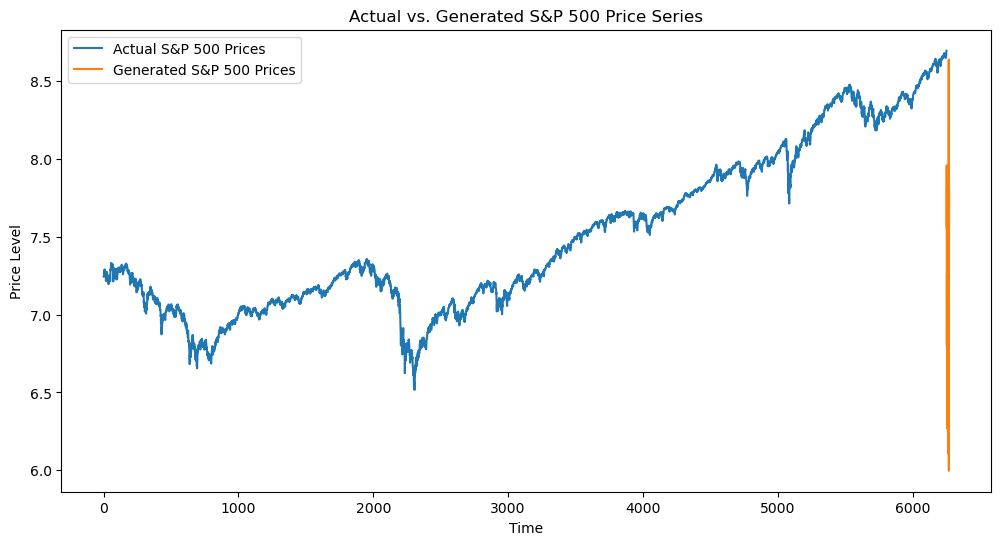

In [ ]:
import matplotlib.pyplot as plt 
actual_prices = sp500_df['Adj Close'].values
last_observed_price = sp500_df['Adj Close'].iloc[-1]
# Proceed with the conversion as before
cumulative_log_returns = np.cumsum(generated_returns[0, :, :])
cumulative_returns = np.exp(cumulative_log_returns)
generated_prices = last_observed_price * cumulative_returns

# Plot the actual and generated price series
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(actual_prices)), np.log(actual_prices), label='Actual S&P 500 Prices')
plt.plot(np.arange(len(actual_prices), len(actual_prices) + len(generated_prices)),
         np.log(generated_prices), label='Generated S&P 500 Prices')
plt.title('Actual vs. Generated S&P 500 Price Series')
plt.xlabel('Time')
plt.ylabel('Price Level')
plt.legend()
plt.show()

## **Time Series Forecasting**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import OneCycleLR
from torchdiffeq import odeint_adjoint as odeint
import copy
import matplotlib.pyplot as plt
from utils import to_numpy
from data.stock import download_stock_data, phase_space_reconstruction, preprocess_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [ ]:
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),  # 'dim' should match the number of features in your input data
            nn.Tanh(),
            nn.Linear(50, dim),
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, ode_func, num_features, num_steps = 1):
        super(NeuralODEModel, self).__init__()
        self.ode_func = ode_func
        self.linear = nn.Linear(num_features, num_steps)  # Adjust to match the number of reconstructed features

    def forward(self, x):
        ode_result = odeint(self.ode_func, x, torch.tensor([0., 1.]))[1]
        return self.linear(ode_result)
    
# Evaluation Function
def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, targets in val_loader:
            features, targets = features.to(device), targets.to(device)
            predictions = model(features)
            loss = criterion(predictions, targets)
            total_loss += loss.item()
    return total_loss / len(val_loader)

def train_neural_ode_with_validation(model, train_data, train_target,
                                     val_data, val_target, epochs, lr, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_tensor = torch.from_numpy(train_data).float()
    train_target_tensor = torch.from_numpy(train_target).float().squeeze()
    val_tensor = torch.from_numpy(val_data).float()
    val_target_tensor = torch.from_numpy(val_target).float().squeeze()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        prediction = model(train_tensor).squeeze()
        loss = criterion(prediction, train_target_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_prediction = model(val_tensor).squeeze()
            val_loss = criterion(val_prediction, val_target_tensor)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Main execution
raw_data = download_stock_data("GOOG", start="2019-01-01")
# Split the raw data into training and testing sets (80% train, 20% test)
split_idx = int(len(raw_data) * 0.8)
train_data, test_data = raw_data[:split_idx], raw_data[split_idx:]

# Preprocess the training data
train_features, train_target, scaler_features, scaler_target = preprocess_data(
    train_data, 1, 3
)

# Determine the number of features in your input data after phase space reconstruction
num_features_reconstructed = train_features.shape[1]

# Initialize your NeuralODE model with the correct number of input features
neural_ode_model = NeuralODEModel(ODEFunc(dim=num_features_reconstructed), num_features_reconstructed, num_steps=1)

# Preprocess the test data using the same scalers
test_features, test_target, _, _ = preprocess_data(
    test_data, 1, 3, scaler_features, scaler_target
)

# Ensure the target is in the correct shape for training and testing
train_target = train_target.squeeze()
test_target = test_target.squeeze()

# Number of splits for TimeSeriesSplit
n_splits = 5

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(train_features):
    # Split the data into training and validation sets for each fold
    kf_train_features, kf_val_features = train_features[train_index], train_features[test_index]
    kf_train_target, kf_val_target = train_target[train_index], train_target[test_index]

    # Train the model with validation
    trained_model = train_neural_ode_with_validation(neural_ode_model, kf_train_features, kf_train_target, kf_val_features, kf_val_target, epochs=100, lr=0.001, patience=10)

    # After training, make predictions on the test set
test_tensor = torch.from_numpy(test_features).float()
forecasted_test_scaled = trained_model(test_tensor).detach().numpy()

# The target values are already scaled, as they come from the preprocessing step
# So there's no need to scale them again, just ensure they are the correct shape
test_target_scaled = test_target.reshape(-1, 1)

# Calculate MAE and RMSE on the scaled test set predictions
mae_scaled = mean_absolute_error(test_target_scaled, forecasted_test_scaled)
rmse_scaled = np.sqrt(mean_squared_error(test_target_scaled, forecasted_test_scaled))

print(f"Scaled MAE: {mae_scaled}, Scaled RMSE: {rmse_scaled}")

Epoch 0, Train Loss: 0.05830080062150955, Val Loss: 0.02637394890189171
Epoch 10, Train Loss: 0.004668918903917074, Val Loss: 0.007140759844332933
Early stopping triggered at epoch 17
Epoch 0, Train Loss: 0.006680542603135109, Val Loss: 0.07645238935947418
Epoch 10, Train Loss: 0.0021760743111371994, Val Loss: 0.02891329675912857
Epoch 20, Train Loss: 0.0006813185173086822, Val Loss: 0.004909011535346508
Epoch 30, Train Loss: 0.0003940537280868739, Val Loss: 0.0006158098112791777
Early stopping triggered at epoch 36
Epoch 0, Train Loss: 0.00042111676884815097, Val Loss: 0.005289032589644194
Epoch 10, Train Loss: 0.0002586926275398582, Val Loss: 0.0007941831718198955
Early stopping triggered at epoch 13
Epoch 0, Train Loss: 0.0004834296414628625, Val Loss: 0.001585389138199389
Epoch 10, Train Loss: 0.00036153639666736126, Val Loss: 0.00036445268779061735
Epoch 20, Train Loss: 0.00024026869505178183, Val Loss: 0.0003092231636401266
Epoch 30, Train Loss: 0.00016418781888205558, Val Loss: 

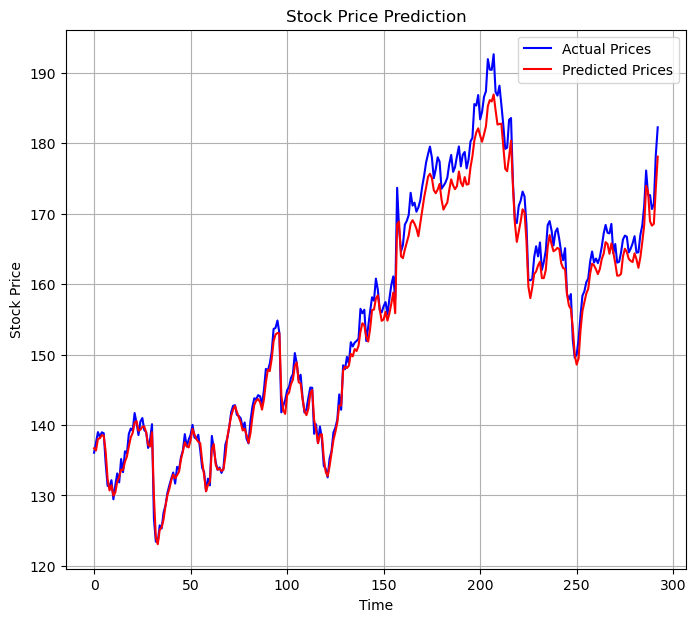

In [ ]:
predicted_test_unscaled = scaler_target.inverse_transform(forecasted_test_scaled)
actual_test_unscaled = scaler_target.inverse_transform(test_target_scaled.reshape(-1, 1))

# Plotting the results for the test set
plt.figure(figsize=(8, 7))
plt.plot(actual_test_unscaled, label='Actual Prices', color='blue')
plt.plot(predicted_test_unscaled, label='Predicted Prices', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def forecast_h_steps(model, last_known_data, h_steps, delay, embedding_dim, scaler_features, scaler_target):
    """
    Generate h-step ahead forecasts using the trained Neural ODE model with phase space reconstruction
    
    Args:
        model: Trained NeuralODEModel
        last_known_data: Last known data points (original scale, should include enough points for reconstruction)
        h_steps: Number of steps to forecast ahead
        delay: Delay parameter for phase space reconstruction
        embedding_dim: Embedding dimension for phase space reconstruction
        scaler_features: Fitted feature scaler
        scaler_target: Fitted target scaler
    
    Returns:
        numpy array of forecasted values (in original scale)
    """
    model.eval()
    forecasts = []
    
    # Initialize working data (will be updated with each forecast)
    working_data = last_known_data.copy()
    
    with torch.no_grad():
        for step in range(h_steps):
            # Scale the working data
            features = working_data.loc[:, working_data.columns != 'Close']
            scaled_features = scaler_features.transform(features)
            
            # Apply phase space reconstruction
            reconstructed_features = phase_space_reconstruction(
                scaled_features, 
                delay, 
                embedding_dim
            )
            
            # Get the last reconstructed vector
            current_features = reconstructed_features[-1:]
            
            # Convert to tensor and get prediction
            current_features_tensor = torch.from_numpy(current_features).float()
            next_pred = model(current_features_tensor)
            
            # Convert prediction to original scale
            next_pred_original = scaler_target.inverse_transform(
                next_pred.numpy().reshape(-1, 1)
            )
            
            forecasts.append(next_pred_original[0][0])
            
            # Update working data for next iteration
            # Create new row with predicted Adj Close
            new_row = working_data.iloc[-1:].copy()
            new_row['Close'] = next_pred_original[0][0]
            # Append to working data
            working_data = pd.concat([working_data, new_row])
            working_data = working_data.iloc[1:]  # Remove oldest row
    
    return np.array(forecasts)

def train_and_forecast(raw_data, delay, embedding_dim, h_steps, train_size=0.8):
    """
    Train the Neural ODE model on all training data and generate h-step ahead forecasts
    
    Args:
        raw_data: Original time series data (pandas DataFrame)
        delay: Delay parameter for phase space reconstruction
        embedding_dim: Embedding dimension for phase space reconstruction
        h_steps: Number of steps to forecast ahead
        train_size: Proportion of data to use for training
    
    Returns:
        dict containing training metrics and forecasts
    """
    # Split data into training and test sets
    split_idx = int(len(raw_data) * train_size)
    train_data = raw_data[:split_idx]
    test_data = raw_data[split_idx:]
    
    # Preprocess training data
    train_features, train_target, scaler_features, scaler_target = preprocess_data(
        train_data, delay, embedding_dim
    )

    # Preprocess the test data using the same scalers
    test_features, test_target, _, _ = preprocess_data(
        test_data, delay, embedding_dim, scaler_features, scaler_target
    )

    # Ensure the target is in the correct shape for training and testing
    train_target = train_target.squeeze()
    test_target = test_target.squeeze()

    # Number of splits for TimeSeriesSplit
    n_splits = 5

    # Initialize TimeSeriesSplit with the desired number of splits
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize model
    num_features_reconstructed = train_features.shape[1]
    neural_ode_model = NeuralODEModel(
        ODEFunc(dim=num_features_reconstructed), 
        num_features_reconstructed
    )
    
    for train_index, test_index in tscv.split(train_features):
        # Split the data into training and validation sets for each fold
        kf_train_features, kf_val_features = train_features[train_index], train_features[test_index]
        kf_train_target, kf_val_target = train_target[train_index], train_target[test_index]

        # Train the model with validation
        trained_model = train_neural_ode_with_validation(neural_ode_model, 
                                                         kf_train_features, kf_train_target, 
                                                         kf_val_features, kf_val_target, 
                                                         epochs=100, lr=0.001, patience=10)
           
    # Get the last portion of training data needed for forecasting
    # We need enough data points for phase space reconstruction
    required_points = delay * (embedding_dim - 1) + 1
    last_known_data = raw_data.iloc[-(required_points):]
    
    # Generate h-step ahead forecasts
    forecasts = forecast_h_steps(
        trained_model,
        last_known_data,
        h_steps,
        delay,
        embedding_dim,
        scaler_features,
        scaler_target
    )
    
    # Calculate error metrics on training set
    train_predictions = trained_model(
        torch.from_numpy(train_features).float()
    ).detach().numpy()
    train_predictions = scaler_target.inverse_transform(train_predictions.reshape(-1, 1))
    train_target_original = scaler_target.inverse_transform(train_target.reshape(-1, 1))
    
    train_mae = mean_absolute_error(train_target_original, train_predictions)
    train_rmse = np.sqrt(mean_squared_error(train_target_original, train_predictions))
    
    return {
        'forecasts': forecasts,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'model': trained_model,
        'scaler_features': scaler_features,
        'scaler_target': scaler_target
    }

In [ ]:
# Download and prepare data
raw_data = download_stock_data("AAPL", start="2015-01-01")

# Train model and generate forecasts
results = train_and_forecast(
    raw_data=raw_data,
    delay=1,
    embedding_dim=3,
    h_steps=5,
    train_size=0.8
)

# Access results
forecasts = results['forecasts']
print(f"Training MAE: {results['train_mae']:.4f}")
print(f"Training RMSE: {results['train_rmse']:.4f}")
print(f"5-step ahead forecasts:\n{forecasts}")

Epoch 0, Train Loss: 0.0009641640353947878, Val Loss: 0.0031457156874239445
Epoch 10, Train Loss: 0.0005435849889181554, Val Loss: 0.00206934311427176
Epoch 20, Train Loss: 0.00033263114164583385, Val Loss: 0.001035791588947177
Epoch 30, Train Loss: 0.0001610015460755676, Val Loss: 0.0004777426947839558
Epoch 40, Train Loss: 5.361040530260652e-05, Val Loss: 0.00013989253784529865
Epoch 50, Train Loss: 9.12821815290954e-06, Val Loss: 7.1525550993101206e-06
Epoch 60, Train Loss: 6.756419224984711e-06, Val Loss: 1.9464989236439578e-05
Early stopping triggered at epoch 61
Epoch 0, Train Loss: 5.767162747360999e-06, Val Loss: 0.0006152780842967331
Epoch 10, Train Loss: 0.00011215147242182866, Val Loss: 0.0001246998435817659
Epoch 20, Train Loss: 3.031924097740557e-05, Val Loss: 8.865701238391921e-05
Early stopping triggered at epoch 22
Epoch 0, Train Loss: 1.431491818948416e-05, Val Loss: 0.0008961738203652203
Epoch 10, Train Loss: 8.83255124790594e-05, Val Loss: 0.00014798209303990006
Epoc

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
    
def plot_forecasts_and_history(raw_data, train_data, model, forecasts, last_n_days, 
                             scaler_features, scaler_target, delay, embedding_dim):
    """
    Plot the last n days of training data, in-sample predictions, and h-step ahead forecasts
    
    Args:
        raw_data: Complete raw data DataFrame
        train_data: Training data DataFrame
        model: Trained Neural ODE model
        forecasts: Array of h-step ahead forecasts
        last_n_days: Number of last days to show from training data
        scaler_features, scaler_target: Fitted scalers
        delay, embedding_dim: Parameters used for phase space reconstruction
    """

    # Get the dates for the entire dataset
    dates = raw_data.index
    
    # Calculate in-sample predictions for training data
    train_features, train_target, _, _ = preprocess_data(
        train_data, delay, embedding_dim, scaler_features, scaler_target
    )
    
    model.eval()
    with torch.no_grad():
        train_pred = model(torch.from_numpy(train_features).float())
        train_pred = scaler_target.inverse_transform(train_pred.numpy().reshape(-1, 1))
    
    # Get the last n days of training data and their corresponding predictions
    last_n_train_data = raw_data['Close'][-last_n_days:]
    last_n_train_dates = dates[-last_n_days:]
    
    # Find the corresponding in-sample predictions for the last n days
    # Account for the delay in predictions due to phase space reconstruction
    offset = delay * (embedding_dim - 1)
    last_n_pred_indices = slice(-last_n_days - offset, None)
    last_n_train_pred = train_pred[last_n_pred_indices]
    last_n_pred_dates = dates[offset:][last_n_pred_indices]
    
    # Generate forecast dates
    last_date = dates[-1]
    forecast_dates = [last_date + timedelta(days=i+1) for i in range(len(forecasts))]
    
    # Create the plot
    plt.figure(figsize=(15, 7))
    
    # Plot training data
    plt.plot(last_n_train_dates, last_n_train_data, 
             label='Historical Data', color='blue', linewidth=2)
    
    # Plot in-sample predictions
    plt.plot(last_n_pred_dates, last_n_train_pred, 
             label='In-sample Predictions', color='green', linestyle='--', alpha=0.7)
    
    # Plot forecasts
    plt.plot(forecast_dates, forecasts, 
             label='Forecasts', color='red', linestyle='-.')
    
    # Add vertical line at train/forecast boundary
    plt.axvline(x=last_date, color='gray', linestyle=':', label='Forecast Start')
    
    # Customize the plot
    plt.title('Historical Data, In-sample Predictions, and Forecasts', pad=20)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

# # Modified train_and_forecast function to include visualization
# def train_and_forecast_with_viz(raw_data, delay, embedding_dim, h_steps, last_n_days=30, train_size=0.8):
#     """
#     Train model, generate forecasts, and create visualization
    
#     Args:
#         raw_data: Original time series data (pandas DataFrame)
#         delay: Delay parameter for phase space reconstruction
#         embedding_dim: Embedding dimension for phase space reconstruction
#         h_steps: Number of steps to forecast ahead
#         last_n_days: Number of recent days to show in visualization
#         train_size: Proportion of data to use for training
    
#     Returns:
#         dict containing training metrics, forecasts, and visualization
#     """
#     # Get training results
#     results = train_and_forecast(raw_data, delay, embedding_dim, h_steps, train_size)
    
#     # Calculate split index and get training data
#     split_idx = int(len(raw_data) * train_size)
#     train_data = raw_data[:split_idx]
    
#     # Create visualization
#     fig = plot_forecasts_and_history(
#         raw_data=raw_data,
#         train_data=train_data,
#         model=results['model'],
#         forecasts=results['forecasts'],
#         last_n_days=last_n_days,
#         scaler_features=results['scaler_features'],
#         scaler_target=results['scaler_target'],
#         delay=delay,
#         embedding_dim=embedding_dim
#     )
    
#     # Add visualization to results
#     results['visualization'] = fig
    
#     return results

# Example usage:

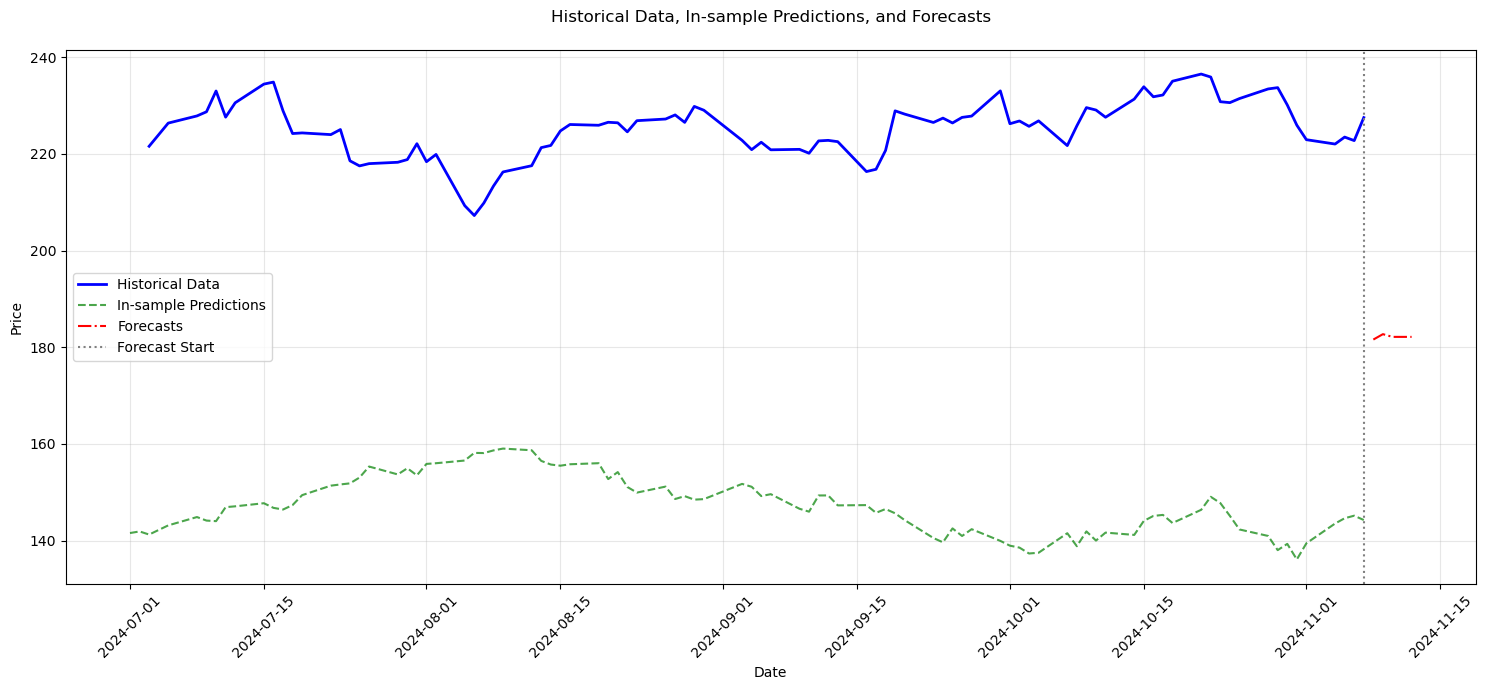

In [ ]:
fig = plot_forecasts_and_history(
        raw_data=raw_data,
        train_data=raw_data[:int(len(raw_data) * 0.8)],
        model=results['model'],
        forecasts=results['forecasts'],
        last_n_days=90,
        scaler_features=results['scaler_features'],
        scaler_target=results['scaler_target'],
        delay=1,
        embedding_dim=3
    )

In [ ]:
results

{'forecasts': array([214.29758, 213.54526, 216.04443, 219.5805 , 220.61398],
       dtype=float32),
 'train_mae': 4.875963127633515,
 'train_rmse': 6.325300479718804,
 'model': NeuralODEModel(
   (ode_func): ODEFunc(
     (net): Sequential(
       (0): Linear(in_features=30, out_features=50, bias=True)
       (1): Tanh()
       (2): Linear(in_features=50, out_features=30, bias=True)
     )
   )
   (linear): Linear(in_features=30, out_features=1, bias=True)
 ),
 'scaler_features': MinMaxScaler(),
 'scaler_target': MinMaxScaler()}

## **Dashboard**

In [ ]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

In [ ]:
df = pd.read_csv("data\\final_dataset.csv", parse_dates = ['Date'])

### **Dashboard 1**

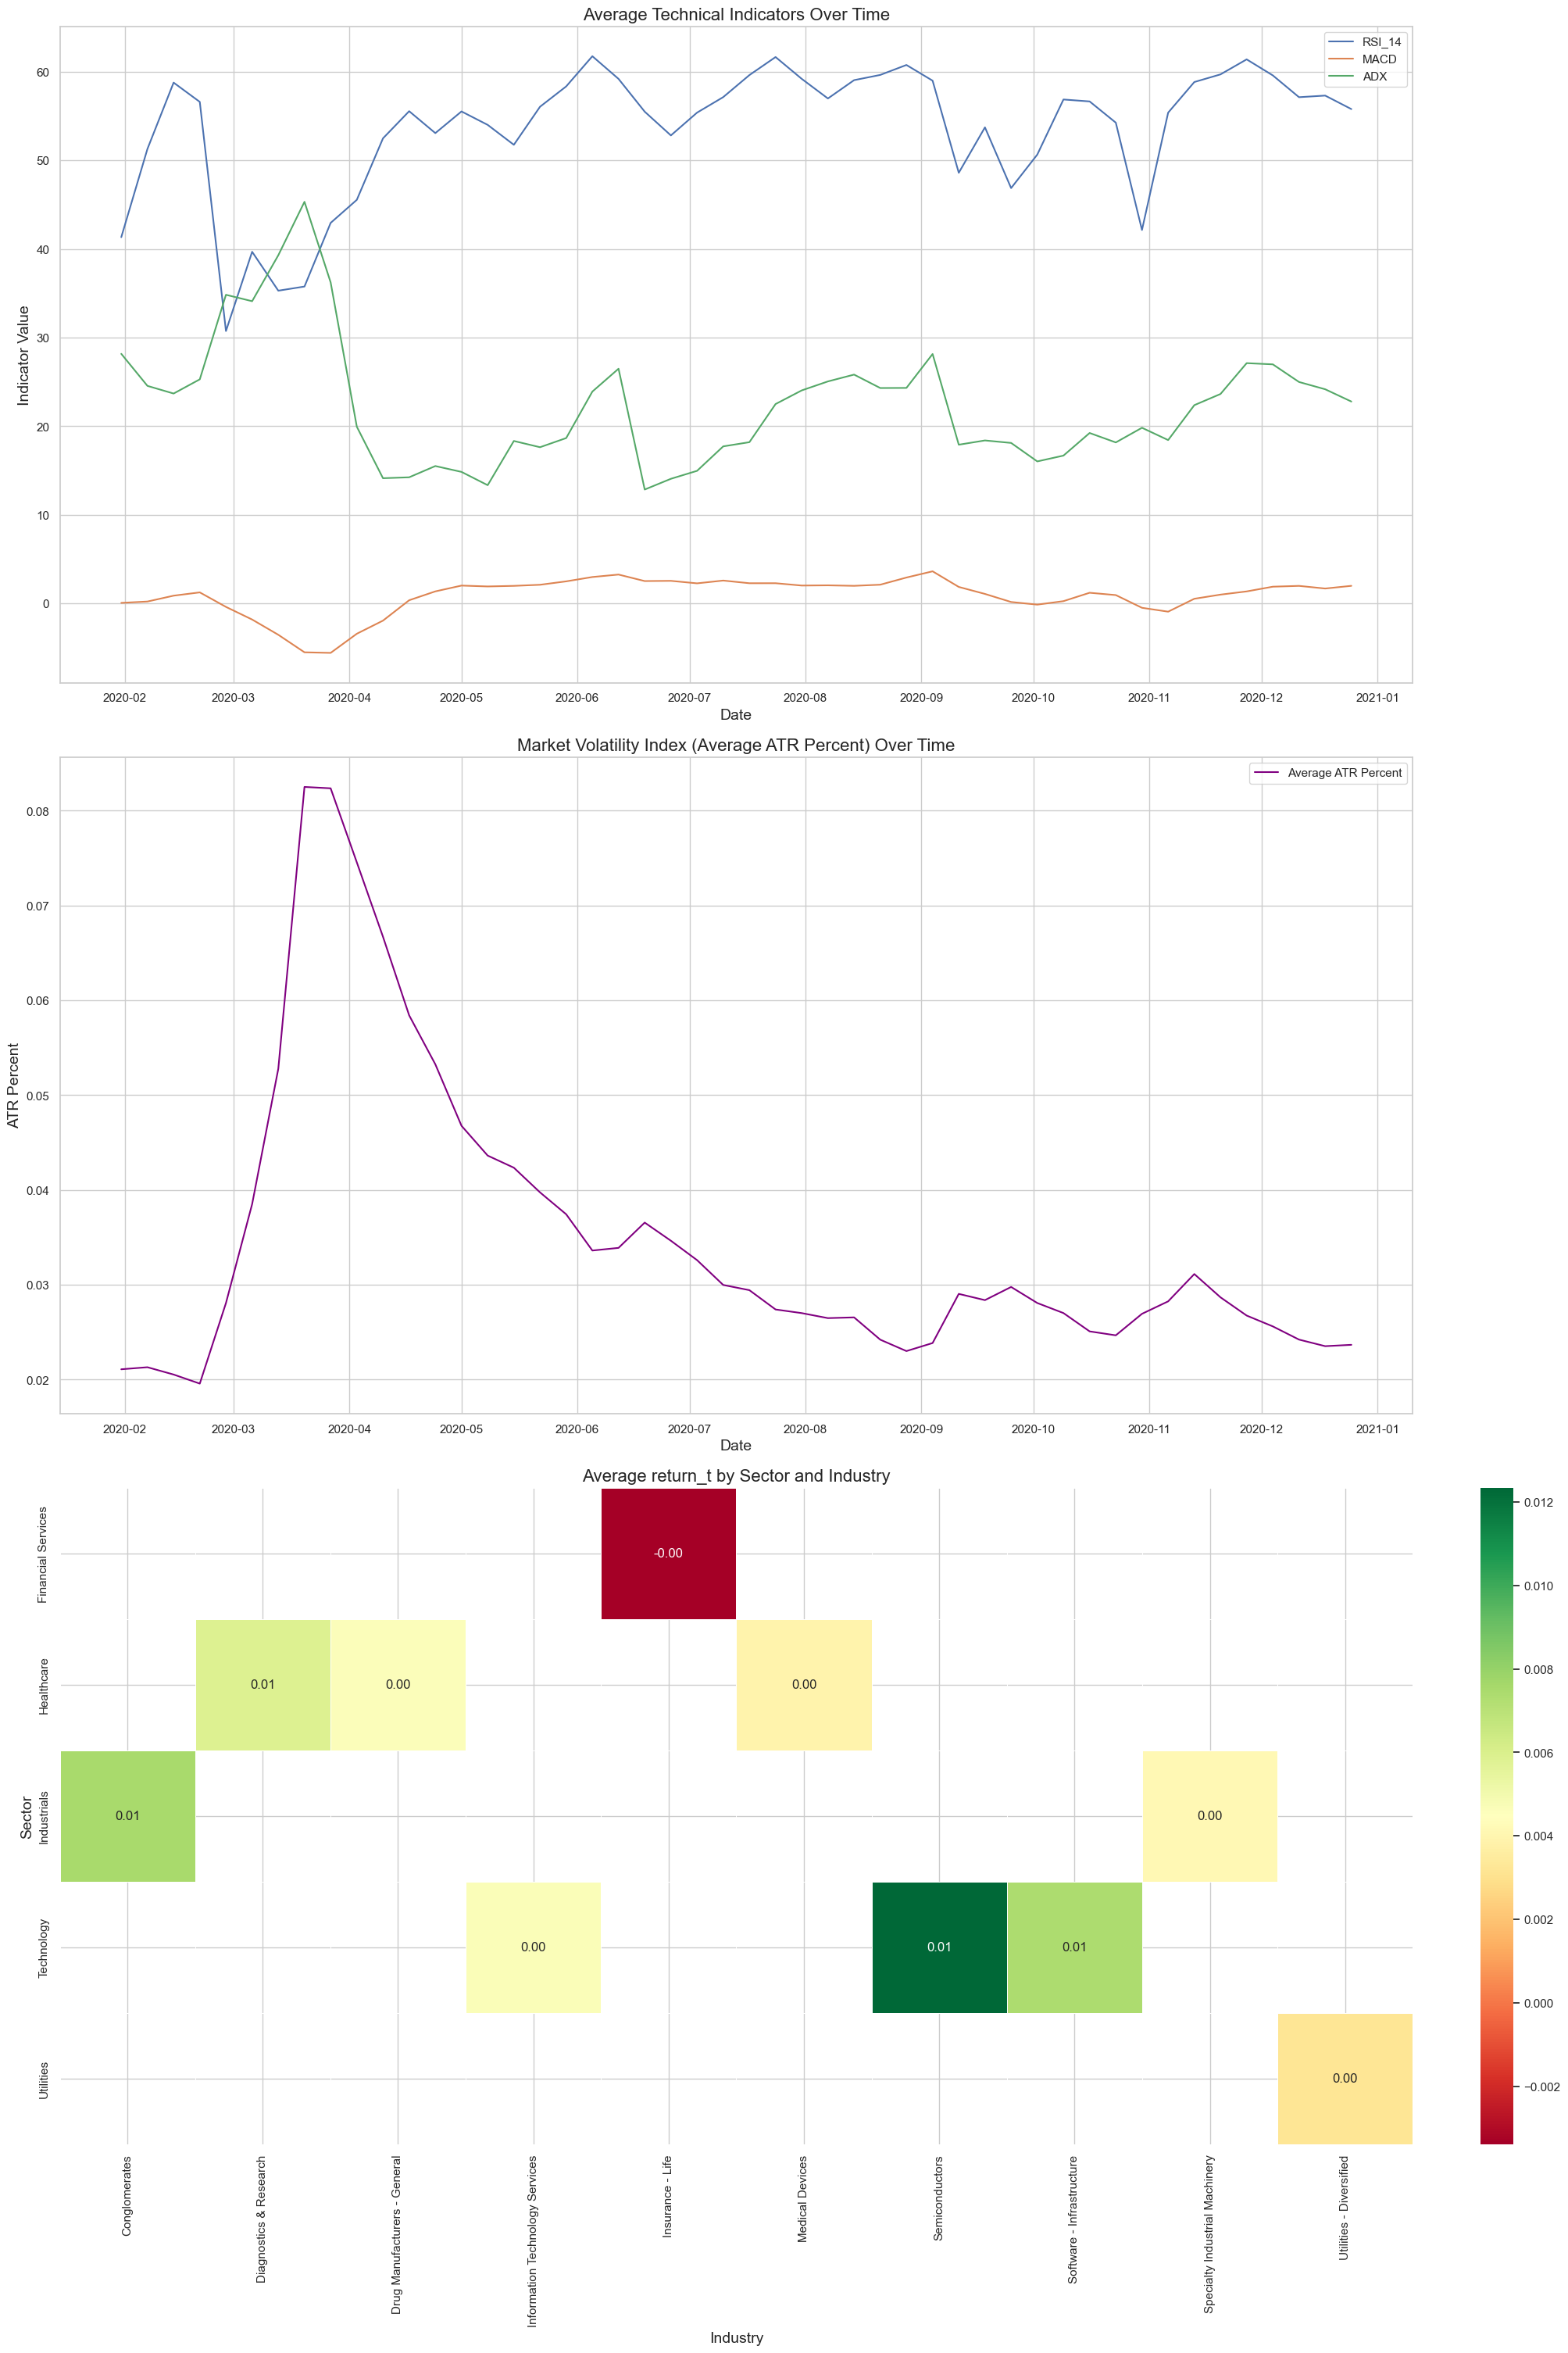

In [ ]:
technical_indicators = ['rsi_14', 'macd', 'adx']
avg_technical = df.groupby('Date')[technical_indicators].mean().reset_index()

# Group by Date and calculate the mean of 'atr_percent'
avg_volatility = df.groupby('Date')['atr_percent'].mean().reset_index()


return_metric = 'return_t'

# Group by Sector and Industry, then calculate the mean return
sector_performance = df.groupby(['sector', 'industry'])[return_metric].mean().reset_index()

# Pivot the data to create a matrix suitable for a heatmap
performance_pivot = sector_performance.pivot(index='sector', columns='industry', values=return_metric)


# Initialize the figure
fig = plt.figure(constrained_layout=True, figsize=(20, 30))
gs = fig.add_gridspec(3, 1)  # 3 rows: Technical Indicators, Volatility Index, Heatmap

# 1. Average Technical Indicators Over Time
ax1 = fig.add_subplot(gs[0, 0])
for indicator in technical_indicators:
    sns.lineplot(data=avg_technical, x='Date', y=indicator, label=indicator.upper(), ax=ax1)
ax1.set_title('Average Technical Indicators Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Indicator Value')
ax1.legend()
ax1.grid(True)

# 2. Market Volatility Index
ax2 = fig.add_subplot(gs[1, 0])
sns.lineplot(data=avg_volatility, x='Date', y='atr_percent', color='purple', label='Average ATR Percent', ax=ax2)
ax2.set_title('Market Volatility Index (Average ATR Percent) Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('ATR Percent')
ax2.legend()
ax2.grid(True)

# 3. Sector Performance Heatmap
ax3 = fig.add_subplot(gs[2, 0])
sns.heatmap(performance_pivot, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=ax3)
ax3.set_title(f'Average {return_metric} by Sector and Industry')
ax3.set_xlabel('Industry')
ax3.set_ylabel('Sector')

plt.show()

### **Dashboard 2**

C:\Users\ACER\AppData\Local\Temp\ipykernel_11308\2583307912.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ACER\AppData\Local\Temp\ipykernel_11308\2583307912.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


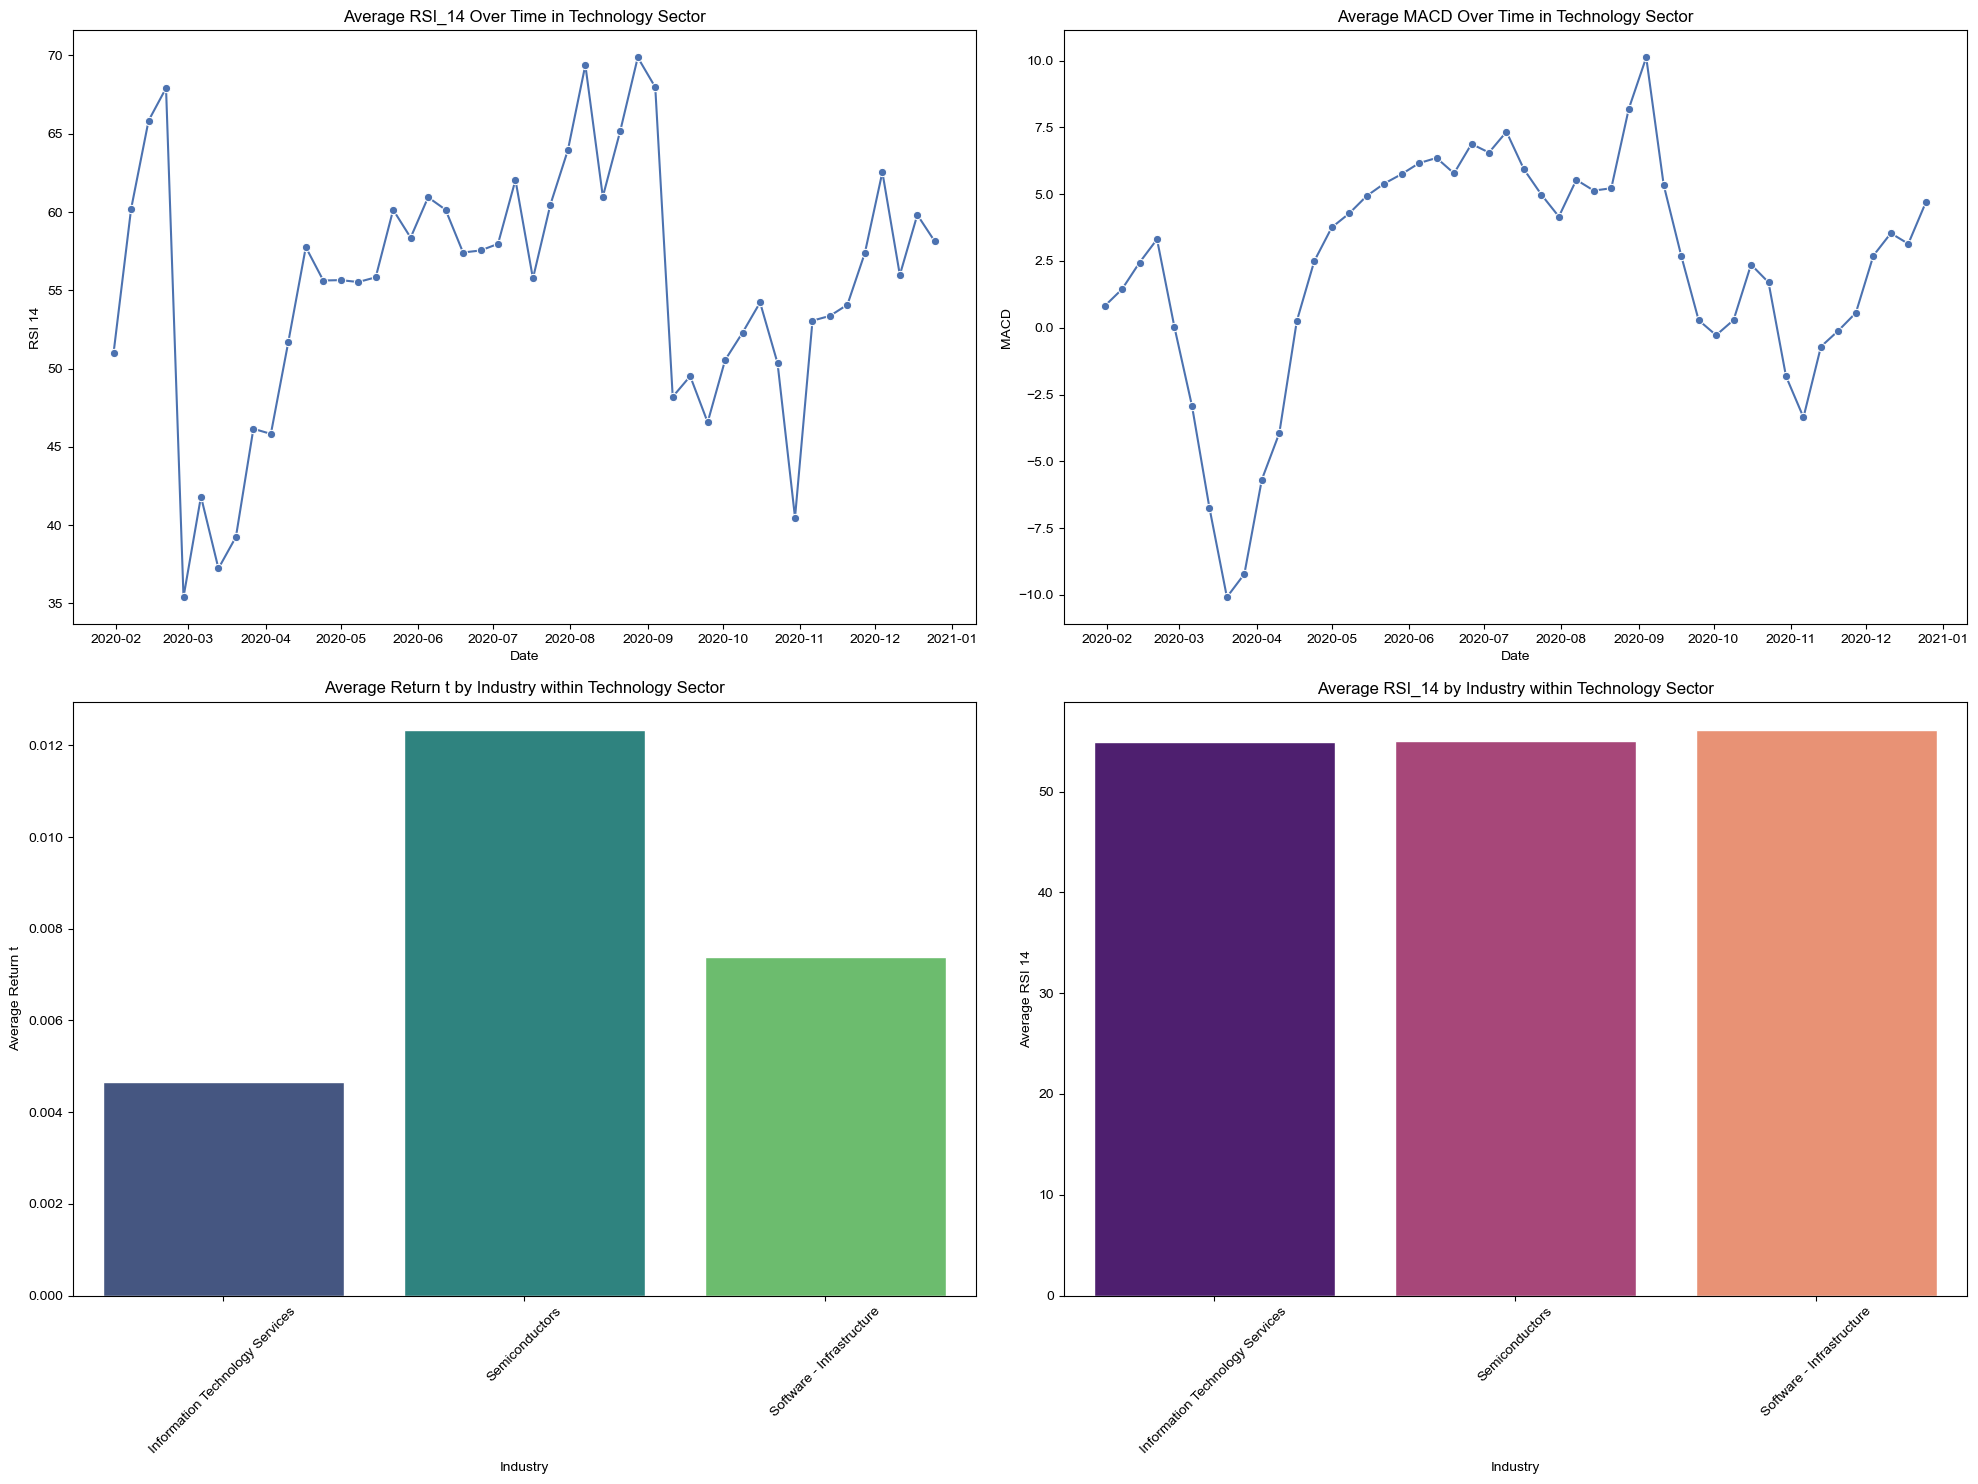

In [ ]:
# Initialize the figure
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Define the technical indicators to average
technical_indicators = ['rsi_14', 'macd', 'adx']

# Group by Date and Sector, then calculate the mean of each technical indicator
avg_technical_sector = df.groupby(['Date', 'sector'])[technical_indicators].mean().reset_index()

# Define the sector of interest
selected_sector = 'Technology'  # You can change this to any sector in your dataset

# Define the metrics to compare
metrics = ['return_t', 'rsi_14', 'macd', 'adx']

# Filter data for the selected sector
sector_data = df[df['sector'] == selected_sector]

# Group by Industry and calculate the mean of the metrics
avg_metrics_industry = sector_data.groupby('industry')[metrics].mean().reset_index()

# 1. Sector-wise RSI Trends
sns.lineplot(
    data=avg_technical_sector[avg_technical_sector['sector'] == selected_sector],
    x='Date',
    y='rsi_14',
    hue='sector',
    marker='o',
    ax=axes[0, 0]
)
axes[0, 0].set_title(f'Average RSI_14 Over Time in {selected_sector} Sector')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('RSI 14')
axes[0, 0].legend().set_visible(False)

# 2. Sector-wise MACD Trends
sns.lineplot(
    data=avg_technical_sector[avg_technical_sector['sector'] == selected_sector],
    x='Date',
    y='macd',
    hue='sector',
    marker='o',
    ax=axes[0, 1]
)
axes[0, 1].set_title(f'Average MACD Over Time in {selected_sector} Sector')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('MACD')
axes[0, 1].legend().set_visible(False)

# 3. Industry Return Comparison
sns.barplot(
    data=avg_metrics_industry,
    x='industry',
    y='return_t',
    palette='viridis',
    ax=axes[1, 0]
)
axes[1, 0].set_title(f'Average Return t by Industry within {selected_sector} Sector')
axes[1, 0].set_xlabel('Industry')
axes[1, 0].set_ylabel('Average Return t')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Industry RSI Comparison
sns.barplot(
    data=avg_metrics_industry,
    x='industry',
    y='rsi_14',
    palette='magma',
    ax=axes[1, 1]
)
axes[1, 1].set_title(f'Average RSI_14 by Industry within {selected_sector} Sector')
axes[1, 1].set_xlabel('Industry')
axes[1, 1].set_ylabel('Average RSI 14')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### **Dashboard 3**

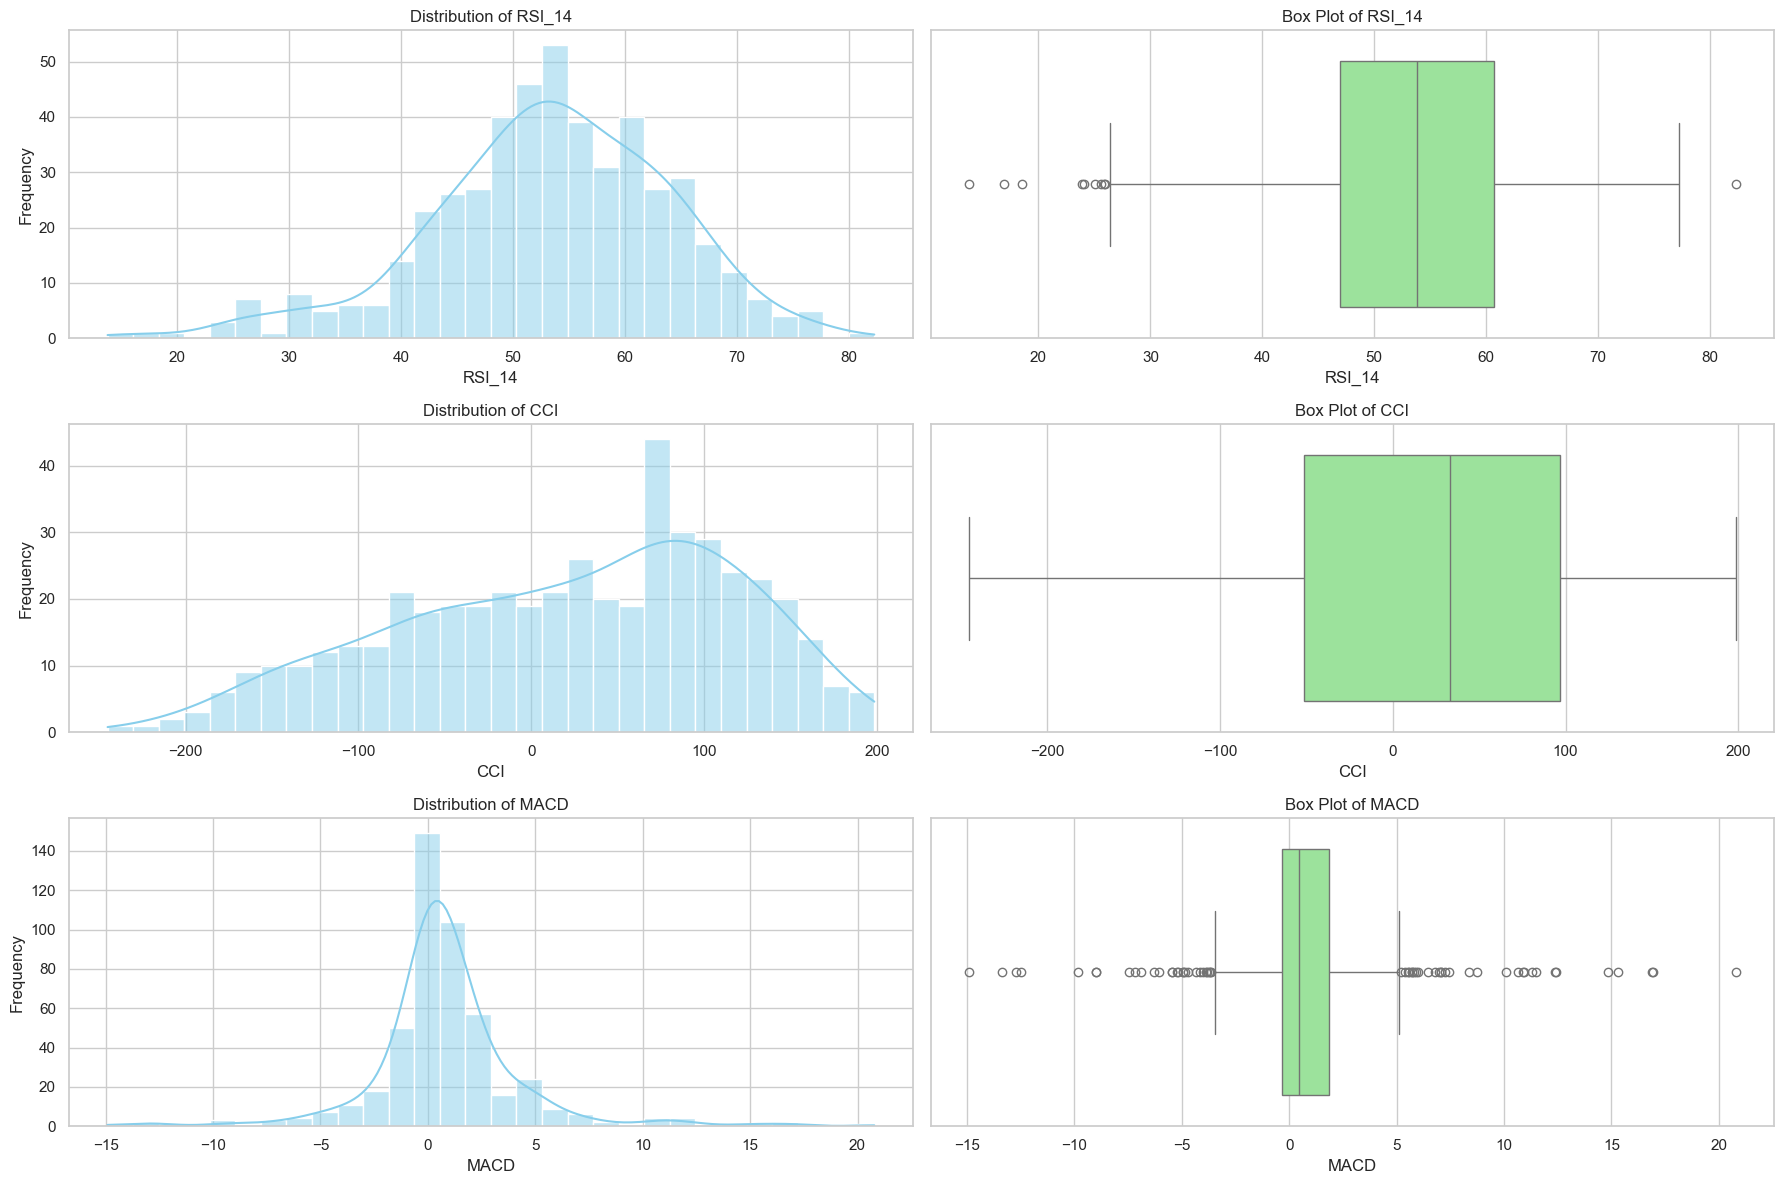


Overbought/Oversold Stocks Summary:
                 Condition  Number of Stocks  Percentage
0    Overbought (RSI > 70)                20    4.166667
1      Oversold (RSI < 30)                14    2.916667
2  Neutral (30 ≤ RSI ≤ 70)               446   92.916667


C:\Users\ACER\AppData\Local\Temp\ipykernel_11308\3707788954.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Condition', y='Number of Stocks', data=summary_df, palette=colors)


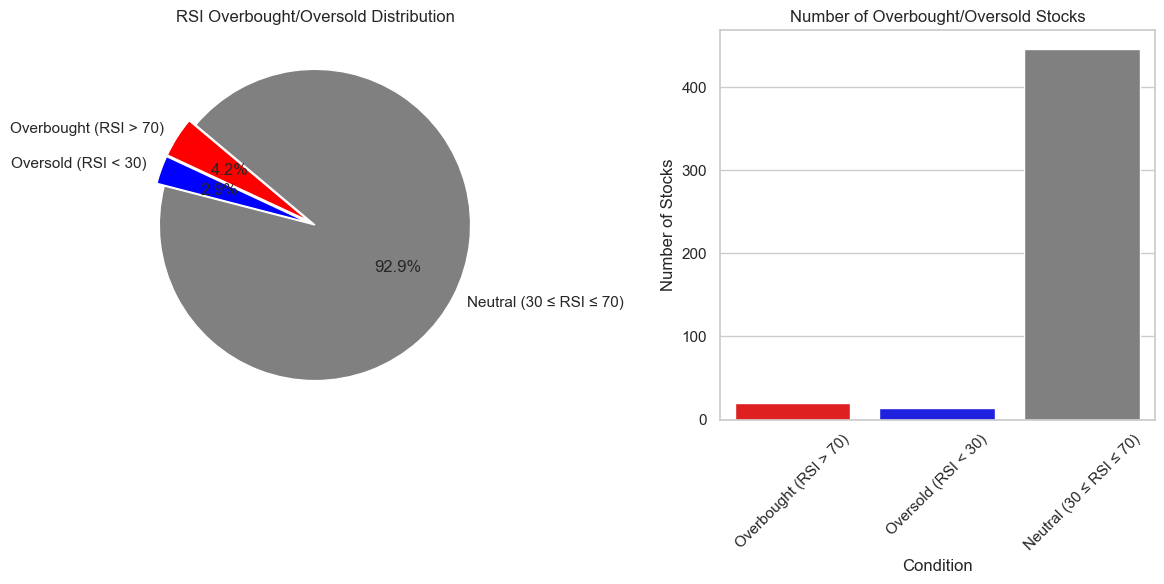

C:\Users\ACER\AppData\Local\Temp\ipykernel_11308\3707788954.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Condition', y='Number of Stocks', data=summary_df, palette=colors, ax=ax_bar)
C:\Users\ACER\AppData\Local\Temp\ipykernel_11308\3707788954.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45)


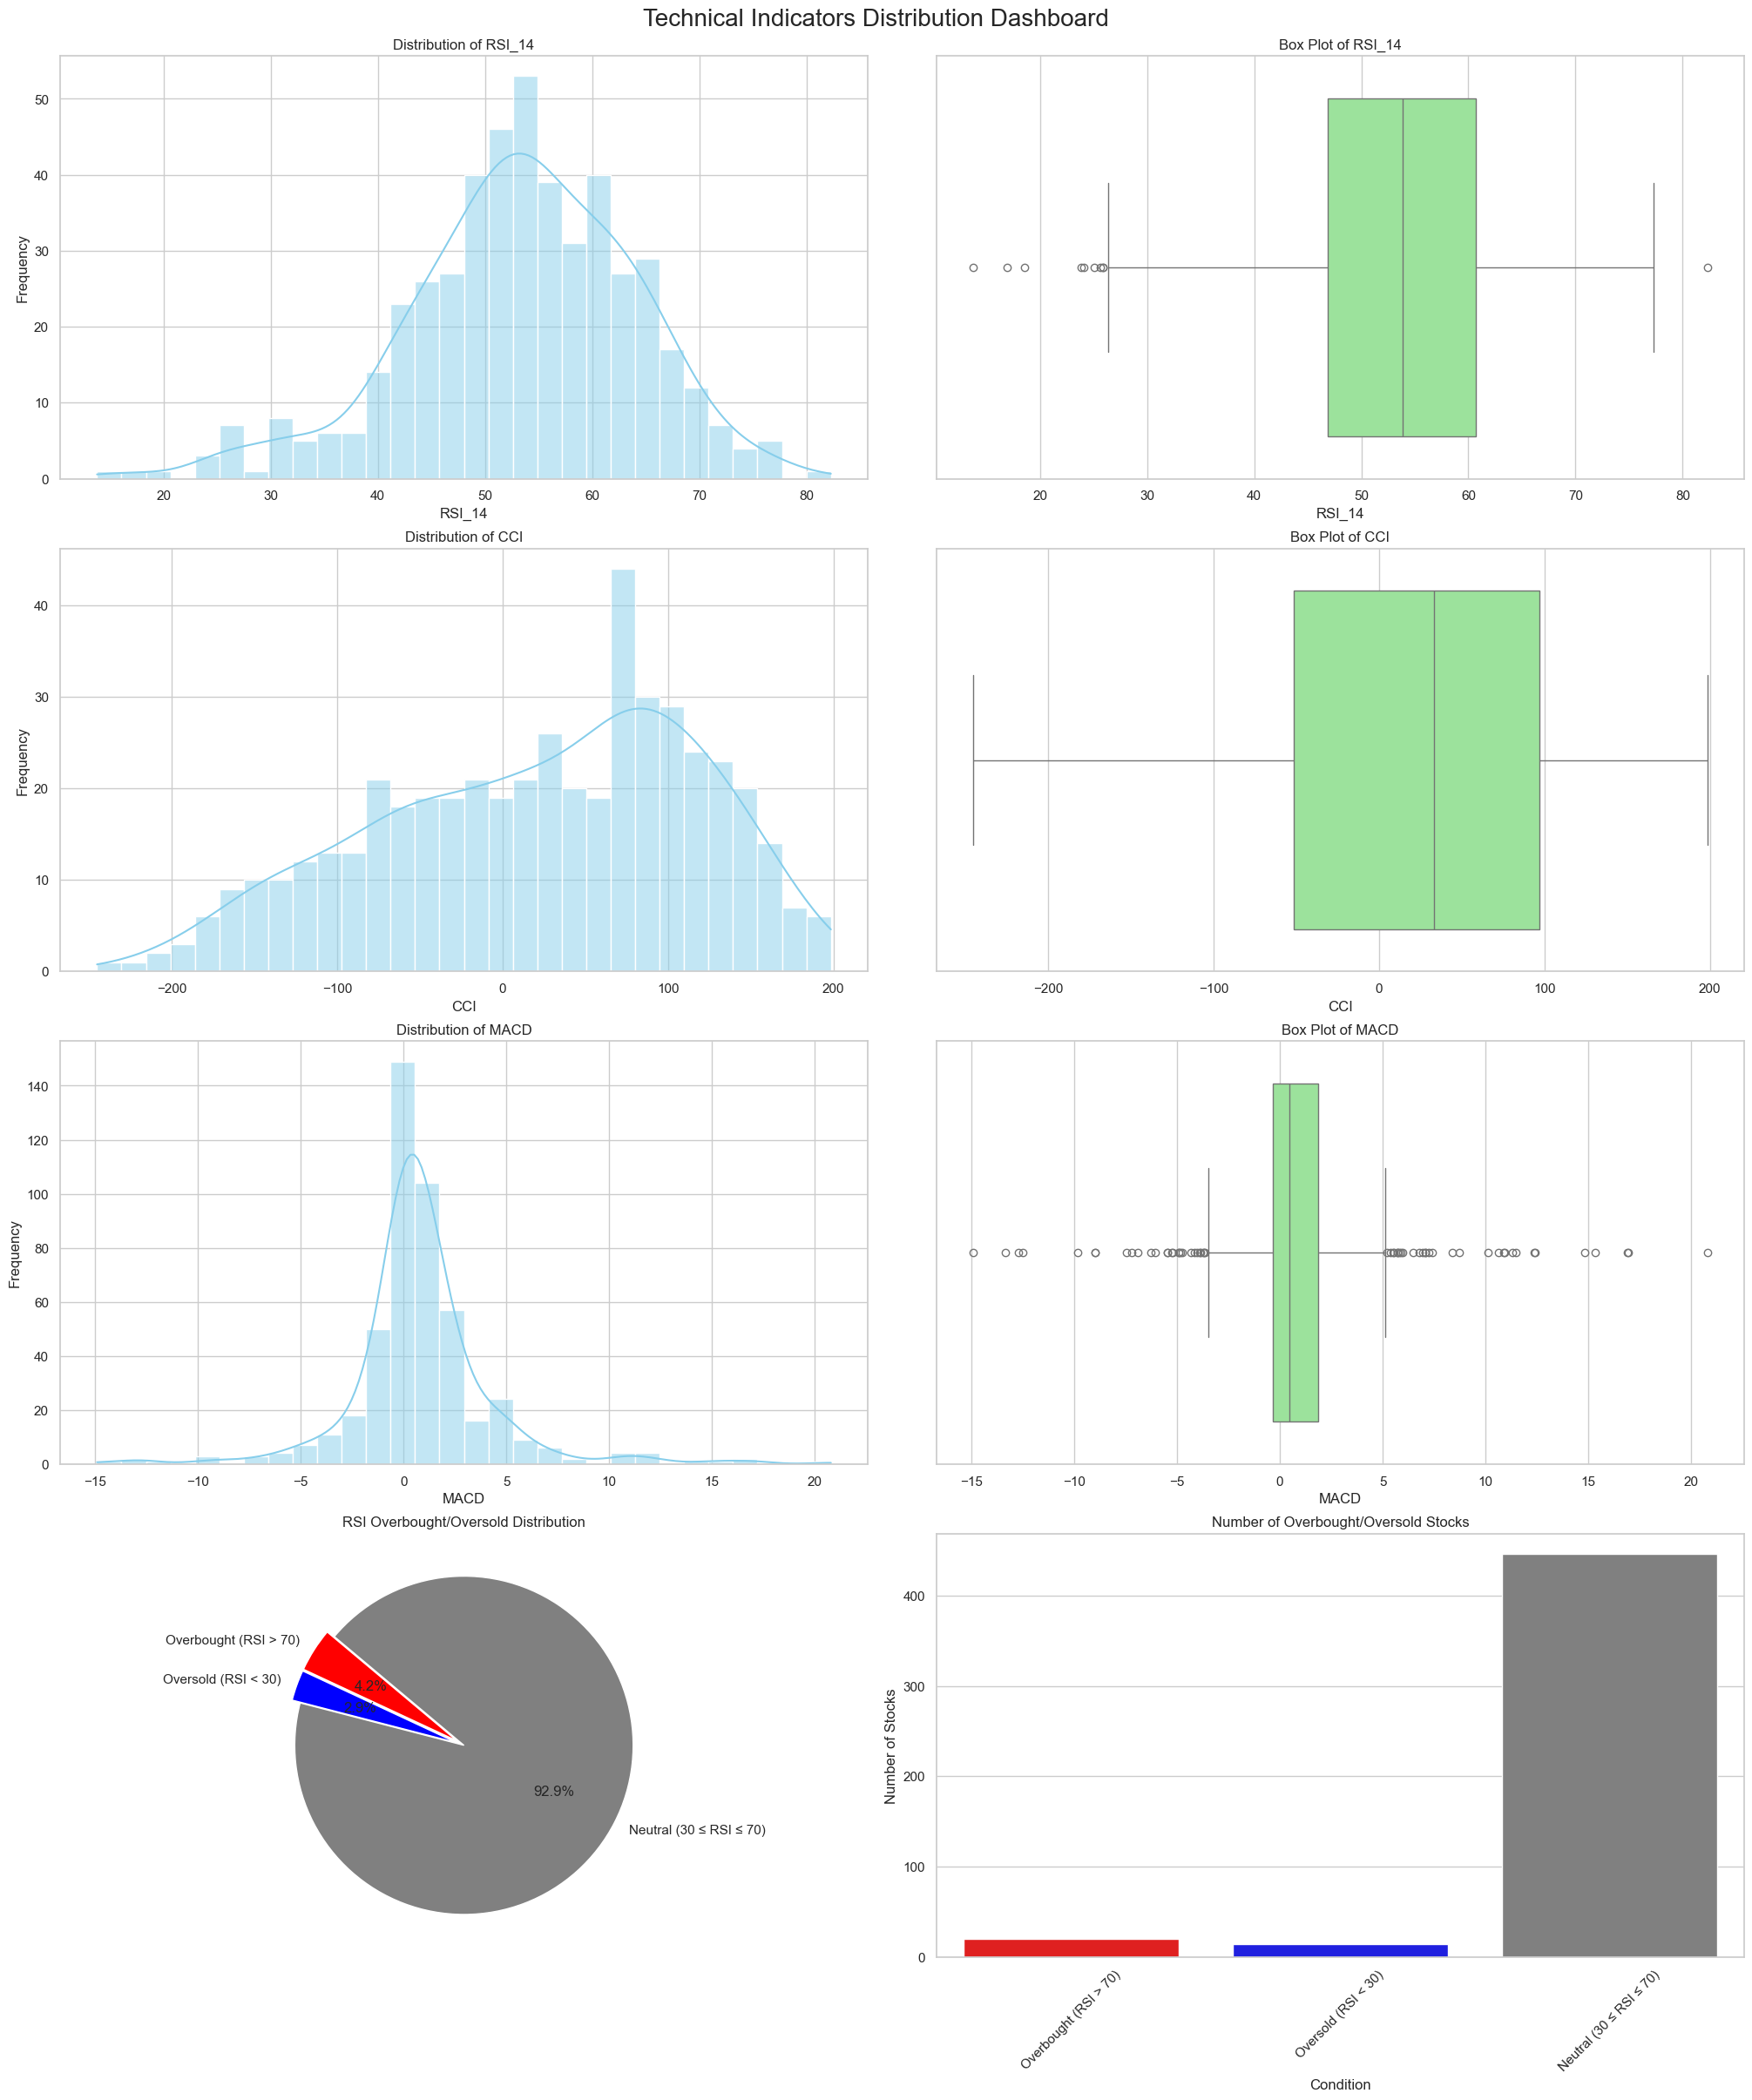

In [ ]:
# ---------------------------
# 2. Indicator Histograms and Box Plots
# ---------------------------

# Define the technical indicators to analyze
technical_indicators = ['rsi_14', 'cci', 'macd']

# ---------------------------
# 3. Overbought/Oversold Stocks Summary
# ---------------------------

# Define thresholds for RSI
overbought_threshold = 70
oversold_threshold = 30

# Calculate the number and percentage of overbought and oversold stocks
total_stocks = len(df)
overbought = len(df[df['rsi_14'] > overbought_threshold])
oversold = len(df[df['rsi_14'] < oversold_threshold])
neutral = total_stocks - overbought - oversold

# Create a summary DataFrame
summary_data = {
    'Condition': ['Overbought (RSI > 70)', 'Oversold (RSI < 30)', 'Neutral (30 ≤ RSI ≤ 70)'],
    'Number of Stocks': [overbought, oversold, neutral],
    'Percentage': [overbought / total_stocks * 100,
                   oversold / total_stocks * 100,
                   neutral / total_stocks * 100]
}

summary_df = pd.DataFrame(summary_data)

# Display the summary table
print("\nOverbought/Oversold Stocks Summary:")
print(summary_df)

# ---------------------------
# 4. Plotting Overbought/Oversold Summary
# ---------------------------
colors = ['red', 'blue', 'grey']


# Initialize the figure
fig = plt.figure(constrained_layout=True, figsize=(20, 24))
gs = fig.add_gridspec(4, 2)

# 5.1. Indicator Histograms and Box Plots
for i, indicator in enumerate(technical_indicators):
    # Histogram
    ax_hist = fig.add_subplot(gs[i, 0])
    sns.histplot(df[indicator], bins=30, kde=True, color='skyblue', ax=ax_hist)
    ax_hist.set_title(f'Distribution of {indicator.upper()}')
    ax_hist.set_xlabel(indicator.upper())
    ax_hist.set_ylabel('Frequency')
    
    # Box Plot
    ax_box = fig.add_subplot(gs[i, 1])
    sns.boxplot(x=df[indicator], color='lightgreen', ax=ax_box)
    ax_box.set_title(f'Box Plot of {indicator.upper()}')
    ax_box.set_xlabel(indicator.upper())

# 5.2. Overbought/Oversold Summary - Pie Chart
ax_pie = fig.add_subplot(gs[3, 0])
ax_pie.pie(summary_df['Percentage'], labels=summary_df['Condition'], autopct='%1.1f%%',
           startangle=140, colors=colors, explode=(0.05, 0.05, 0))
ax_pie.set_title('RSI Overbought/Oversold Distribution')

# 5.3. Overbought/Oversold Summary - Bar Chart
ax_bar = fig.add_subplot(gs[3, 1])
sns.barplot(x='Condition', y='Number of Stocks', data=summary_df, palette=colors, ax=ax_bar)
ax_bar.set_title('Number of Overbought/Oversold Stocks')
ax_bar.set_xlabel('Condition')
ax_bar.set_ylabel('Number of Stocks')
ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45)

plt.suptitle('Technical Indicators Distribution Dashboard', fontsize=20)
plt.show()

# ---------------------------
# 6. Optional: Saving the Dashboard as an Image
# ---------------------------

# To save the assembled dashboard, uncomment the following lines:

# fig.savefig('technical_indicators_distribution_dashboard.png', dpi=300, bbox_inches='tight')
# print("\nDashboard saved as 'technical_indicators_distribution_dashboard.png'")


### **Dashboard 4**

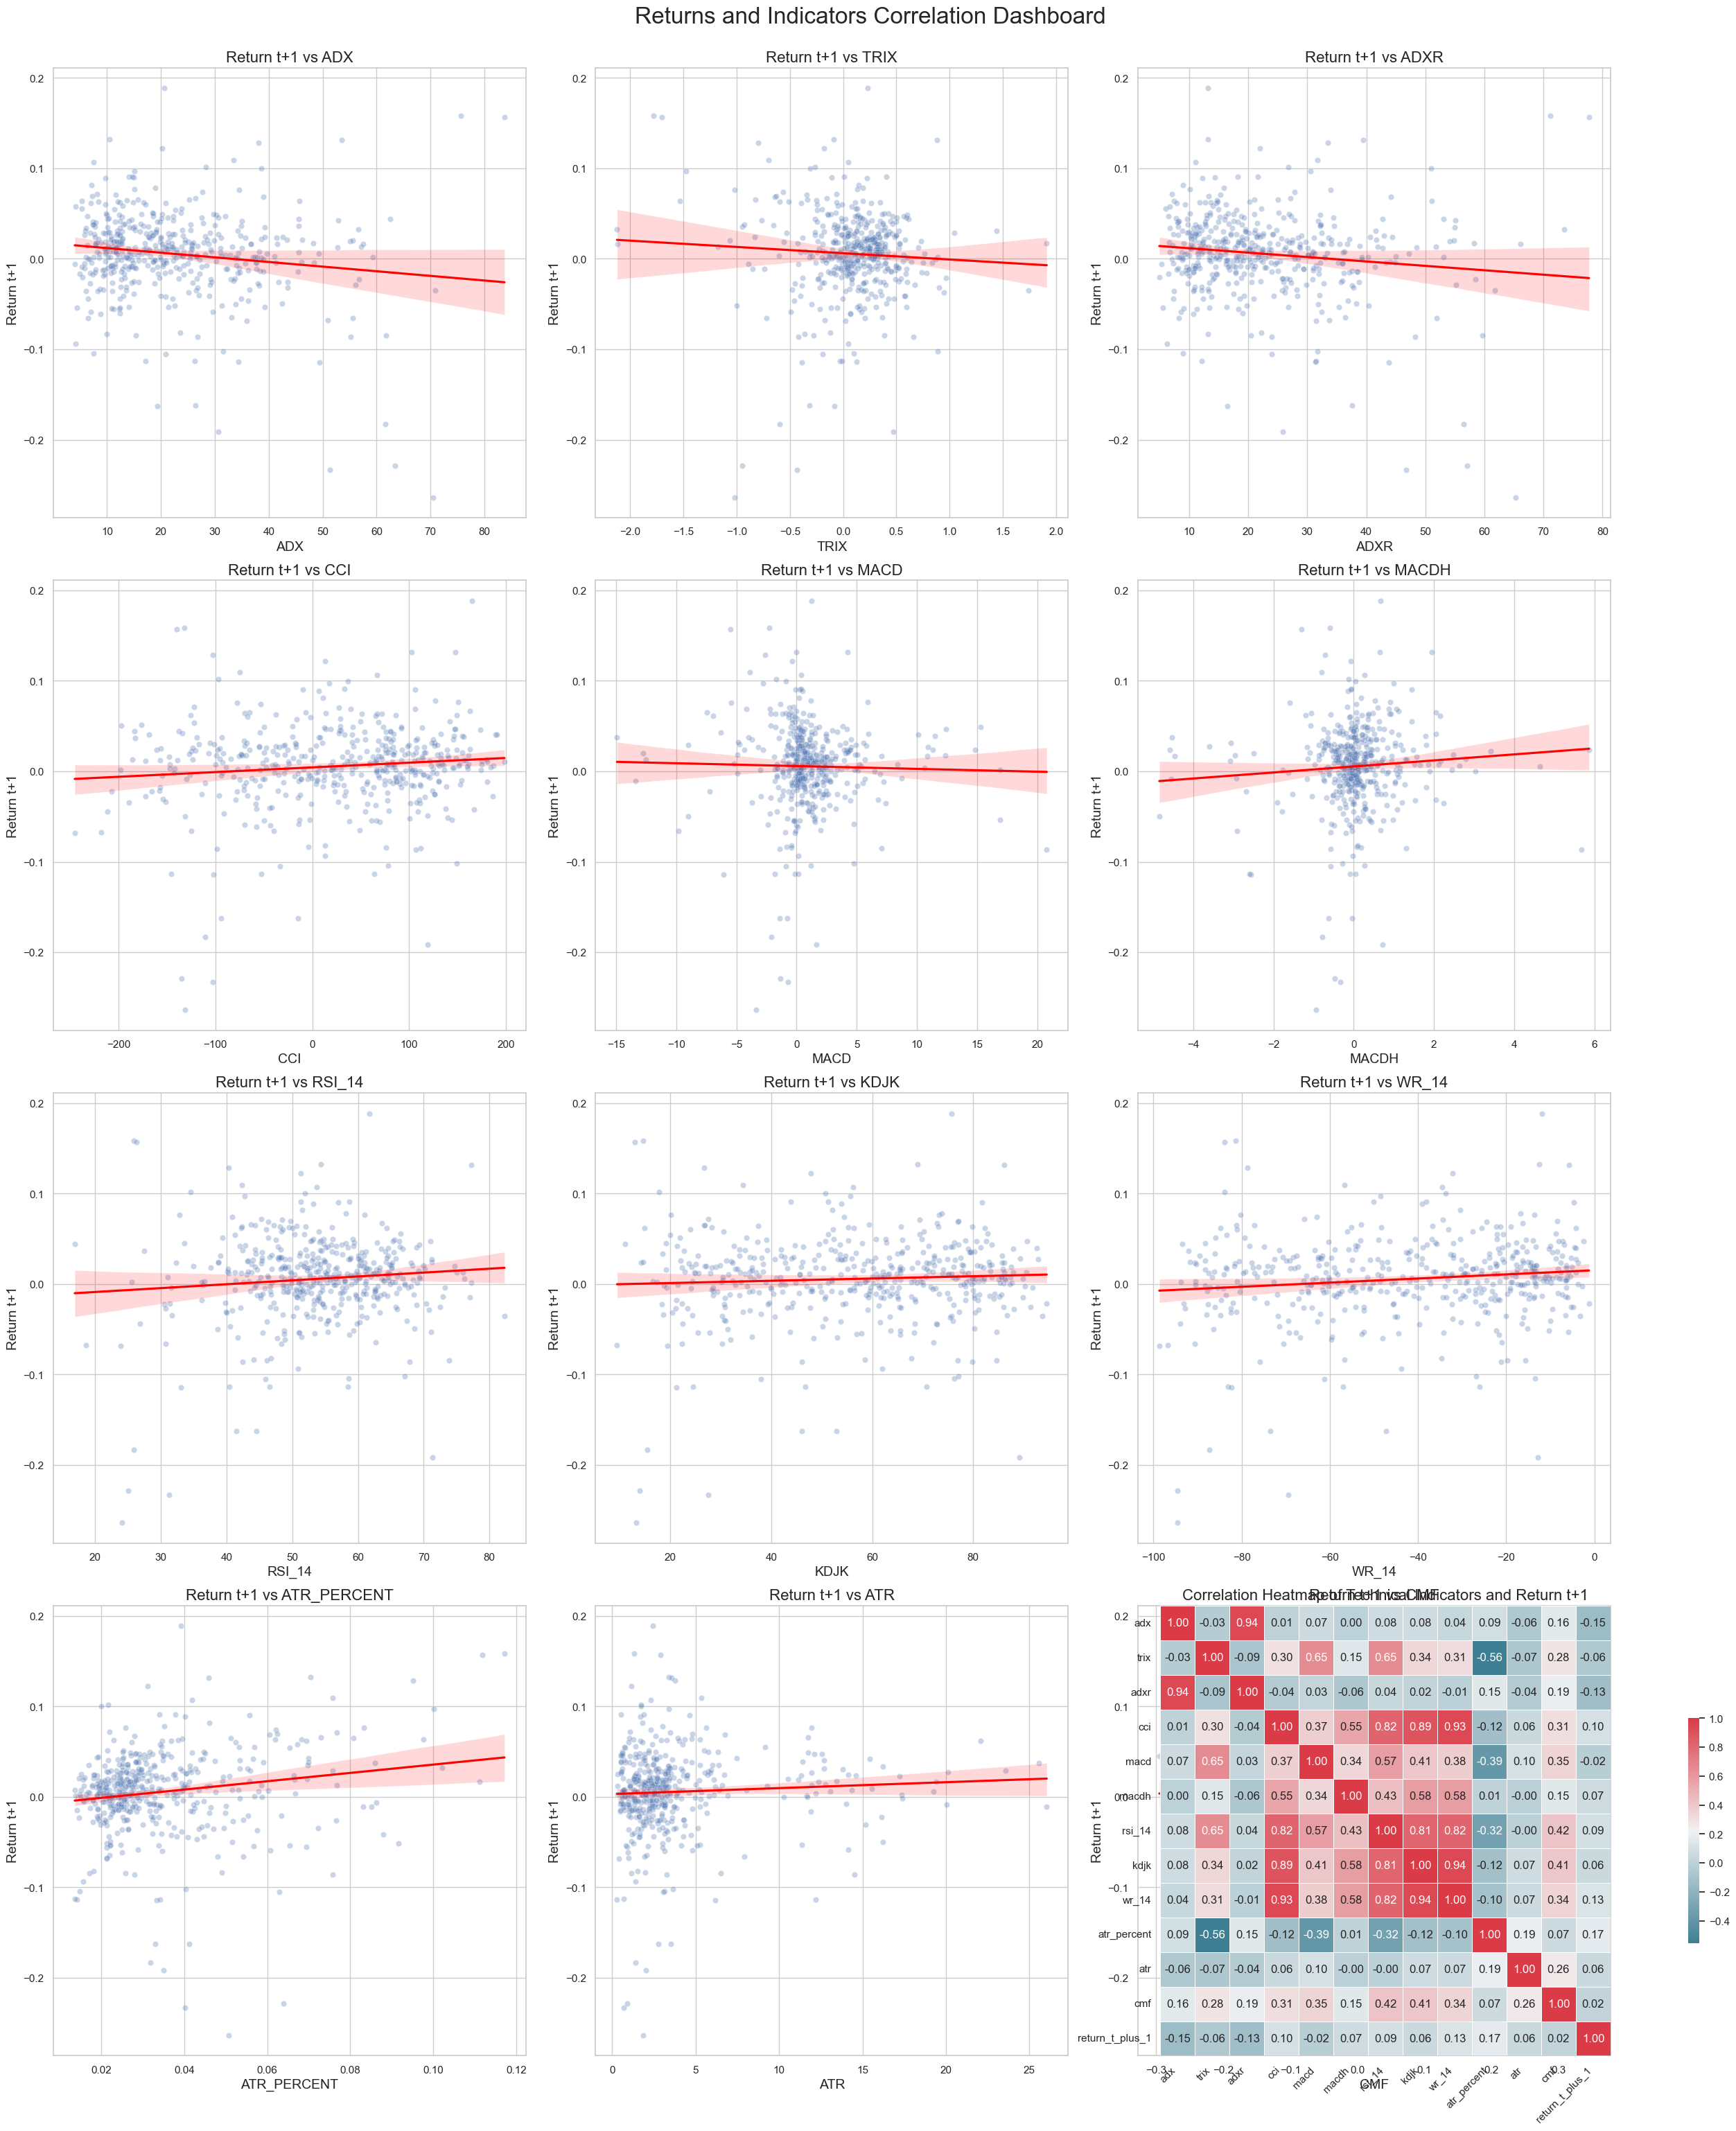

In [39]:
# List of technical indicators to analyze
technical_indicators = ['adx', 'trix', 'adxr', 'cci', 'macd', 'macdh',
                        'rsi_14', 'kdjk', 'wr_14', 'atr_percent', 'atr', 'cmf']

# Scatter Plots of Returns vs. Indicators
num_indicators = len(technical_indicators)
cols = 3
rows = num_indicators // cols + int(num_indicators % cols > 0)

# Correlation Heatmap
correlation_columns = technical_indicators + ['return_t_plus_1']
corr_matrix = df[correlation_columns].corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)


# Assemble All Plots into a Cohesive Dashboard
fig = plt.figure(constrained_layout=True, figsize=(25, 30))
gs = fig.add_gridspec(4, 3)

for i, indicator in enumerate(technical_indicators):
    # Scatter Plot
    row = i // cols
    col = i % cols
    ax = fig.add_subplot(gs[row, col])
    sns.scatterplot(data=df, x=indicator, y='return_t_plus_1', alpha=0.3, ax=ax)
    sns.regplot(data=df, x=indicator, y='return_t_plus_1', scatter=False, color='red', ax=ax)
    ax.set_title(f'Return t+1 vs {indicator.upper()}')
    ax.set_xlabel(indicator.upper())
    ax.set_ylabel('Return t+1')
    ax.grid(True)

# Correlation Heatmap spanning all columns
ax_heatmap = fig.add_subplot(gs[rows, :]) if num_indicators % cols != 0 else fig.add_subplot(gs[rows-1, :])
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax_heatmap)
ax_heatmap.set_title('Correlation Heatmap of Technical Indicators and Return t+1')
ax_heatmap.set_xticklabels(ax_heatmap.get_xticklabels(), rotation=45, ha='right')
ax_heatmap.set_yticklabels(ax_heatmap.get_yticklabels(), rotation=0)

plt.suptitle('Returns and Indicators Correlation Dashboard', fontsize=24, y=1.02)
plt.show()


### **Dashboard 5**


Average CMF Over Time:
        Date       cmf
0 2020-01-31  0.042742
1 2020-02-07  0.010617
2 2020-02-14  0.030626
3 2020-02-21  0.004505
4 2020-02-28 -0.085167


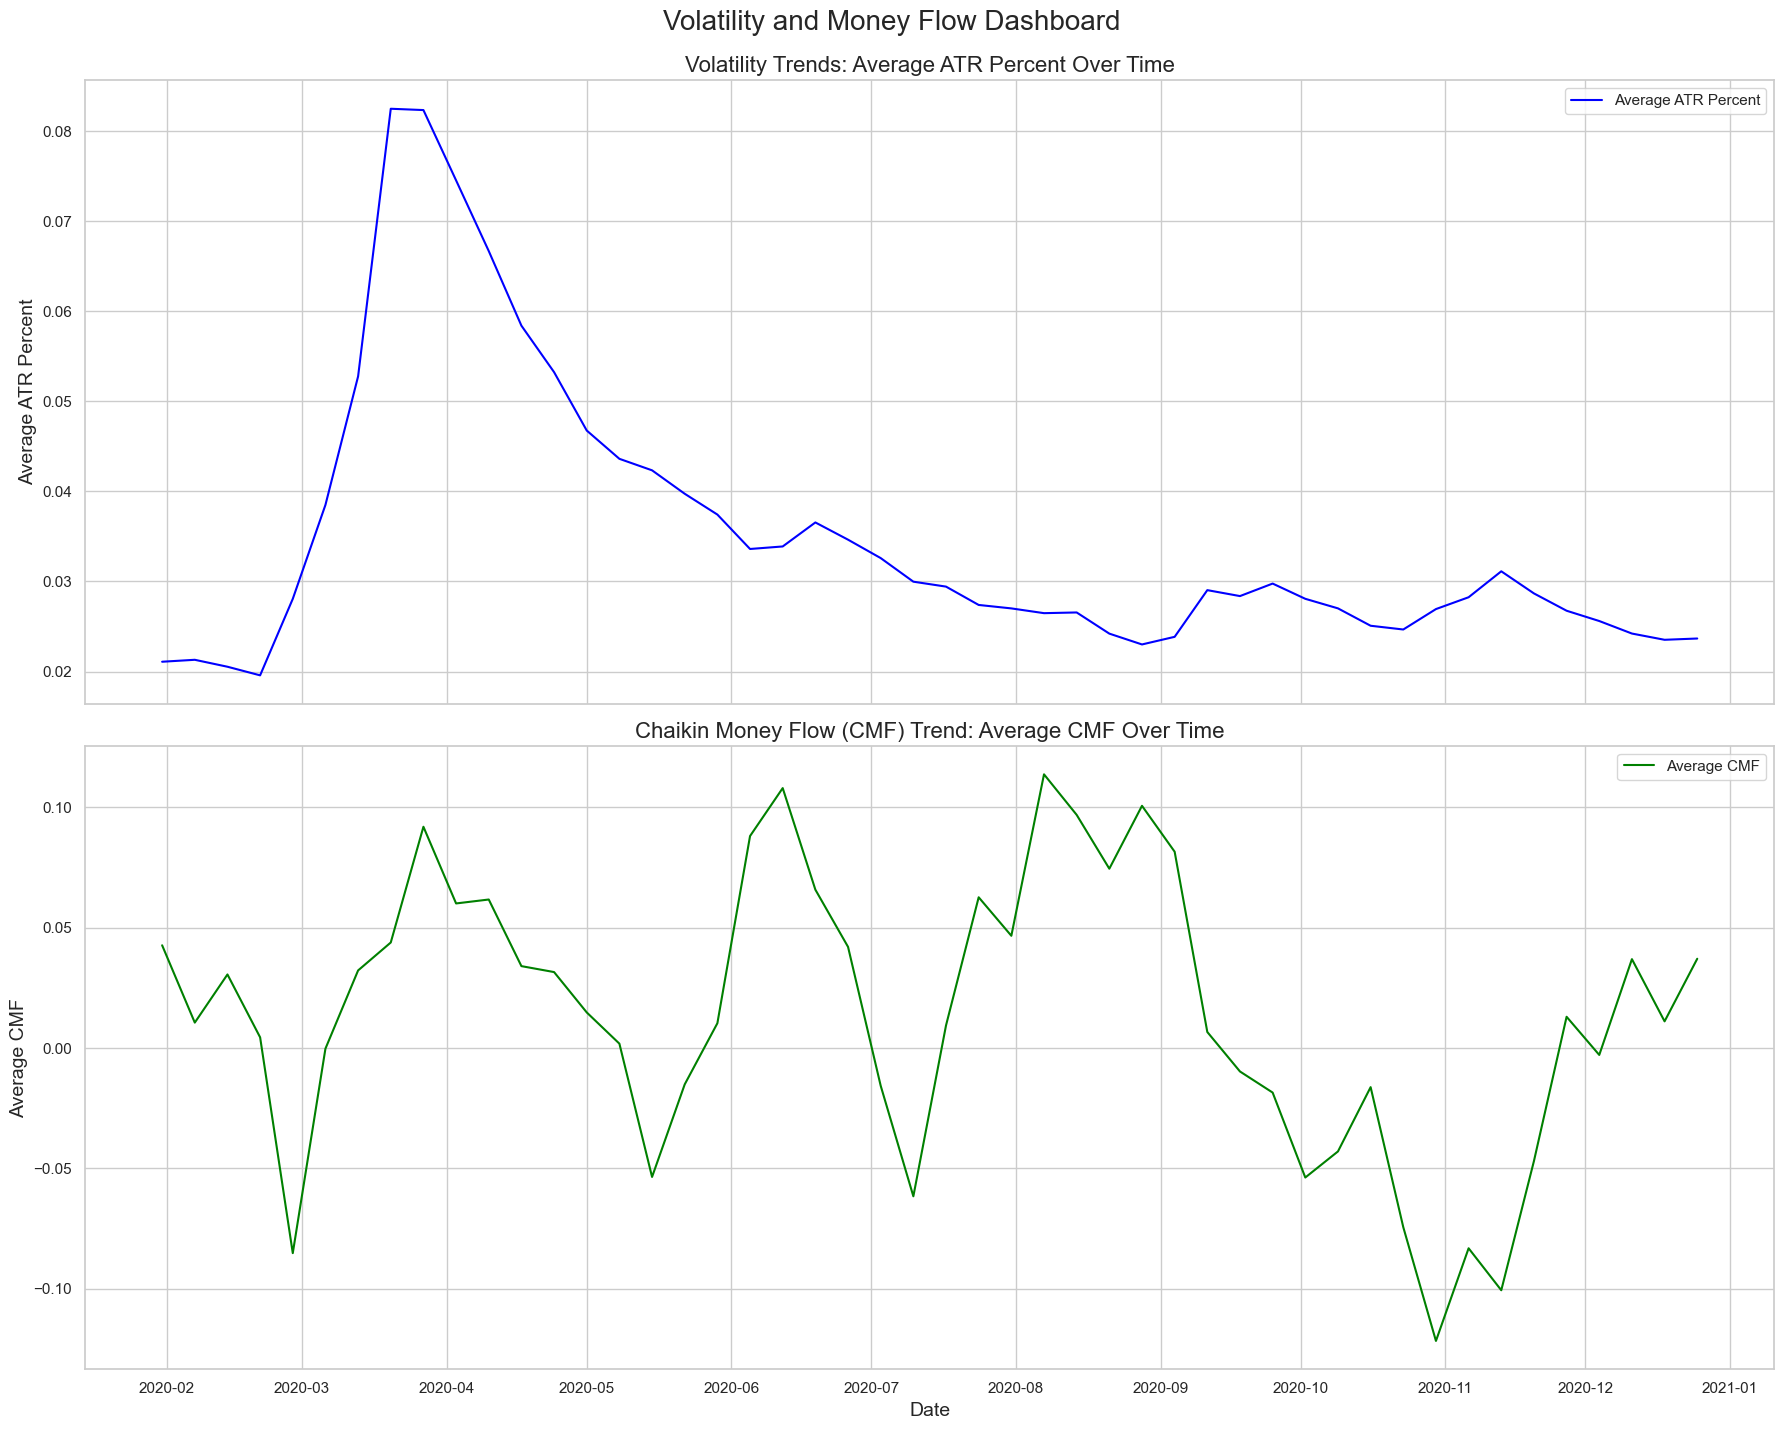

In [40]:
# Calculate Average ATR Percent Over Time
avg_atr_percent = df.groupby('Date')['atr_percent'].mean().reset_index()

# Calculate Average CMF Over Time
avg_cmf = df.groupby('Date')['cmf'].mean().reset_index()
print("\nAverage CMF Over Time:")
print(avg_cmf.head())

# Assemble the Dashboard
fig, axes = plt.subplots(2, 1, figsize=(18, 14), sharex=True)

# Plot Volatility Trends on the first subplot
sns.lineplot(data=avg_atr_percent, x='Date', y='atr_percent', color='blue', ax=axes[0], label='Average ATR Percent')
axes[0].set_title('Volatility Trends: Average ATR Percent Over Time', fontsize=16)
axes[0].set_ylabel('Average ATR Percent', fontsize=14)
axes[0].legend()
axes[0].grid(True)

# Plot CMF Trend on the second subplot
sns.lineplot(data=avg_cmf, x='Date', y='cmf', color='green', ax=axes[1], label='Average CMF')
axes[1].set_title('Chaikin Money Flow (CMF) Trend: Average CMF Over Time', fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('Average CMF', fontsize=14)
axes[1].legend()
axes[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Add an overall title for the dashboard
fig.suptitle('Volatility and Money Flow Dashboard', fontsize=20, y=1.02)

# Show the dashboard
plt.show()


### **Dashboard 6**


Average ATR Percent Over Time:
        Date  atr_percent
0 2020-01-31     0.021088
1 2020-02-07     0.021304
2 2020-02-14     0.020533
3 2020-02-21     0.019577
4 2020-02-28     0.028071

Average CMF Over Time:
        Date       cmf
0 2020-01-31  0.042742
1 2020-02-07  0.010617
2 2020-02-14  0.030626
3 2020-02-21  0.004505
4 2020-02-28 -0.085167


C:\Users\ACER\AppData\Local\Temp\ipykernel_11308\1312083819.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_gainers, x='ticker', y='return_t_plus_1', palette='viridis', ax=ax2)
C:\Users\ACER\AppData\Local\Temp\ipykernel_11308\1312083819.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_losers, x='ticker', y='return_t_plus_1', palette='magma', ax=ax4)
C:\Users\ACER\AppData\Local\Temp\ipykernel_11308\1312083819.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rsi_extremes, x='ticker', y='rsi_14', palette='coo

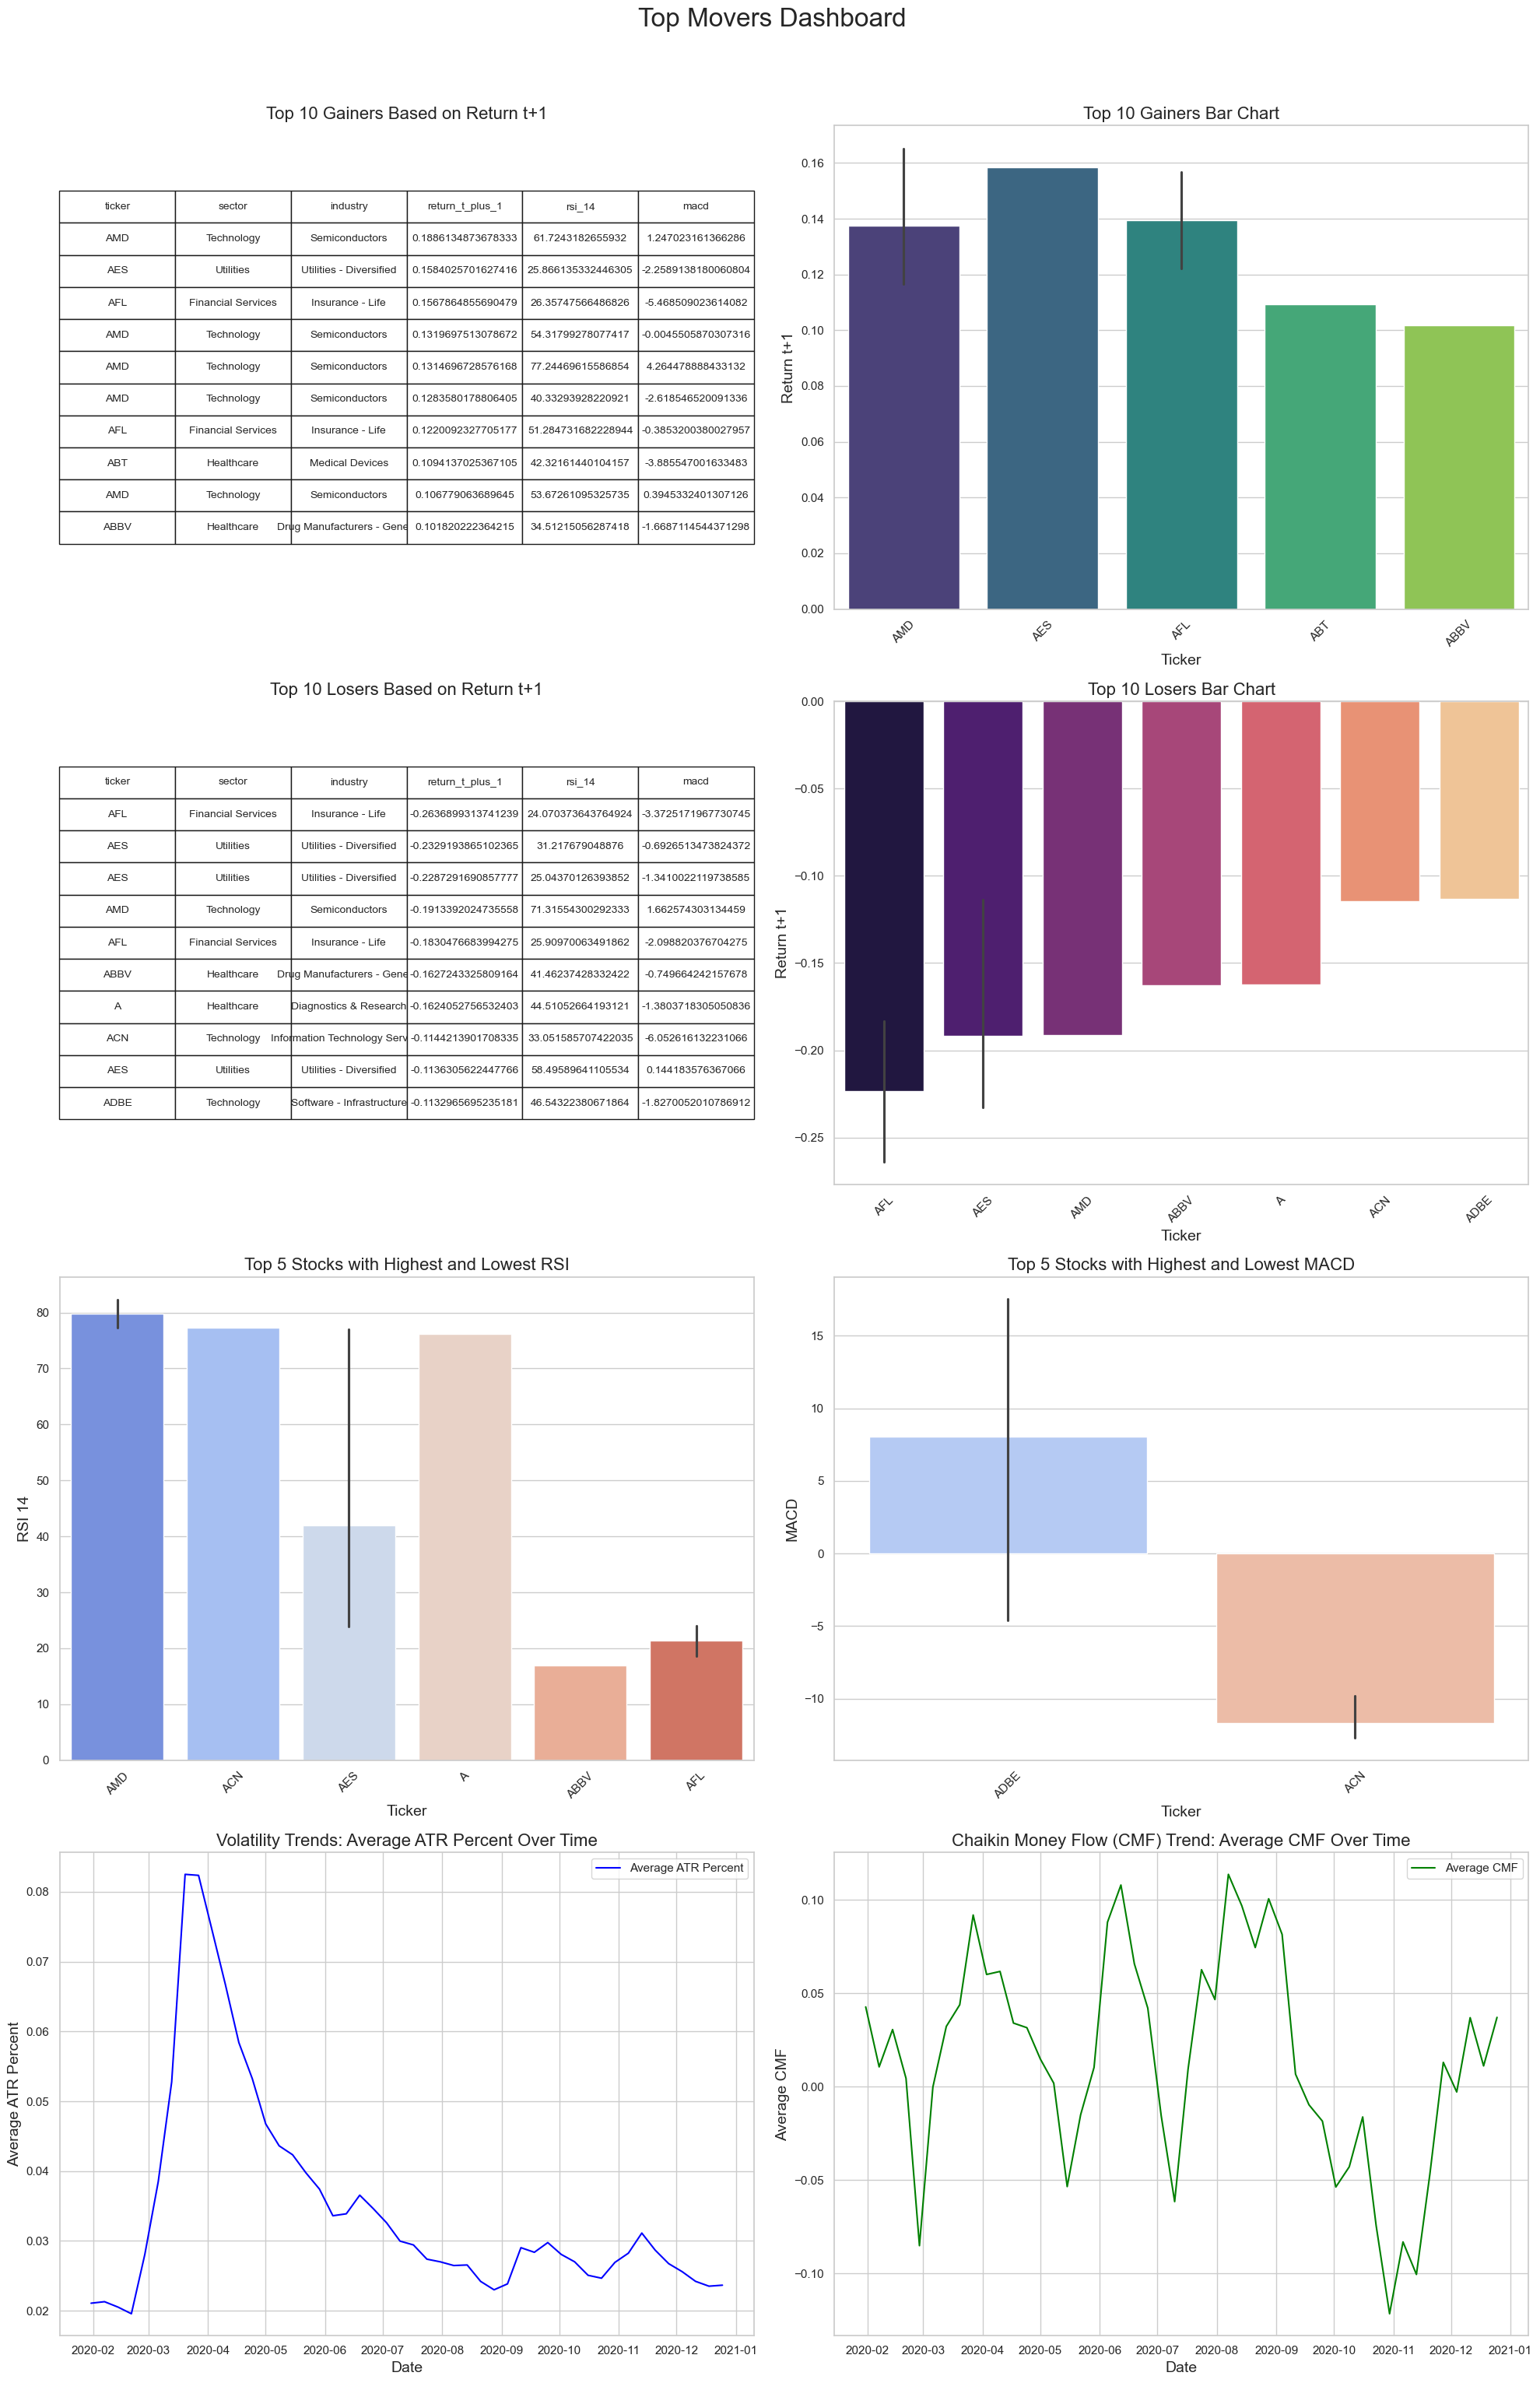

In [41]:
# Define the number of top movers to display
top_n = 10

# Top Gainers based on 'return_t_plus_1'
top_gainers = df.nlargest(top_n, 'return_t_plus_1')[['ticker', 'sector', 'industry', 'return_t_plus_1', 'rsi_14', 'macd']]

# Top Losers based on 'return_t_plus_1'
top_losers = df.nsmallest(top_n, 'return_t_plus_1')[['ticker', 'sector', 'industry', 'return_t_plus_1', 'rsi_14', 'macd']]

# Define the number of extreme stocks to display
extreme_n = 5

# Top 5 Stocks with Highest RSI
highest_rsi = df.nlargest(extreme_n, 'rsi_14')[['ticker', 'sector', 'industry', 'rsi_14', 'return_t_plus_1']]

# Bottom 5 Stocks with Lowest RSI
lowest_rsi = df.nsmallest(extreme_n, 'rsi_14')[['ticker', 'sector', 'industry', 'rsi_14', 'return_t_plus_1']]

# Top 5 Stocks with Highest MACD
highest_macd = df.nlargest(extreme_n, 'macd')[['ticker', 'sector', 'industry', 'macd', 'return_t_plus_1']]

# Bottom 5 Stocks with Lowest MACD
lowest_macd = df.nsmallest(extreme_n, 'macd')[['ticker', 'sector', 'industry', 'macd', 'return_t_plus_1']]

# Combine highest and lowest RSI for plotting
rsi_extremes = pd.concat([highest_rsi, lowest_rsi])

# Combine highest and lowest MACD for plotting
macd_extremes = pd.concat([highest_macd, lowest_macd])


# Calculate Average ATR Percent Over Time
avg_atr_percent = df.groupby('Date')['atr_percent'].mean().reset_index()
print("\nAverage ATR Percent Over Time:")
print(avg_atr_percent.head())

# Calculate Average CMF Over Time
avg_cmf = df.groupby('Date')['cmf'].mean().reset_index()
print("\nAverage CMF Over Time:")
print(avg_cmf.head())

# Assemble the Dashboard
fig = plt.figure(constrained_layout=True, figsize=(20, 30))
gs = fig.add_gridspec(4, 2)  # 4 rows, 2 columns

# 5.1. Top Gainers Table
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')  # Hide the axis
table1 = ax1.table(cellText=top_gainers.values,
                   colLabels=top_gainers.columns,
                   cellLoc='center',
                   loc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(10)
table1.scale(1, 2)
ax1.set_title('Top 10 Gainers Based on Return t+1', fontsize=16)

# 5.2. Top Gainers Bar Chart
ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(data=top_gainers, x='ticker', y='return_t_plus_1', palette='viridis', ax=ax2)
ax2.set_title('Top 10 Gainers Bar Chart', fontsize=16)
ax2.set_xlabel('Ticker')
ax2.set_ylabel('Return t+1')
ax2.tick_params(axis='x', rotation=45)

# 5.3. Top Losers Table
ax3 = fig.add_subplot(gs[1, 0])
ax3.axis('off')  # Hide the axis
table2 = ax3.table(cellText=top_losers.values,
                   colLabels=top_losers.columns,
                   cellLoc='center',
                   loc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(10)
table2.scale(1, 2)
ax3.set_title('Top 10 Losers Based on Return t+1', fontsize=16)

# 5.4. Top Losers Bar Chart
ax4 = fig.add_subplot(gs[1, 1])
sns.barplot(data=top_losers, x='ticker', y='return_t_plus_1', palette='magma', ax=ax4)
ax4.set_title('Top 10 Losers Bar Chart', fontsize=16)
ax4.set_xlabel('Ticker')
ax4.set_ylabel('Return t+1')
ax4.tick_params(axis='x', rotation=45)

# 5.5. Indicator Extremes - RSI
ax5 = fig.add_subplot(gs[2, 0])
sns.barplot(data=rsi_extremes, x='ticker', y='rsi_14', palette='coolwarm', ax=ax5)
ax5.set_title('Top 5 Stocks with Highest and Lowest RSI', fontsize=16)
ax5.set_xlabel('Ticker')
ax5.set_ylabel('RSI 14')
ax5.tick_params(axis='x', rotation=45)

# 5.6. Indicator Extremes - MACD
ax6 = fig.add_subplot(gs[2, 1])
sns.barplot(data=macd_extremes, x='ticker', y='macd', palette='coolwarm', ax=ax6)
ax6.set_title('Top 5 Stocks with Highest and Lowest MACD', fontsize=16)
ax6.set_xlabel('Ticker')
ax6.set_ylabel('MACD')
ax6.tick_params(axis='x', rotation=45)

# 5.7. Volatility Trends (ATR Percent)
ax7 = fig.add_subplot(gs[3, 0])
sns.lineplot(data=avg_atr_percent, x='Date', y='atr_percent', color='blue', ax=ax7, label='Average ATR Percent')
ax7.set_title('Volatility Trends: Average ATR Percent Over Time', fontsize=16)
ax7.set_xlabel('Date')
ax7.set_ylabel('Average ATR Percent')
ax7.legend()
ax7.grid(True)

# 5.8. Chaikin Money Flow (CMF) Trend
ax8 = fig.add_subplot(gs[3, 1])
sns.lineplot(data=avg_cmf, x='Date', y='cmf', color='green', ax=ax8, label='Average CMF')
ax8.set_title('Chaikin Money Flow (CMF) Trend: Average CMF Over Time', fontsize=16)
ax8.set_xlabel('Date')
ax8.set_ylabel('Average CMF')
ax8.legend()
ax8.grid(True)

# Add an overall title for the dashboard
fig.suptitle('Top Movers Dashboard', fontsize=24, y=1.02)

# Adjust layout for better spacing
plt.tight_layout()

# Show the dashboard
plt.show()

# Optional: Save the Dashboard as an Image
# fig.savefig('top_movers_dashboard.png', dpi=300, bbox_inches='tight')
# print("\nDashboard saved as 'top_movers_dashboard.png'")


### **Dashboard 7**


Data with RSI and CCI Conditions:
  ticker       sector     rsi_14 RSI_Condition         cci CCI_Condition
0    MMM  Industrials  42.830339       Neutral  -53.979977       Neutral
1    MMM  Industrials  46.385024       Neutral   39.594017       Neutral
2    MMM  Industrials  54.243999       Neutral  161.128047    Overbought
3    MMM  Industrials  53.338383       Neutral   63.323686       Neutral
4    MMM  Industrials  50.615043       Neutral   13.990415       Neutral

RSI Condition Counts by Sector:
               sector RSI_Condition  count  total  percentage
0  Financial Services       Neutral     42     48   87.500000
1  Financial Services    Overbought      2     48    4.166667
2  Financial Services      Oversold      4     48    8.333333
3          Healthcare       Neutral    134    144   93.055556
4          Healthcare    Overbought      7    144    4.861111

CCI Condition Counts by Sector:
               sector CCI_Condition  count  total  percentage
0  Financial Services      

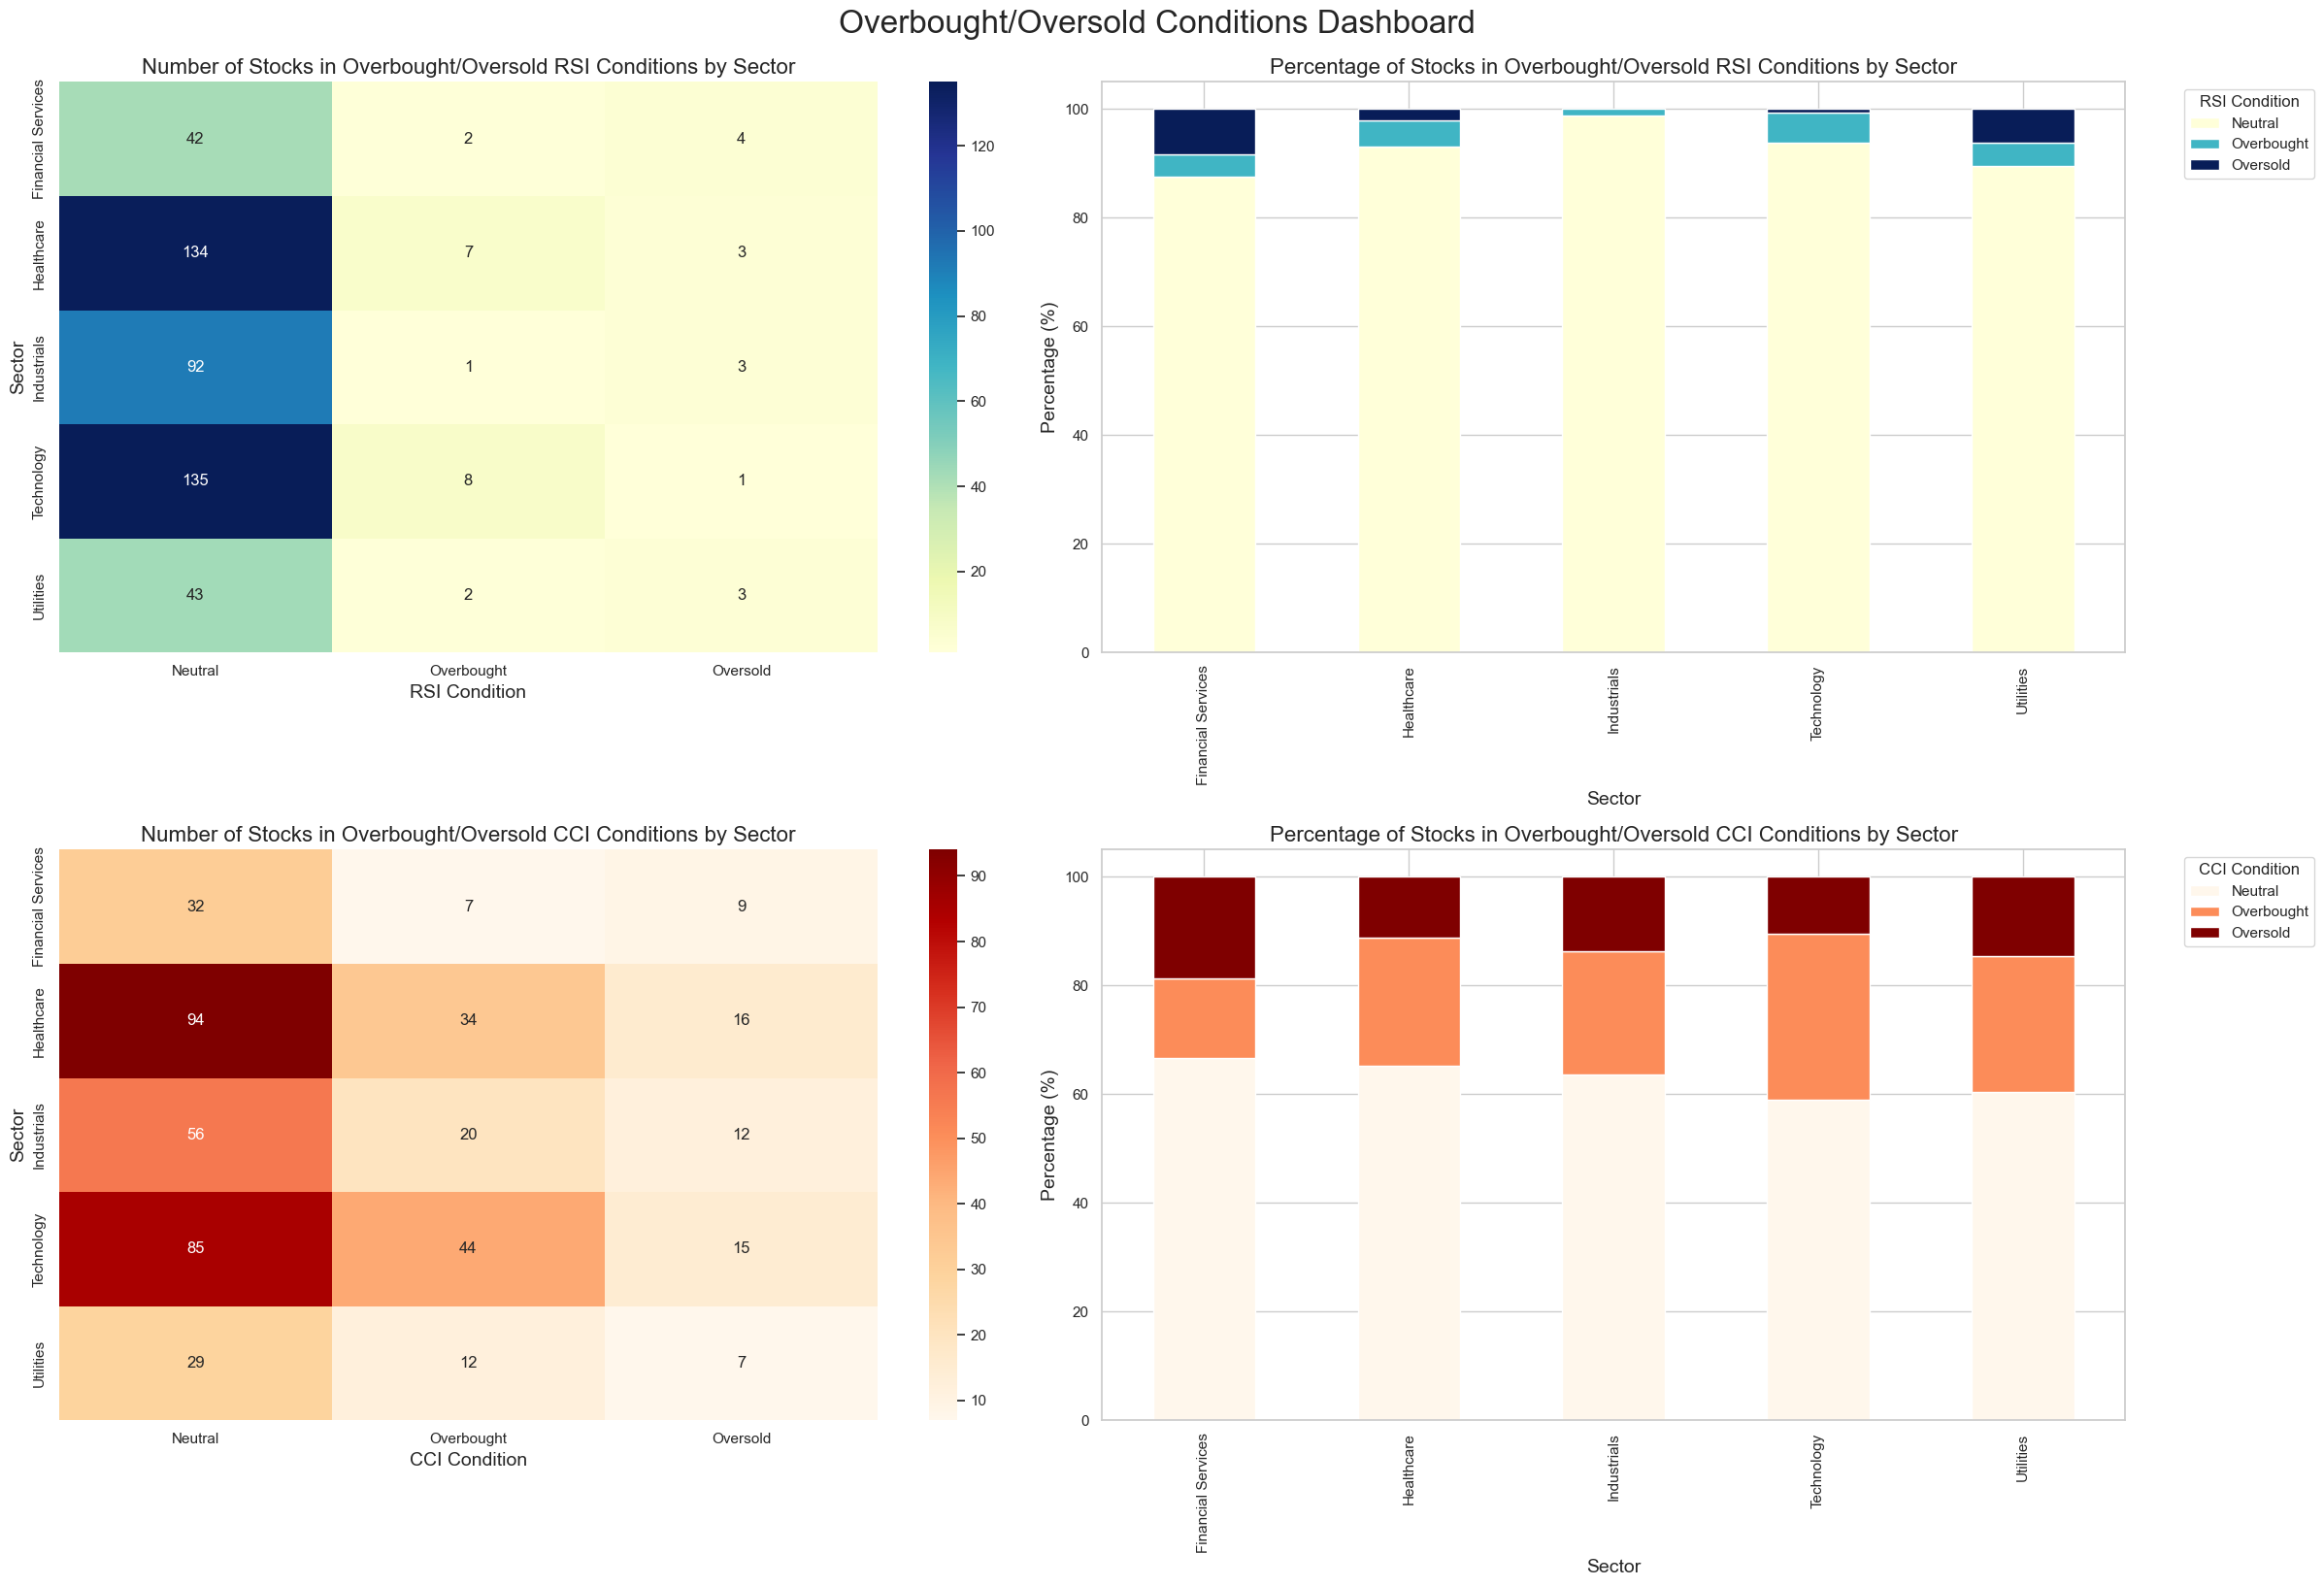

In [ ]:
# 3. Define Overbought and Oversold Thresholds
rsi_overbought = 70
rsi_oversold = 30
cci_overbought = 100
cci_oversold = -100

# 4. Flag Overbought and Oversold Stocks
df['RSI_Condition'] = 'Neutral'
df.loc[df['rsi_14'] > rsi_overbought, 'RSI_Condition'] = 'Overbought'
df.loc[df['rsi_14'] < rsi_oversold, 'RSI_Condition'] = 'Oversold'

df['CCI_Condition'] = 'Neutral'
df.loc[df['cci'] > cci_overbought, 'CCI_Condition'] = 'Overbought'
df.loc[df['cci'] < cci_oversold, 'CCI_Condition'] = 'Oversold'

print("\nData with RSI and CCI Conditions:")
print(df[['ticker', 'sector', 'rsi_14', 'RSI_Condition', 'cci', 'CCI_Condition']].head())

# 5. Calculate the Number and Percentage of Stocks in Each Condition by Sector
def calculate_condition_counts(df, condition_col):
    condition_counts = df.groupby(['sector', condition_col]).size().reset_index(name='count')
    total_counts = df.groupby('sector').size().reset_index(name='total')
    condition_counts = condition_counts.merge(total_counts, on='sector')
    condition_counts['percentage'] = (condition_counts['count'] / condition_counts['total']) * 100
    return condition_counts

# Calculate for RSI
rsi_condition_counts = calculate_condition_counts(df, 'RSI_Condition')

# Calculate for CCI
cci_condition_counts = calculate_condition_counts(df, 'CCI_Condition')

print("\nRSI Condition Counts by Sector:")
print(rsi_condition_counts.head())

print("\nCCI Condition Counts by Sector:")
print(cci_condition_counts.head())

# 6. Plot RSI Levels Across Market

# a. Heatmap of RSI Conditions by Sector
# a. Heatmap of RSI Conditions by Sector
rsi_pivot = rsi_condition_counts.pivot(index='sector', columns='RSI_Condition', values='count')
rsi_pivot = rsi_pivot.fillna(0)

# b. Bar Chart of RSI Conditions by Sector (Percentage)
rsi_pivot_percentage = rsi_condition_counts.pivot(index='sector', columns='RSI_Condition', values='percentage')
rsi_pivot_percentage = rsi_pivot_percentage.fillna(0)


# a. Heatmap of CCI Conditions by Sector
cci_pivot = cci_condition_counts.pivot(index='sector', columns='CCI_Condition', values='count')
cci_pivot = cci_pivot.fillna(0)

# b. Bar Chart of CCI Conditions by Sector (Percentage)
cci_pivot_percentage = cci_condition_counts.pivot(index='sector', columns='CCI_Condition', values='percentage')
cci_pivot_percentage = cci_pivot_percentage.fillna(0)

# 8. Assemble All Components into a Cohesive Dashboard

fig, axes = plt.subplots(2, 2, figsize=(24, 16))

# 8.1. RSI Heatmap
sns.heatmap(rsi_pivot, annot=True, fmt=".0f", cmap='YlGnBu', ax=axes[0, 0])
axes[0, 0].set_title('Number of Stocks in Overbought/Oversold RSI Conditions by Sector')
axes[0, 0].set_xlabel('RSI Condition')
axes[0, 0].set_ylabel('Sector')

# 8.2. RSI Percentage Bar Chart
rsi_pivot_percentage.plot(kind='bar', stacked=True, ax=axes[0, 1], colormap='YlGnBu')
axes[0, 1].set_title('Percentage of Stocks in Overbought/Oversold RSI Conditions by Sector')
axes[0, 1].set_xlabel('Sector')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].legend(title='RSI Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# 8.3. CCI Heatmap
sns.heatmap(cci_pivot, annot=True, fmt=".0f", cmap='OrRd', ax=axes[1, 0])
axes[1, 0].set_title('Number of Stocks in Overbought/Oversold CCI Conditions by Sector')
axes[1, 0].set_xlabel('CCI Condition')
axes[1, 0].set_ylabel('Sector')

# 8.4. CCI Percentage Bar Chart
cci_pivot_percentage.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='OrRd')
axes[1, 1].set_title('Percentage of Stocks in Overbought/Oversold CCI Conditions by Sector')
axes[1, 1].set_xlabel('Sector')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].legend(title='CCI Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()

# Add an overall title for the dashboard
fig.suptitle('Overbought/Oversold Conditions Dashboard', fontsize=24, y=1.02)

# Show the dashboard
plt.show()

# Optional: Save the Dashboard as an Image
# fig.savefig('overbought_oversold_conditions_dashboard.png', dpi=300, bbox_inches='tight')
# print("\nDashboard saved as 'overbought_oversold_conditions_dashboard.png'")


### **Dashboard 8**


Average ADX and ADXR Over Time:
        Date        adx       adxr
0 2020-01-31  28.168355  32.599543
1 2020-02-07  24.552204  28.234599
2 2020-02-14  23.686794  24.453135
3 2020-02-21  25.289069  24.809643
4 2020-02-28  34.826577  28.620706

Average MACD Histogram Over Time:
        Date     macdh
0 2020-01-31 -0.134183
1 2020-02-07  0.080038
2 2020-02-14  0.374171
3 2020-02-21  0.348507
4 2020-02-28 -0.942193


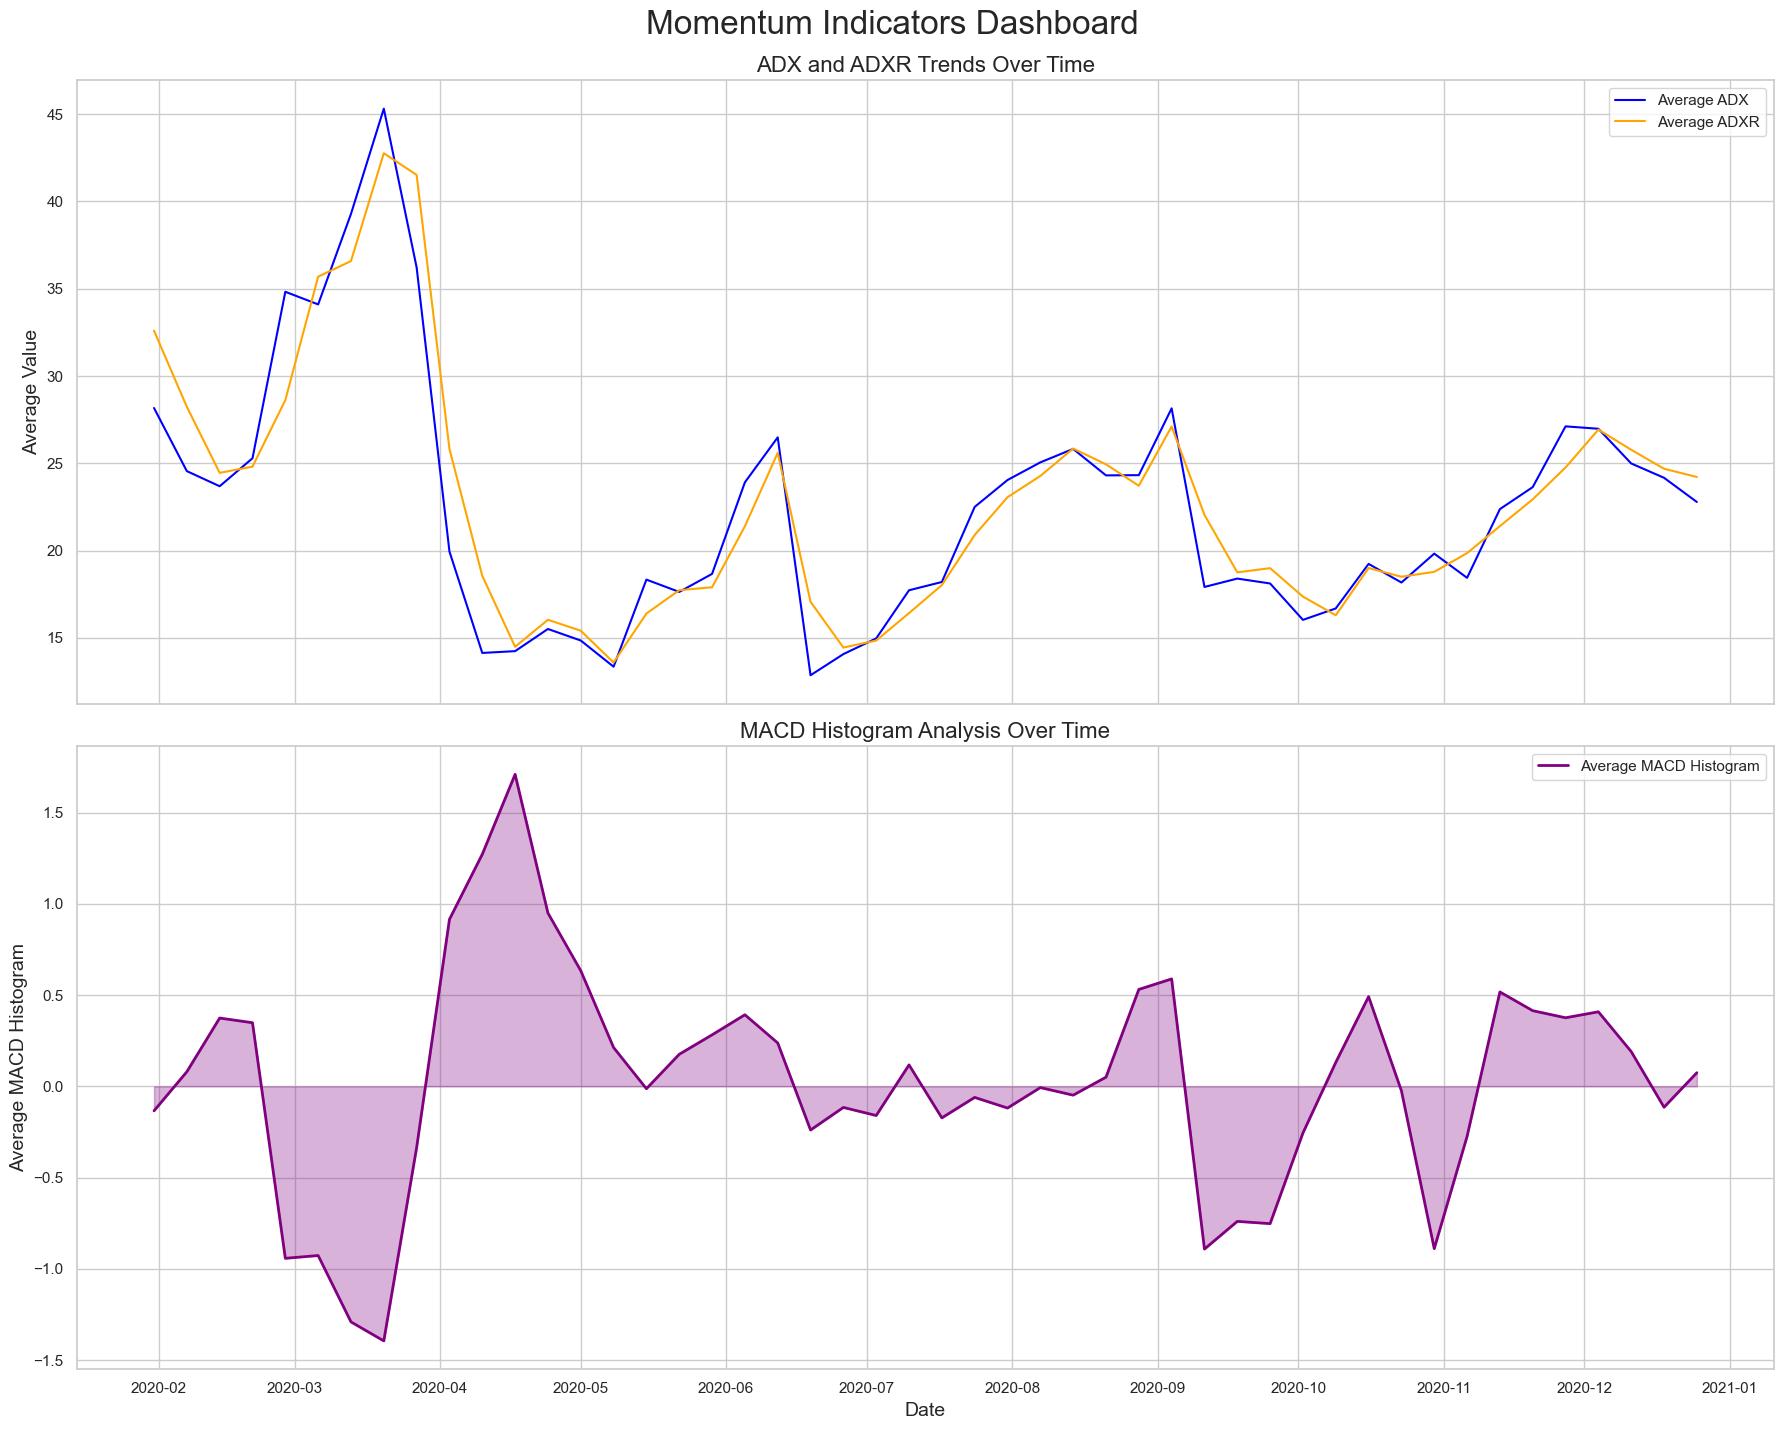

In [43]:
# 3. Calculate Average ADX and ADXR Over Time
avg_adx_adxr = df.groupby('Date')[['adx', 'adxr']].mean().reset_index()
print("\nAverage ADX and ADXR Over Time:")
print(avg_adx_adxr.head())

# 5. Calculate Average MACD Histogram Over Time
avg_macdh = df.groupby('Date')['macdh'].mean().reset_index()
print("\nAverage MACD Histogram Over Time:")
print(avg_macdh.head())

fig, axes = plt.subplots(2, 1, figsize=(18, 14), sharex=True)

# 7.1. ADX and ADXR Trends
sns.lineplot(data=avg_adx_adxr, x='Date', y='adx', color='blue', label='Average ADX', ax=axes[0])
sns.lineplot(data=avg_adx_adxr, x='Date', y='adxr', color='orange', label='Average ADXR', ax=axes[0])
axes[0].set_title('ADX and ADXR Trends Over Time', fontsize=16)
axes[0].set_ylabel('Average Value', fontsize=14)
axes[0].legend()
axes[0].grid(True)

# 7.2. MACD Histogram Analysis
sns.lineplot(data=avg_macdh, x='Date', y='macdh', color='purple', label='Average MACD Histogram', ax=axes[1], linewidth=2)
axes[1].fill_between(avg_macdh['Date'], avg_macdh['macdh'], color='purple', alpha=0.3)
axes[1].set_title('MACD Histogram Analysis Over Time', fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('Average MACD Histogram', fontsize=14)
axes[1].legend()
axes[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Add an overall title for the dashboard
fig.suptitle('Momentum Indicators Dashboard', fontsize=24, y=1.02)

# Show the dashboard
plt.show()

### **Dashboard 10**


MACD Crossover Signals:
         Date ticker MACD_Signal      macd    signal
2  2020-04-10    MMM         Buy -1.622055 -3.763441
13 2020-06-26    MMM        Sell  1.101877  1.729615
20 2020-08-14    MMM         Buy  0.964064  0.648375
26 2020-09-25    MMM        Sell  0.432414  1.032419
29 2020-10-16    MMM         Buy  0.943266  0.935465

Buy Signals:


Date ticker MACD_Signal       macd    signal
2   2020-04-10    MMM         Buy  -1.622055 -3.763441
20  2020-08-14    MMM         Buy   0.964064  0.648375
29  2020-10-16    MMM         Buy   0.943266  0.935465
34  2020-11-20    MMM         Buy   1.467535  0.322006
50  2020-04-10    AOS         Buy  -0.732031 -0.959339
65  2020-07-24    AOS         Buy   1.182535  1.075963
74  2020-09-25    AOS         Buy   0.844786  0.308039
83  2020-11-27    AOS         Buy   0.913564  0.731557
88  2020-01-31    ABT         Buy   0.443222  0.373251
98  2020-04-10    ABT         Buy   0.252616 -1.434703
111 2020-07-10    ABT         Buy   0.452666  0.428029
119 2020-09-04    ABT         Buy   2.618736  1.719769
129 2020-11-13    ABT         Buy   1.318532  0.899743
138 2020-02-14   ABBV         Buy   1.667264 -0.074313
147 2020-04-17   ABBV         Buy  -0.087333 -1.441796
176 2020-11-06   ABBV         Buy  -0.003878 -1.315970
194 2020-04-10    ACN         Buy  -4.924316 -5.887751
207 2020-07-10    ACN         Buy   5.372519  5.188851
214 2020-08-28    ACN         Buy   4.822414  4.645369
225 2020-11-13    ACN         Buy   2.780826 -0.642470
234 2020-02-14   ADBE         Buy   5.704365  4.417085
243 2020-04-17   ADBE         Buy  -0.331764 -5.190815
262 2020-08-28   ADBE         Buy  14.830394  9.691976
276 2020-12-04   ADBE         Buy  -0.207644 -1.212624
290 2020-04-10    AMD         Buy  -0.004551 -0.532317
304 2020-07-17    AMD         Buy   0.394533  0.254730
322 2020-11-20    AMD         Buy   0.483891  0.154932
338 2020-04-10    AES         Buy  -0.776856 -0.889713
365 2020-10-16    AES         Buy   0.493058  0.462806
375 2020-12-25    AES         Buy   0.570460  0.405346
386 2020-04-10    AFL         Buy  -1.610527 -2.354388
404 2020-08-14    AFL         Buy   0.281633 -0.054613
412 2020-10-09    AFL         Buy   0.126314  0.112741
417 2020-11-13    AFL         Buy   0.820541  0.049031
434 2020-04-10      A         Buy  -0.708761 -2.006785
449 2020-07-24      A         Buy   2.261959  1.938519
460 2020-10-09      A         Buy   1.104319  1.016615


Sell Signals:


Date ticker MACD_Signal       macd     signal
13  2020-06-26    MMM        Sell   1.101877   1.729615
26  2020-09-25    MMM        Sell   0.432414   1.032419
31  2020-10-30    MMM        Sell   0.056577   0.731245
40  2020-01-31    AOS        Sell  -0.644123   0.887210
61  2020-06-26    AOS        Sell   0.627126   1.137518
67  2020-08-07    AOS        Sell   0.243369   0.927064
79  2020-10-30    AOS        Sell   0.248622   0.649538
84  2020-12-04    AOS        Sell   0.549216   0.675928
89  2020-02-07    ABT        Sell   0.203815   0.405931
104 2020-05-22    ABT        Sell   0.698101   1.166821
118 2020-08-28    ABT        Sell   1.305891   1.408525
120 2020-09-11    ABT        Sell   1.621998   1.849695
131 2020-11-27    ABT        Sell   0.321229   0.856676
141 2020-03-06   ABBV        Sell  -0.041975   0.106191
157 2020-06-26   ABBV        Sell   2.068020   2.100261
183 2020-12-25   ABBV        Sell   1.620372   2.277889
205 2020-06-26    ACN        Sell   3.603756   4.744499
208 2020-07-17    ACN        Sell   5.035335   5.324659
216 2020-09-11    ACN        Sell   2.926601   4.369889
232 2020-01-31   ADBE        Sell   2.443673   3.454635
236 2020-02-28   ADBE        Sell   1.527458   4.304215
256 2020-07-17   ADBE        Sell  12.367763  13.140167
265 2020-09-18   ADBE        Sell   5.699494   8.889785
284 2020-02-28    AMD        Sell   0.160910   1.679009
297 2020-05-29    AMD        Sell   0.546639   1.095786
312 2020-09-11    AMD        Sell   2.238666   4.209318
328 2020-01-31    AES        Sell  -0.011508   1.343740
360 2020-09-11    AES        Sell   0.363725   0.540447
371 2020-11-27    AES        Sell   0.352948   0.428691
376 2020-01-31    AFL        Sell  -0.044143   0.339439
397 2020-06-26    AFL        Sell  -0.053204   0.113659
409 2020-09-18    AFL        Sell   0.061301   0.122895
415 2020-10-30    AFL        Sell  -0.279679   0.024532
423 2020-12-25    AFL        Sell   0.556216   1.045151
445 2020-06-26      A        Sell   1.332759   1.842151
453 2020-08-21      A        Sell   1.475029   1.626226


Signals with Forward Returns:
        Date ticker MACD_Signal      macd    signal  return_t_plus_1
0 2020-04-10    MMM         Buy -1.622055 -3.763441         0.007657
1 2020-06-26    MMM        Sell  1.101877  1.729615         0.007942
2 2020-08-14    MMM         Buy  0.964064  0.648375        -0.002183
3 2020-09-25    MMM        Sell  0.432414  1.032419        -0.003862
4 2020-10-16    MMM         Buy  0.943266  0.935465         0.007641

Average Forward Return after Buy Signals: 1.64%
Average Forward Return after Sell Signals: 0.95%


C:\Users\ACER\AppData\Local\Temp\ipykernel_11308\1459148720.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=forward_returns, x='Signal', y='Average Return t+1', palette=['green', 'red'], ax=ax4)
C:\Users\ACER\AppData\Local\Temp\ipykernel_11308\1459148720.py:92: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


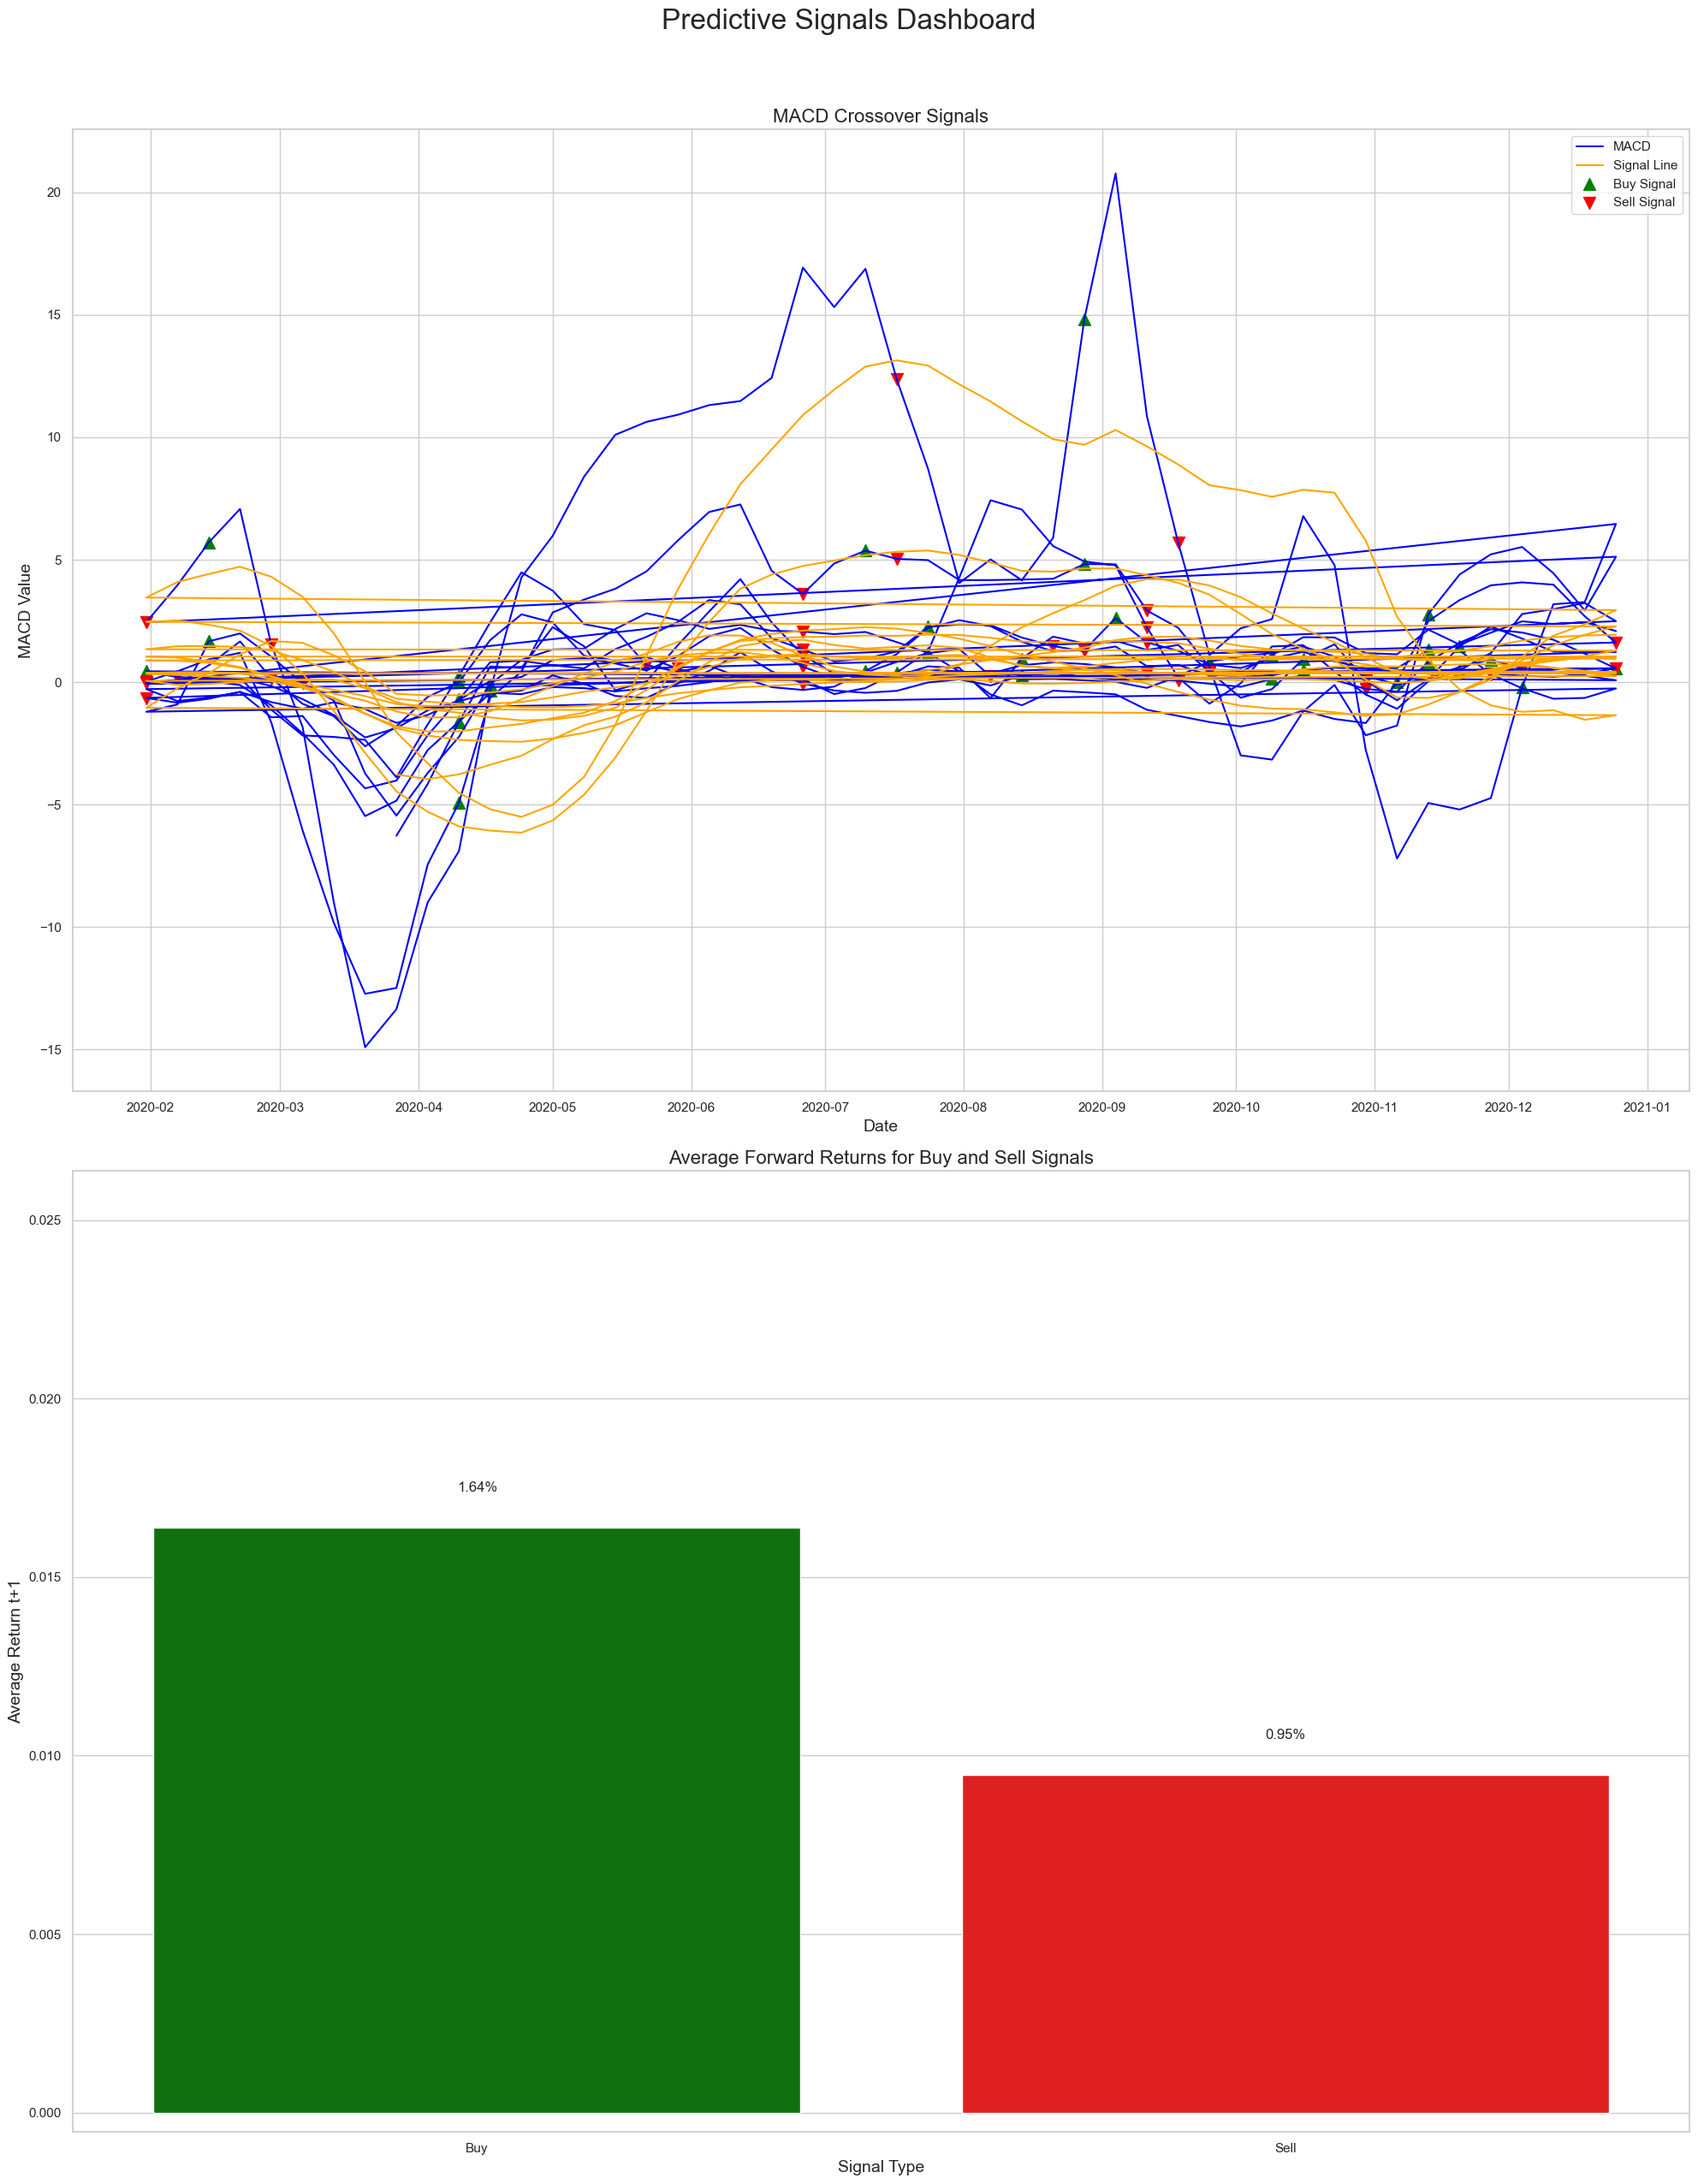

In [44]:
# 3. Identify Buy/Sell Signals Based on MACD Crossovers
# Check if 'signal' column exists
if 'signal' not in df.columns:
    # Calculate the signal line as the rolling mean of MACD
    df['signal'] = df['macd'].rolling(window=9).mean()

# Drop rows where 'signal' is NaN due to rolling window
df = df.dropna(subset=['signal']).reset_index(drop=True)

# Create a column for MACD Crossover Signals
df['MACD_Signal'] = 'Hold'  # Default value

# Identify Buy Signals: MACD crosses above Signal line
buy_signals = (df['macd'] > df['signal']) & (df['macd'].shift(1) <= df['signal'].shift(1))
df.loc[buy_signals, 'MACD_Signal'] = 'Buy'

# Identify Sell Signals: MACD crosses below Signal line
sell_signals = (df['macd'] < df['signal']) & (df['macd'].shift(1) >= df['signal'].shift(1))
df.loc[sell_signals, 'MACD_Signal'] = 'Sell'

# Extract only the signals
signal_df = df[df['MACD_Signal'] != 'Hold'][['Date', 'ticker', 'MACD_Signal', 'macd', 'signal']]

print("\nMACD Crossover Signals:")
print(signal_df.head())

# 4. Display Technical Signals Summary in Tables
from IPython.display import display

# Separate Buy and Sell Signals
buy_signals_df = signal_df[signal_df['MACD_Signal'] == 'Buy']
sell_signals_df = signal_df[signal_df['MACD_Signal'] == 'Sell']

print("\nBuy Signals:")
display(buy_signals_df)

print("\nSell Signals:")
display(sell_signals_df)

# 6. Forward Returns Analysis
# Merge signals with the main DataFrame to get 'return_t_plus_1'
signals_with_returns = signal_df.merge(df[['Date', 'ticker', 'return_t_plus_1']], on=['Date', 'ticker'], how='left')

print("\nSignals with Forward Returns:")
print(signals_with_returns.head())

# Calculate average return_t_plus_1 for Buy and Sell Signals
avg_return_buy = signals_with_returns[signals_with_returns['MACD_Signal'] == 'Buy']['return_t_plus_1'].mean()
avg_return_sell = signals_with_returns[signals_with_returns['MACD_Signal'] == 'Sell']['return_t_plus_1'].mean()

print(f"\nAverage Forward Return after Buy Signals: {avg_return_buy:.2%}")
print(f"Average Forward Return after Sell Signals: {avg_return_sell:.2%}")

# Create a DataFrame for plotting
forward_returns = pd.DataFrame({
    'Signal': ['Buy', 'Sell'],
    'Average Return t+1': [avg_return_buy, avg_return_sell]
})


# 7. Assemble All Components into a Cohesive Dashboard
fig = plt.figure(constrained_layout=True, figsize=(20, 25))
gs = fig.add_gridspec(2, 1)  # 4 rows, 1 column

# 7.3. Technical Signals Summary - MACD Crossover Plot
ax3 = fig.add_subplot(gs[0, 0])
plt.sca(ax3)
plt.plot(df['Date'], df['macd'], label='MACD', color='blue')
plt.plot(df['Date'], df['signal'], label='Signal Line', color='orange')
plt.scatter(buy_signals_df['Date'], buy_signals_df['macd'], marker='^', color='green', s=100, label='Buy Signal')
plt.scatter(sell_signals_df['Date'], sell_signals_df['macd'], marker='v', color='red', s=100, label='Sell Signal')
plt.title('MACD Crossover Signals')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)

# 7.4. Forward Returns Analysis - Average Returns Bar Chart
ax4 = fig.add_subplot(gs[1, 0])
sns.barplot(data=forward_returns, x='Signal', y='Average Return t+1', palette=['green', 'red'], ax=ax4)
ax4.set_title('Average Forward Returns for Buy and Sell Signals')
ax4.set_xlabel('Signal Type')
ax4.set_ylabel('Average Return t+1')
ax4.set_ylim(forward_returns['Average Return t+1'].min() - 0.01, forward_returns['Average Return t+1'].max() + 0.01)
for index, row in forward_returns.iterrows():
    ax4.text(index, row['Average Return t+1'] + 0.001, f"{row['Average Return t+1']:.2%}", ha='center')
    
# Add an overall title for the dashboard
fig.suptitle('Predictive Signals Dashboard', fontsize=24, y=1.02)

# Adjust layout for better spacing
plt.tight_layout()

# Show the dashboard
plt.show()

